# Generalization × Anxiety analysis


In [1]:
import json
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.special import expit, logit

import statsmodels.api as sm
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM



import pandas as pd
import numpy as np
from scipy import sparse
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
import pandas as pd
import ast # Import the Abstract Syntax Tree module


def find_obstacle_hits(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyzes a DataFrame to find rows containing an "obstacle" in the 'hits'
    column, robustly handling cases where the column contains string-formatted lists.

    Args:
        df: A pandas DataFrame with 'phase' and 'hits' columns.

    Returns:
        The DataFrame with a new boolean column 'has_obstacle'.
    """
    def parse_list_string(s):
        """Safely parse a string representation of a list."""
        if isinstance(s, list):
            return s
        try:
            # ast.literal_eval is the safe way to evaluate a string containing a Python literal
            return ast.literal_eval(s)
        except (ValueError, SyntaxError, TypeError):
            # Handle empty cells or malformed strings gracefully
            return []

    if HITS_COL not in df.columns:
        print(f"Warning: Column '{HITS_COL}' not found. Cannot perform obstacle analysis.")
        df['has_obstacle'] = False
        return df

    # 1. Create a clean, parsed version of the 'hits' column
    parsed_hits = df[HITS_COL].apply(parse_list_string)

    # 2. Create masks based on the parsed data
    phase1_mask = df[PHASE_COL] == 1
    obstacle_mask = parsed_hits.apply(lambda hit_list: 'obstacle' in hit_list)

    # 3. Combine masks and add the new column
    df['has_obstacle'] = (phase1_mask & obstacle_mask)

    return df


def analyze_valid_key_usage_per_subject(subject_df):
    """
    Analyzes a single subject's data to find the difference in the usage of
    VALID keys between dangerous and non-dangerous contexts.

    A "valid key" is a key that is defined in the VALID_KEYS dictionary
    as belonging to the vehicle category for that specific trial.

    Args:
        subject_df (pd.DataFrame): A DataFrame containing all trials for one subject.

    Returns:
        dict: A dictionary with the participant's ID, worry score, and the
              calculated difference in valid key usage.
    """
    # Ensure plan column is a string to handle potential NaNs
    subject_df[PLAN_COL] = subject_df[PLAN_COL].astype(str)

    # --- Helper to count how many keys in a plan are valid for the given vehicle ---
    def count_valid_keys(row):
        plan = row[PLAN_COL]
        vehicle_type = row[VEHICLE_COL]

        # Get the set of valid keys for the vehicle type for a fast lookup
        allowed_keys = set(VALID_KEYS.get(vehicle_type, []))
        if not allowed_keys:
            return 0  # Return 0 if vehicle type has no defined keys

        return sum(1 for key in plan if key in allowed_keys)

    # Calculate valid key usage for every trial
    subject_df['valid_key_usage'] = subject_df.apply(count_valid_keys, axis=1)

    # Identify the dangerous vehicle for this participant
    dangerous_vehicle = subject_df[DANGEROUS_COL].iloc[0]
    participant_id = subject_df[PARTICIPANT_ID_COL].iloc[0]
    worry_score = subject_df[WORRY_COL].iloc[0]

    # Separate trials into dangerous and non-dangerous contexts
    dangerous_trials = subject_df[subject_df[VEHICLE_COL] == dangerous_vehicle]
    nondangerous_trials = subject_df[subject_df[VEHICLE_COL] != dangerous_vehicle]

    # Calculate the mean valid key usage for each context
    avg_usage_dangerous = dangerous_trials['valid_key_usage'].mean() if not dangerous_trials.empty else np.nan
    avg_usage_nondangerous = nondangerous_trials['valid_key_usage'].mean() if not nondangerous_trials.empty else np.nan

    # Calculate the final difference metric
    usage_difference = avg_usage_dangerous - avg_usage_nondangerous

    return {
        PARTICIPANT_ID_COL: participant_id,
        WORRY_COL: worry_score,
        'valid_key_usage_difference': usage_difference
    }
def plot_valid_key_usage_difference_vs_worry(df, filename):
    """
    Plots the difference in valid key usage (Dangerous - Non-Dangerous)
    against participant worry scores.
    """
    print("\n--- Plotting Correlation: Valid Key Usage Difference vs. Worry ---")

    diff_col = 'valid_key_usage_difference'
    sub_df = df[[WORRY_COL, diff_col]].dropna()

    if len(sub_df) < 3:
        print("Not enough data to plot valid key usage difference vs. worry.")
        return

    spearman_corr, spearman_p = stats.spearmanr(sub_df[WORRY_COL], sub_df[diff_col])

    plt.figure(figsize=(10, 6))
    sns.regplot(data=sub_df, x=WORRY_COL, y=diff_col, robust=True)
    plt.xlabel("Worry Score", fontsize=28)
    plt.ylabel("Safe←ΔGeneralization→Threat", fontsize=20)   
    annotation = f"ρ = {spearman_corr:.2f}, p = {spearman_p/2.0:.3f}"
    plt.title(annotation, fontsize=28, weight='bold')
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"✅ Correlation plot saved to '{filename}'")
    
def create_long_format_df(df, analysis_type):
    """Generic function to create long-format data for various analyses."""
    records = []
    for _, row in df.iterrows():
        participant_id = row[PARTICIPANT_ID_COL]
        plan_keys = parse_plan(row[PLAN_COL])
        for key in plan_keys:
            if analysis_type == 'key_press':
                for category in KEY_TO_CATEGORY.get(key, []):
                    records.append({PARTICIPANT_ID_COL: participant_id, 'category_chosen': category})
            elif analysis_type == 'mistake':
                actual_vehicle = row[VEHICLE_COL]
                if key not in VALID_KEYS.get(actual_vehicle, set()):
                    for guessed_cat in KEY_TO_CATEGORY.get(key, ["unknown"]):
                        if guessed_cat != actual_vehicle:
                            records.append({PARTICIPANT_ID_COL: participant_id, 'actual_vehicle': actual_vehicle, 'guessed_category': guessed_cat})
            elif analysis_type == 'accuracy':
                vehicle = row[VEHICLE_COL]
                is_valid = 1 if key in VALID_KEYS.get(vehicle, set()) else 0
                records.append({PARTICIPANT_ID_COL: participant_id, 'vehicle': vehicle, 'is_valid': is_valid})
    return pd.DataFrame(records)

def filter_subjects_by_key_coverage(df, min_categories=4):
    """
    Keep participants who, based on all keys they actually pressed (PLAN_COL),
    'cover' at least `min_categories` distinct categories. A category is counted
    for a participant if ANY of their pressed keys appears in VALID_KEYS[that_category].

    Parameters
    ----------
    df : DataFrame (trial-level; must contain PARTICIPANT_ID_COL and PLAN_COL)
    min_categories : int

    Returns
    -------
    filtered_df : DataFrame
        Original df filtered to participants meeting the coverage criterion.
    coverage_df : DataFrame
        Per-participant coverage summary with the categories covered.
    """
    if df.empty:
        return df, pd.DataFrame(columns=[PARTICIPANT_ID_COL, 'n_categories_by_keys', 'categories_by_keys'])

    coverage_rows = []
    for pid, grp in df.groupby(PARTICIPANT_ID_COL, sort=False):
        # 1) all distinct keys this participant ever pressed
        keys_used = set()
        for seq in grp[PLAN_COL]:
            keys_used.update(parse_plan(seq))

        # 2) union of all categories that accept any of those keys
        cats_covered = set()
        for k in keys_used:
            cats_covered.update(KEY_TO_CATEGORY.get(k, []))  # KEY_TO_CATEGORY built from VALID_KEYS above

        coverage_rows.append({
            PARTICIPANT_ID_COL: pid,
            'n_categories_by_keys': len(cats_covered),
            'categories_by_keys': sorted(cats_covered)
        })

    coverage_df = pd.DataFrame(coverage_rows)

    keep_ids = coverage_df.loc[coverage_df['n_categories_by_keys'] >= min_categories, PARTICIPANT_ID_COL]
    before = df[PARTICIPANT_ID_COL].nunique()
    filtered_df = df[df[PARTICIPANT_ID_COL].isin(keep_ids)].copy()
    after = filtered_df[PARTICIPANT_ID_COL].nunique()

    print("\n--- Keyset-based Category Coverage Filter ---")
    print(f"Participants before: {before}")
    print(f"Participants after:  {after}")
    print(f"Removed (< {min_categories} categories covered by pressed keys): {before - after}")

    if after == 0:
        print("⚠️ All participants removed by keyset coverage filter.")

    return filtered_df, coverage_df


# You would also need to import your custom function
# from your_helper_file import test_marginal_mean_greater

def _glmm_get_beta_sigma(result):
    # beta0 (fixed intercept)
    if hasattr(result, "fe_mean"):
        beta0 = float(np.atleast_1d(result.fe_mean)[0])
        beta0_sd = float(np.atleast_1d(getattr(result, "fe_sd", [np.nan]))[0])
        if np.isnan(beta0_sd) and hasattr(result, "fe_cov"):
            beta0_sd = float(np.sqrt(np.diag(np.atleast_2d(result.fe_cov)))[0])
    else:
        beta0 = float(np.atleast_1d(result.params)[0])
        if hasattr(result, "bse") and result.bse is not None:
            beta0_sd = float(np.atleast_1d(result.bse)[0])
        else:
            beta0_sd = np.nan

    # sigma (random-intercept SD) — statsmodels stores log-SD in vcp_mean
    if hasattr(result, "vcp_mean"):
        log_sd = float(np.atleast_1d(result.vcp_mean)[0])
        sigma = float(np.exp(log_sd))
        # try to get SD of log-SD
        vcp_sd = getattr(result, "vcp_sd", None)
        if vcp_sd is not None:
            log_sd_sd = float(np.atleast_1d(vcp_sd)[0])
        elif hasattr(result, "vcp_cov") and result.vcp_cov is not None:
            log_sd_sd = float(np.sqrt(np.diag(np.atleast_2d(result.vcp_cov)))[0])
        else:
            log_sd_sd = np.nan
    else:
        # fallback if cov_re is available as variance on RE scale
        if hasattr(result, "cov_re") and result.cov_re is not None:
            sigma = float(np.sqrt(np.diag(np.atleast_2d(result.cov_re)))[0])
        else:
            raise RuntimeError("Could not extract random-effect SD from result.")
        log_sd = np.log(sigma)
        log_sd_sd = np.nan

    return beta0, beta0_sd, sigma, log_sd, log_sd_sd

def marginal_mean_from_glmm(beta0, sigma, draws=200000, seed=0):
    rng = np.random.default_rng(seed)
    u = rng.normal(0.0, sigma, size=draws)
    return float(expit(beta0 + u).mean())

def test_marginal_mean_greater(result, p0=0.5, n_param_boot=2000, mc_draws=10000, seed=1):
    """
    One-sided test H0: E[p] <= p0 vs H1: E[p] > p0, where E[p] is the
    population-averaged mean from a fitted GLMM (intercept-only).
    Uses parametric bootstrap over (beta0, sigma) approximated as normal
    on (beta0, log_sigma).
    """
    beta0, beta0_sd, sigma, log_sd, log_sd_sd = _glmm_get_beta_sigma(result)
    # point estimate of marginal mean
    p_bar_hat = marginal_mean_from_glmm(beta0, sigma, draws=mc_draws, seed=seed)

    # parametric bootstrap over parameter uncertainty
    rng = np.random.default_rng(seed)
    # If we lack SEs, fall back to a tiny jitter to avoid degenerate CI
    if not np.isfinite(beta0_sd) or beta0_sd <= 0:
        beta0_sd = 1e-6
    if not np.isfinite(log_sd_sd) or log_sd_sd <= 0:
        log_sd_sd = 1e-6

    beta0_samps = rng.normal(beta0, beta0_sd, size=n_param_boot)
    logsd_samps = rng.normal(log_sd, log_sd_sd, size=n_param_boot)
    sig_samps = np.exp(logsd_samps)

    pbar_samps = np.array([marginal_mean_from_glmm(b0, s, draws=2000, seed=int(seed+i))
                           for i, (b0, s) in enumerate(zip(beta0_samps, sig_samps))])

    # p-value for H0: E[p] <= p0 (right-tail test)
    p_one_sided = float((pbar_samps <= p0).mean())

    # 95% CI for E[p]
    ci_lo, ci_hi = np.quantile(pbar_samps, [0.025, 0.975])

    return {
        "p_bar_hat": p_bar_hat,
        "ci95": (float(ci_lo), float(ci_hi)),
        "p_one_sided": p_one_sided,
        "beta0": beta0,
        "sigma": sigma,
    }


def run_statsmodels_hier_logit_intercept_only(
    long_df,
    min_vehicle_types=2,
    test_probability=0.5,
    include_vehicle_re=False,
    fit_method="vb",          # "vb" (variational Bayes) or "map" (Laplace)
    vcp_p=1.0,                # prior sd on log std of RE (default in SM)
    fe_p=2.0,                 # prior sd for fixed effects
    random_state=123
):
    """
    Frequentist-like (approximate) hierarchical logistic regression using
    statsmodels.genmod.bayes_mixed_glm.BinomialBayesMixedGLM.

    Trial-level model:
        y_t ~ Bernoulli(p_t)
        logit(p_t) = β0 + u_participant[i(t)] [+ u_vehicleType[j(t)]]

    Random effects share variance per grouping factor (via ident labels).

    Parameters
    ----------
    include_vehicle_re : bool
        If True, add a crossed random intercept for vehicleType in addition to participant.

    Returns
    -------
    result : Fitted model object (VB or MAP)
    dropped_info : dict
    """

    df = long_df.copy()
    if df.empty:
        print("No data.")
        return None, {"reason": "empty_df"}

    for c in ("participant_id", "is_correct", "vehicleType"):
        if c not in df.columns:
            raise ValueError(f"Missing required column: {c}")

    # types
    df["participant_id"] = df["participant_id"].astype(str)
    df["vehicleType"] = df["vehicleType"].astype("category")
    df["is_correct"] = df["is_correct"].astype(int)
    if not set(df["is_correct"].unique()).issubset({0,1}):
        raise ValueError("is_correct must be binary (0/1) for BinomialBayesMixedGLM.")

    # filter: each participant must have >= min_vehicle_types distinct vehicleType
    vt_counts = df.groupby("participant_id")["vehicleType"].nunique()
    keep_parts = vt_counts[vt_counts >= min_vehicle_types].index
    dropped_parts = vt_counts[vt_counts < min_vehicle_types].index.tolist()
    df = df[df["participant_id"].isin(keep_parts)].copy()

    if df.empty:
        print(f"No participants meet ≥{min_vehicle_types} vehicle types.")
        return None, {
            "reason": "no_participants_meet_vehicleType_requirement",
            "min_vehicle_types": min_vehicle_types,
            "dropped_participants": dropped_parts,
        }

    # -----------------------------
    # Build design matrices (TRIAL LEVEL)
    # -----------------------------
    y = df["is_correct"].to_numpy(dtype=float)            # endog: 0/1 vector
    N = len(df)

    # Fixed effects: intercept only (N x 1 of ones)
    X = np.ones((N, 1), dtype=float)

    # Random effects blocks as sparse one-hot matrices
    # Participant block
    part_codes = pd.Categorical(df["participant_id"])
    I = len(part_codes.categories)
    rows = np.arange(N, dtype=int)
    cols = part_codes.codes.astype(int)
    Z_part = sparse.coo_matrix((np.ones(N), (rows, cols)), shape=(N, I)).tocsr()

    exog_vc_blocks = [Z_part]
    ident_labels = [np.zeros(I, dtype=int)]  # label 0 for all participant columns

    # Optional vehicleType block
    if include_vehicle_re:
        veh_codes = pd.Categorical(df["vehicleType"])
        J = len(veh_codes.categories)
        cols_v = veh_codes.codes.astype(int)
        Z_veh = sparse.coo_matrix((np.ones(N), (rows, cols_v)), shape=(N, J)).tocsr()

        exog_vc_blocks.append(Z_veh)
        # label 1 for all vehicle columns
        ident_labels.append(np.ones(J, dtype=int))

    # Stack random-effect blocks horizontally to get ONE (sparse) exog_vc
    exog_vc = sparse.hstack(exog_vc_blocks, format="csr")

    # ident must be length == total number of columns in exog_vc
    ident = np.concatenate(ident_labels).astype(int)

    # Sanity checks
    assert exog_vc.shape[0] == N
    assert ident.shape[0] == exog_vc.shape[1]

    # -----------------------------
    # Fit model
    # -----------------------------
    print(f"\nFitting BinomialBayesMixedGLM on {N} trials, "
          f"{I} participants"
          + (f", {J} vehicle types" if include_vehicle_re else "")
          + " ...")

    model = BinomialBayesMixedGLM(endog=y, exog=X, exog_vc=exog_vc, ident=ident,
                                  vcp_p=vcp_p, fe_p=fe_p)

    # if fit_method.lower() == "map":
    result = model.fit_map()  # Laplace/MAP approx
    # else:
    #     # Variational Bayes is fast and provides approx SEs
    #     result = model.fit_vb(mean_field=True, random_state=random_state)

    # -----------------------------
    # Intercept inference (one-sided test vs p0)
    # -----------------------------

    print(result.summary())
    
    res=test_marginal_mean_greater(result,p0=test_probability)
    print('res:{}'.format(res))

    dropped_info = {
        "min_vehicle_types": min_vehicle_types,
        "dropped_participants": dropped_parts,
        "n_kept": df["participant_id"].nunique(),
        "n_trials": N,
        "include_vehicle_re": include_vehicle_re,
        "fit_method": fit_method
    }

    return result, dropped_info


def parse_plan(seq):
    if not isinstance(seq, str):
        return []
    return [ch.lower() for ch in seq if ch.isalpha()]

import pandas as pd

# Assume these global constants are defined elsewhere
# DANGEROUS_COL, VEHICLE_COL, PLAN_COL, PARTICIPANT_ID_COL, WORRY_COL, SOMA_COL
# VALID_KEYS (a dictionary), parse_plan (a function)

def analyse_subj(df_subj):
    """
    Analyzes a subject's trial data from a DataFrame.

    This function calculates two main proportions based on a "dangerous" vehicle:
    1.  For trials with the dangerous vehicle: the proportion of plan items
        that are *not* valid for it.
    2.  For trials with non-dangerous vehicles: the proportion of *invalid*
        plan items that are also *not* valid for the dangerous vehicle.

    Args:
        df_subj: A pandas DataFrame containing all trials for a single participant.

    Returns:
        A dictionary containing participant info and the calculated metrics.
        Returns an empty dictionary if the input DataFrame is empty.
    """

    # --- 1. Setup ---
    # Extract common information from the first row
    first_row = df_subj.iloc[0]
    participant_id = first_row[PARTICIPANT_ID_COL]
    dangerous_vehicle = first_row[DANGEROUS_COL]
    danger_keys = set(VALID_KEYS.get(dangerous_vehicle, []))

    # --- 2. Initialization ---
    # Counters for trials involving the 'dangerous' vehicle
    dangerous_vehicle_mismatches = 0
    dangerous_vehicle_total_items = 0

    # Counters for 'non-dangerous' vehicle trials (for invalid plan items only)
    nondangerous_invalid_away_from_danger = 0
    nondangerous_invalid_total = 0

    # --- 3. Single-Pass Processing ---
    # Iterate through the DataFrame once instead of twice
    for _, row in df_subj.iterrows():
        plan_items = parse_plan(row[PLAN_COL])
        current_vehicle = row[VEHICLE_COL]

        if current_vehicle == dangerous_vehicle:
            # Logic for the dangerous vehicle
            for item in plan_items:
                if item not in danger_keys:
                    dangerous_vehicle_mismatches += 1
            dangerous_vehicle_total_items += len(plan_items)
        else:
            # Logic for non-dangerous vehicles
            valid_keys_for_row = set(VALID_KEYS.get(current_vehicle, []))
            for item in plan_items:
                # Only consider plan items that are invalid for the current vehicle
                if item not in valid_keys_for_row:
                    nondangerous_invalid_total += 1
                    if item not in danger_keys:
                        nondangerous_invalid_away_from_danger += 1

    # --- 4. Safe Calculation ---
    # Calculate proportion of mismatches for the dangerous vehicle
    # This corresponds to the original 'prop_tow'
    prop_mismatch_dangerous = (
        dangerous_vehicle_mismatches / dangerous_vehicle_total_items
        if dangerous_vehicle_total_items > 0 else 0
    )

    # Calculate proportion of invalid items that are "away" from danger
    # This corresponds to the original 'prop_towa'
    prop_away_nondangerous_invalid = (
        nondangerous_invalid_away_from_danger / nondangerous_invalid_total
        if nondangerous_invalid_total > 0 else 0
    )
    
    # A more logical calculation for 'total_mistakes' based on the likely
    # intent of the original code. It sums all identified errors.
    total_mistakes = dangerous_vehicle_mismatches + nondangerous_invalid_total

    # --- 5. Return Cleaned Dictionary ---
    return {
        PARTICIPANT_ID_COL: participant_id,
        WORRY_COL: first_row[WORRY_COL],
        SOMA_COL: first_row[SOMA_COL],
        'total_mistakes': total_mistakes,
        "prop_toward": prop_mismatch_dangerous, # Matches original key for 'prop_towa'
        "prop_toward_nd":prop_away_nondangerous_invalid     # Matches original key for 'prop_tow'
    }

def create_mistake_df(df):
    mistake_records = []
    for _, row in df.iterrows():
        participant = row[PARTICIPANT_ID_COL]
        actual_vehicle = row[VEHICLE_COL]
        plan = parse_plan(row[PLAN_COL])
        valid_keys_for_vehicle = set(VALID_KEYS[actual_vehicle])
        for key_press in plan:
            if key_press not in valid_keys_for_vehicle:
                guessed_categories = KEY_TO_CATEGORY.get(key_press, ["unknown"])
                for guessed_cat in guessed_categories:
                    if guessed_cat != actual_vehicle:
                        mistake_records.append({
                            'participant': participant,
                            PARTICIPANT_ID_COL: participant,
                            'actual_vehicle': actual_vehicle,
                            'guessed_category': guessed_cat,
                        })
    return pd.DataFrame(mistake_records)

def parse_optimal_route(json_str):
    try:
        return [direction.lower() for direction in json.loads(json_str)]
    except (json.JSONDecodeError, TypeError):
        return []

def calculate_exact_match_accuracy(row):
    optimal_dirs = parse_optimal_route(row[OPTIMAL_ROUTE_COL])
    plan_keys = str(row[PLAN_COL]) if pd.notna(row[PLAN_COL]) else ""
    if not optimal_dirs or not plan_keys:
        return np.nan
    participant_dirs = [UNIVERSAL_KEY_MAP.get(key, 'unknown') for key in plan_keys.lower()]
    return 1.0 if participant_dirs == optimal_dirs else 0.0

def create_key_press_df(df):
    """
    Transforms trial data into a long-format DataFrame where each row
    represents a single key press and the category it belongs to.
    """
    print("Processing all key presses...")
    records = []
    for _, row in df.iterrows():
        participant_id = row[PARTICIPANT_ID_COL] # Use the simplified ID
        plan_keys = parse_plan(row[PLAN_COL])
        for key in plan_keys:
            chosen_categories = KEY_TO_CATEGORY.get(key)
            if chosen_categories:
                for category in chosen_categories:
                    records.append({
                        'participant': participant_id,
                        'category_chosen': category
                    })
    if not records:
        return pd.DataFrame()
    print(f"Created a dataset with {len(records)} categorized key presses.")
    return pd.DataFrame(records)


# threat bias analysis study 2 (harder); n=30

In [2]:
#!/usr/bin/env python3
"""
combined_analysis.py
────────────────────
A comprehensive analysis script that integrates dangerous vehicle generalization,
planning optimality, and their relationships with anxiety measures.

This script performs the following analyses:
1.  Calculates mistakes related to a "dangerous" vehicle vs. other vehicles.
2.  Measures "under-generalization" (propensity to avoid actions similar to the dangerous vehicle's).
3.  Calculates "planning accuracy" by comparing participant plans to an optimal route.
4.  Performs t-tests on mistake counts and planning accuracy against chance.
5.  Visualizes mistake categories, accuracy per vehicle, and overall participant accuracy.
6.  Tests for correlations between:
    - Under-generalization and anxiety (Worry / Somatic Anxiety).
    - Planning accuracy and anxiety.
    - Under-generalization and planning accuracy (NEW).

NOTE: This version filters out participants with a mean planning accuracy below 1%.
"""
import json
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import logit
from collections import defaultdict

sns.set_theme(style="white", font_scale=2.1)

# ─── Configuration ────────────────────────────────────────────────────────
CSV_PATH = Path("game_trials_export.csv")
SUBJECT_COL = "prolificId"
PHASE_COL = "phase"
VEHICLE_COL = "vehicleType"
PLAN_COL = "plan_seq"
HITS_COL = "hits" # Added for clarity

DANGEROUS_COL = "dangerous_vehicle"
OPTIMAL_ROUTE_COL = "optimalRoute"
WORRY_COL = "worry"
SOMA_COL = "somatic_anxiety"
PARTICIPANT_ID_COL="participant_id"
# --- Mappings & Constants ---
VALID_KEYS = {
    "small_car": ["a", "d", "w", "x"],
    "big_car": ["s", "f", "e", "c"],
    "medium_car": ["a", "s", "d", "f", "w", "e", "x", "c"],
    "small_sedan": ["g", "j", "y", "n"],
    "big_sedan": ["h", "k", "u", "m"],
    "medium_sedan": ["g", "h", "j", "k", "y", "u", "n", "m"],
}
BIG_SMALL_SET = {"small_car", "big_car", "small_sedan", "big_sedan"}
KEY_TO_CATEGORY = defaultdict(list)
for category, keys in VALID_KEYS.items():
    for key in keys:
        KEY_TO_CATEGORY[key].append(category)

UNIVERSAL_KEY_MAP = {
    'w': 'up', 'e': 'up', 'y': 'up', 'u': 'up',
    'x': 'down', 'c': 'down', 'n': 'down', 'm': 'down',
    'a': 'left', 's': 'left', 'g': 'left', 'h': 'left',
    'd': 'right', 'f': 'right', 'j': 'right', 'k': 'right',
}
CHANCE_PERFORMANCE = 1 / (4**4)


# ─── Plotting Functions ───────────────────────────────────────────────────

def plot_guessed_categories(mistake_df, df_original):
    print("\n--- Generating plot for guessed mistake categories per participant ---")
    category_order = ["small_car", "medium_car", "big_car", "small_sedan", "medium_sedan", "big_sedan"]
    pretty_labels = ["Small\nCar", "Medium\nCar", "Big\nCar", "Small\nSedan", "Medium\nSedan", "Big\nSedan"]
    participant_dangerous_vehicles = df_original.drop_duplicates(subset=[PARTICIPANT_ID_COL]).set_index(PARTICIPANT_ID_COL)[DANGEROUS_COL].to_dict()
    all_participants = sorted(df_original[PARTICIPANT_ID_COL].unique())
    if not mistake_df.empty:
        mistake_df['actual_vehicle'] = pd.Categorical(mistake_df['actual_vehicle'], categories=category_order, ordered=True)
        mistake_df['guessed_category'] = pd.Categorical(mistake_df['guessed_category'], categories=category_order, ordered=True)
    g = sns.displot(
        data=mistake_df, x='actual_vehicle', hue='guessed_category', col='participant',
        col_order=all_participants, multiple='stack', col_wrap=4, palette='muted',
        height=5, aspect=1.2, hue_order=category_order, facet_kws={'sharex': False}
    )
    g.fig.suptitle('Mistake Analysis: Guessed Category vs. Actual Category', y=1.03, weight='bold')
    g.set_axis_labels("Actual Vehicle Category", "Mistake Count")
    g.set_titles("Participant: {col_name}")
    g.set_xticklabels(pretty_labels, rotation=0)
    sns.move_legend(g, "center left", bbox_to_anchor=(1, 0.5), title='Guessed Category')
    for ax in g.axes.flatten():
        title = ax.get_title()
        if not title or "Participant: " not in title: continue
        participant_id = title.split("Participant: ")[1]
        dangerous_vehicle = participant_dangerous_vehicles.get(participant_id)
        if dangerous_vehicle:
            try:
                dangerous_idx = category_order.index(dangerous_vehicle)
                tick_labels = ax.get_xticklabels()
                if dangerous_idx < len(tick_labels):
                    tick_labels[dangerous_idx].set_color('red')
                    tick_labels[dangerous_idx].set_fontweight('bold')
            except (ValueError, IndexError):
                print(f"Warning: Could not find dangerous vehicle '{dangerous_vehicle}' for participant {participant_id} in plot.")
    plt.tight_layout(rect=[0, 0, 0.9, 0.97])
    plt.savefig('participant_mistake_categories.png', dpi=300, bbox_inches='tight')
    print("✅ Participant mistake categories plot saved.")

def plot_correlation(df, x_col, y_col, x_label, y_label, title, filename):
    print(f"\n--- Plotting Correlation: {title} ---")
    sub_df = df[[x_col, y_col]].dropna()
    if len(sub_df) < 3:
        print(f"Not enough data to plot {title}.")
        return
    spearman_corr, spearman_p = stats.spearmanr(sub_df[x_col], sub_df[y_col])
    plt.figure(figsize=(10, 6))
    sns.regplot(data=sub_df, x=x_col, y=y_col, robust=True)
    plt.xlabel(x_label, fontsize=30)
    plt.ylabel(y_label, fontsize=30)
    annotation = f"ρ = {spearman_corr:.2f} p = {spearman_p/2.0:.2f}"
    plt.title(annotation, fontsize=30, weight='bold')
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"✅ Correlation plot saved to '{filename}'")

def plot_key_press_counts(key_press_df, df_original):
    """
    Generates and saves a faceted bar plot of key press counts per category
    for each participant, highlighting the dangerous vehicle.
    """
    print("\n--- Generating plot of key press counts per participant ---")
    if key_press_df.empty:
        print("Warning: No key press data available to plot.")
        return

    category_order = ["small_car", "medium_car", "big_car", "small_sedan", "medium_sedan", "big_sedan"]
    pretty_labels = ["Small\nCar", "Medium\nCar", "Big\nCar", "Small\nSedan", "Medium\nSedan", "Big\nSedan"]
    participant_dangerous_vehicles = df_original.drop_duplicates(
        subset=[PARTICIPANT_ID_COL]
    ).set_index(PARTICIPANT_ID_COL)[DANGEROUS_COL].to_dict()

    g = sns.catplot(
        data=key_press_df, x='category_chosen', col='participant', kind='count',
        col_wrap=4, palette='viridis', sharex=False, order=category_order,
        height=5, aspect=1.2
    )
    g.fig.suptitle('Frequency of Key Presses by Category', y=1.03, font_scale=28, weight='bold')
    g.set_axis_labels("Vehicle Category of Key", "Total Times Chosen")
    g.set_titles("Participant: {col_name}")
    g.set_xticklabels(pretty_labels, rotation=0)

    for ax in g.axes.flatten():
        title = ax.get_title()
        if not title or "Participant: " not in title: continue
        participant_id = title.split("Participant: ")[1]
        dangerous_vehicle = participant_dangerous_vehicles.get(participant_id)
        if dangerous_vehicle:
            try:
                dangerous_idx = category_order.index(dangerous_vehicle)
                tick_labels = ax.get_xticklabels()
                if dangerous_idx < len(tick_labels):
                    tick_labels[dangerous_idx].set_color('red')
                    tick_labels[dangerous_idx].set_fontweight('bold')
            except (ValueError, IndexError):
                print(f"Warning: Could not find dangerous vehicle '{dangerous_vehicle}' for participant {participant_id} in plot.")

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    output_filename = 'participant_key_choice_frequency_s2.png'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"✅ Plot saved successfully to '{output_filename}'")

# ─── Main Execution ───────────────────────────────────────────────────────

def main():
    # === 1. Load and Prepare Data ===
    if not CSV_PATH.exists():
        sys.exit(f"Error: Data file not found at '{CSV_PATH}'")
    print(f"Loading data from '{CSV_PATH}'...")
    df = pd.read_csv(CSV_PATH)
    df_phase1=df[df[PHASE_COL] ==1]
    df_phase1['participant_id'] = df_phase1['prolificId']

    df_phase2 = df[df[PHASE_COL] ==2].copy()
    print(f"Filtered for Phase 2, retaining {len(df_phase2)} trials.")

    # --- Simplify Participant IDs ---
    unique_ids = df_phase2[SUBJECT_COL].unique()
    id_map = {old_id: new_id for new_id, old_id in enumerate(unique_ids, 1)}
    df_phase2[PARTICIPANT_ID_COL] = df_phase2[SUBJECT_COL].map(id_map)
    print(f"Simplified {len(unique_ids)} Prolific IDs to simple integer IDs.")
    
    # === 2. Planning Optimality Analysis (Done first for filtering) ===
    print("\n--- Performing Planning Optimality Analysis ---")
    df_phase2['exact_match_accuracy'] = df_phase2.apply(calculate_exact_match_accuracy, axis=1)
    accuracy_df = df_phase2.groupby(PARTICIPANT_ID_COL)[['exact_match_accuracy']].mean().reset_index()

    # --- ❗ NEW: Filter subjects with low planning accuracy ---
    accuracy_threshold = 0.01
    low_accuracy_subjects = accuracy_df[accuracy_df['exact_match_accuracy'] < accuracy_threshold]
    subjects_to_remove = low_accuracy_subjects[PARTICIPANT_ID_COL].tolist()

    if subjects_to_remove:
        print(f"\n--- Removing {len(subjects_to_remove)} subjects with planning accuracy < {accuracy_threshold:.0%} ---")
        print(f"Removing participants: {subjects_to_remove}")
        
        # Filter the main dataframe
        df_phase2 = df_phase2[~df_phase2[PARTICIPANT_ID_COL].isin(subjects_to_remove)].copy()
        df_phase1 = df_phase1[~df_phase1[PARTICIPANT_ID_COL].isin(subjects_to_remove)].copy()

        # Also filter the accuracy_df itself for merging later
        accuracy_df = accuracy_df[~accuracy_df[PARTICIPANT_ID_COL].isin(subjects_to_remove)].copy()
        
        print(f"Removed {len(subjects_to_remove)} subjects. {df_phase2[PARTICIPANT_ID_COL].nunique()} subjects remaining for analysis.")
    else:
        print("\n--- No subjects met the criteria for removal based on low planning accuracy. ---")
    # --- End of new step ---

    # === 3. Dangerous Vehicle & Generalization Analysis (on filtered data) ===
    print("\n--- Performing Dangerous Vehicle & Generalization Analysis ---")
    records = [analyse_subj(grp) for _, grp in df_phase2.groupby(PARTICIPANT_ID_COL, as_index=False)]
    summary_df = pd.DataFrame(records)


    # --- T-Test on accuracy (on filtered data) ---
    t_stat, p_val = stats.ttest_1samp(accuracy_df['exact_match_accuracy'].dropna(), CHANCE_PERFORMANCE, alternative='greater')
    mean_acc = accuracy_df['exact_match_accuracy'].mean()
    print(f"Mean Exact Match Accuracy (of remaining participants): {mean_acc:.2%}")
    print(f"One-sample t-test vs chance ({CHANCE_PERFORMANCE:.2%}): t={t_stat:.2f}, p={p_val:.3g}")

    # === 4. Merge All Participant-Level Results ===
    final_summary_df = pd.merge(summary_df, accuracy_df, on=PARTICIPANT_ID_COL, suffixes=('_gen', '_acc'))

    # === 5. Correlation Analyses & Plotting (on filtered data) ===
    # plot_correlation(df=final_summary_df,
    #                   x_col='prop_toward', y_col='exact_match_accuracy',
    #                   x_label='Under-Generalization', y_label='Planning Accuracy',
    #                   title='Under-Generalization vs. Planning Accuracy',
    #                   filename='correlation_under_generalization___indangertrials_vs_accuracy_s2.png')

    # for anxiety_measure in [WORRY_COL]:
    #     plot_correlation(df=final_summary_df,
    #                       x_col=anxiety_measure, y_col='prop_toward',
    #                       x_label=f'{anxiety_measure.title()} Score', y_label='Under-Generalization',
    #                       title=f'Under-Generalization vs. {anxiety_measure.title()}',
    #                       filename=f'correlation_under_generalization_vs_{anxiety_measure}__DANGER_s2.png')

    #     plot_correlation(df=final_summary_df,
    #                       x_col=anxiety_measure, y_col='prop_toward_nd',
    #                       x_label=f'{anxiety_measure.title()} Score', y_label='Under-Generalization',
    #                       title=f'Under-Generalization vs. {anxiety_measure.title()}',
    #                       filename=f'correlation_under_generalization_vs_{anxiety_measure}__NONDANGER_s2.png')

        # plot_correlation(df=final_summary_df,
        #                   x_col=anxiety_measure, y_col='exact_match_accuracy',
        #                   x_label=f'{anxiety_measure.title()} Score', y_label='Planning Accuracy',
        #                   title=f'Planning Accuracy vs. {anxiety_measure.title()}',
        #                   filename=f'correlation_accuracy_vs_{anxiety_measure}_s2.png')

    # === 6. Additional Visualizations (on filtered data) ===
    # mistake_df = create_mistake_df(df_phase2)
    # # plot_guessed_categories(mistake_df, df_phase2)

    # key_press_df = create_key_press_df(df_phase2)
    # plot_key_press_counts(key_press_df, df_phase2)

    
    # Apply the CORRECTED analysis function to each participant's data
    valid_key_records = [analyze_valid_key_usage_per_subject(grp) for _, grp in df_phase2.groupby(PARTICIPANT_ID_COL)]
    
    # Create a summary DataFrame from the results
    valid_key_summary_df = pd.DataFrame(valid_key_records)

    # # Generate the correlation plot using the updated plotting function
    # plot_valid_key_usage_difference_vs_worry(
    #     df=valid_key_summary_df,
    #     filename='correlation_valid_key_usage_difference_vs_worry_s2.png'
    # )


    # Other correlation plots can be uncommented as needed


if __name__ == "__main__":
    main()


Loading data from 'game_trials_export.csv'...
Filtered for Phase 2, retaining 720 trials.
Simplified 30 Prolific IDs to simple integer IDs.

--- Performing Planning Optimality Analysis ---

--- Removing 2 subjects with planning accuracy < 1% ---
Removing participants: [24, 26]
Removed 2 subjects. 28 subjects remaining for analysis.

--- Performing Dangerous Vehicle & Generalization Analysis ---
Mean Exact Match Accuracy (of remaining participants): 71.29%
One-sample t-test vs chance (0.39%): t=14.33, p=1.93e-14


/var/folders/db/mkhd3ldd611d0ncwt82ndwmr0000gn/T/ipykernel_56574/3912205993.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_phase1['participant_id'] = df_phase1['prolificId']


Loading data from 'game_trials_export.csv'...
Filtered for Phase 2, retaining 720 trials.
Simplified 30 Prolific IDs to simple integer IDs.

--- Performing Planning Optimality Analysis ---

--- Performing Dangerous Vehicle & Generalization Analysis ---

--- Obstacle Hit Analysis (Phase 1) ---

--- Removing 5 subjects who encountered obstacles ---
Removing participants: [10, 13, 15, 22, 26]
25 subjects remaining for final analysis.

Mean Exact Match Accuracy (of final participants): 71.14%
One-sample t-test vs chance (0.39%): t=12.77, p=1.71e-12

--- Plotting Correlation: Worry vs. Under-Generalization ---
✅ Correlation plot saved to 'correlation_worry_vs_undergeneralization_nd_no_obstacles.png'


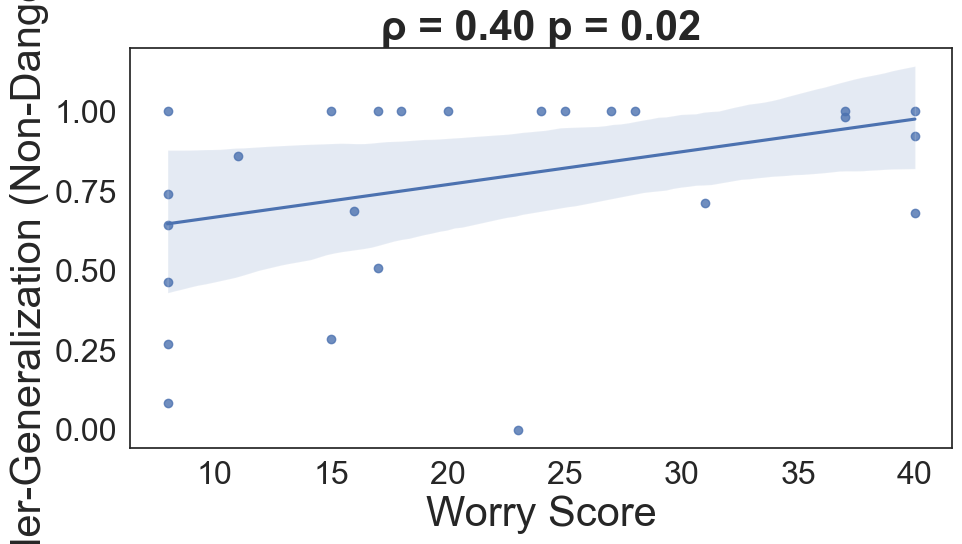

In [3]:
#!/usr/bin/env python3
"""
combined_analysis.py
────────────────────
A comprehensive analysis script that integrates dangerous vehicle generalization,
planning optimality, and their relationships with anxiety measures.

This script performs the following analyses:
1.  Calculates mistakes related to a "dangerous" vehicle vs. other vehicles.
2.  Measures "under-generalization" (propensity to avoid actions similar to the dangerous vehicle's).
3.  Calculates "planning accuracy" by comparing participant plans to an optimal route.
4.  Performs t-tests on mistake counts and planning accuracy against chance.
5.  Filters out participants with low planning accuracy AND participants who hit any obstacles.
6.  Tests for correlations between:
    - Under-generalization (non-dangerous trials) and Worry scores.

NOTE: This version filters out participants with a mean planning accuracy below 1%
AND any participants who encountered obstacles in Phase 1.
"""
import json
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import logit
from collections import defaultdict
import ast # Added for safe string-to-list conversion

sns.set_theme(style="white", font_scale=2.1)

# ─── Configuration ────────────────────────────────────────────────────────
CSV_PATH = Path("game_trials_export.csv")
SUBJECT_COL = "prolificId"
PHASE_COL = "phase"
VEHICLE_COL = "vehicleType"
PLAN_COL = "plan_seq"
HITS_COL = "hits" # Added for clarity
DANGEROUS_COL = "dangerous_vehicle"
OPTIMAL_ROUTE_COL = "optimalRoute"
WORRY_COL = "worry"
SOMA_COL = "somatic_anxiety"
PARTICIPANT_ID_COL="participant_id"
# --- Mappings & Constants ---
VALID_KEYS = {
    "small_car": ["a", "d", "w", "x"],
    "big_car": ["s", "f", "e", "c"],
    "medium_car": ["a", "s", "d", "f", "w", "e", "x", "c"],
    "small_sedan": ["g", "j", "y", "n"],
    "big_sedan": ["h", "k", "u", "m"],
    "medium_sedan": ["g", "h", "j", "k", "y", "u", "n", "m"],
}
BIG_SMALL_SET = {"small_car", "big_car", "small_sedan", "big_sedan"}
KEY_TO_CATEGORY = defaultdict(list)
for category, keys in VALID_KEYS.items():
    for key in keys:
        KEY_TO_CATEGORY[key].append(category)

UNIVERSAL_KEY_MAP = {
    'w': 'up', 'e': 'up', 'y': 'up', 'u': 'up',
    'x': 'down', 'c': 'down', 'n': 'down', 'm': 'down',
    'a': 'left', 's': 'left', 'g': 'left', 'h': 'left',
    'd': 'right', 'f': 'right', 'j': 'right', 'k': 'right',
}
CHANCE_PERFORMANCE = 1 / (4**4)


# ─── Data Processing & Analysis Functions ─────────────────────────────────

def parse_optimal_route(json_str):
    try:
        return [direction.lower() for direction in json.loads(json_str)]
    except (json.JSONDecodeError, TypeError):
        return []

def calculate_exact_match_accuracy(row):
    optimal_dirs = parse_optimal_route(row[OPTIMAL_ROUTE_COL])
    plan_keys = str(row[PLAN_COL]) if pd.notna(row[PLAN_COL]) else ""
    if not optimal_dirs or not plan_keys:
        return np.nan
    participant_dirs = [UNIVERSAL_KEY_MAP.get(key, 'unknown') for key in plan_keys.lower()]
    return 1.0 if participant_dirs == optimal_dirs else 0.0

def parse_plan(seq):
    if not isinstance(seq, str):
        return []
    return [ch.lower() for ch in seq if ch.isalpha()]

def analyse_subj(df_subj):
    if df_subj.empty:
        return {}
    first_row = df_subj.iloc[0]
    participant_id = first_row[PARTICIPANT_ID_COL]
    dangerous_vehicle = first_row[DANGEROUS_COL]
    danger_keys = set(VALID_KEYS.get(dangerous_vehicle, []))
    dangerous_vehicle_mismatches = 0
    dangerous_vehicle_total_items = 0
    nondangerous_invalid_away_from_danger = 0
    nondangerous_invalid_total = 0
    for _, row in df_subj.iterrows():
        plan_items = parse_plan(row[PLAN_COL])
        current_vehicle = row[VEHICLE_COL]
        if current_vehicle == dangerous_vehicle:
            for item in plan_items:
                if item not in danger_keys:
                    dangerous_vehicle_mismatches += 1
            dangerous_vehicle_total_items += len(plan_items)
        else:
            valid_keys_for_row = set(VALID_KEYS.get(current_vehicle, []))
            for item in plan_items:
                if item not in valid_keys_for_row:
                    nondangerous_invalid_total += 1
                    if item not in danger_keys:
                        nondangerous_invalid_away_from_danger += 1
    prop_mismatch_dangerous = (dangerous_vehicle_mismatches / dangerous_vehicle_total_items) if dangerous_vehicle_total_items > 0 else 0
    prop_away_nondangerous_invalid = (nondangerous_invalid_away_from_danger / nondangerous_invalid_total) if nondangerous_invalid_total > 0 else 0
    total_mistakes = dangerous_vehicle_mismatches + nondangerous_invalid_total
    return {
        PARTICIPANT_ID_COL: participant_id,
        WORRY_COL: first_row[WORRY_COL],
        SOMA_COL: first_row[SOMA_COL],
        'total_mistakes': total_mistakes,
        "prop_toward": prop_mismatch_dangerous,
        "prop_toward_nd": prop_away_nondangerous_invalid
    }

def create_mistake_df(df):
    mistake_records = []
    for _, row in df.iterrows():
        participant = row[PARTICIPANT_ID_COL]
        actual_vehicle = row[VEHICLE_COL]
        plan = parse_plan(row[PLAN_COL])
        valid_keys_for_vehicle = set(VALID_KEYS[actual_vehicle])
        for key_press in plan:
            if key_press not in valid_keys_for_vehicle:
                guessed_categories = KEY_TO_CATEGORY.get(key_press, ["unknown"])
                for guessed_cat in guessed_categories:
                    if guessed_cat != actual_vehicle:
                        mistake_records.append({
                            'participant': participant,
                            PARTICIPANT_ID_COL: participant,
                            'actual_vehicle': actual_vehicle,
                            'guessed_category': guessed_cat,
                        })
    return pd.DataFrame(mistake_records)

def create_key_press_df(df):
    records = []
    for _, row in df.iterrows():
        participant_id = row[PARTICIPANT_ID_COL]
        plan_keys = parse_plan(row[PLAN_COL])
        for key in plan_keys:
            chosen_categories = KEY_TO_CATEGORY.get(key)
            if chosen_categories:
                for category in chosen_categories:
                    records.append({
                        'participant': participant_id,
                        'category_chosen': category
                    })
    return pd.DataFrame(records)

def analyze_valid_key_usage_per_subject(subject_df):
    subject_df[PLAN_COL] = subject_df[PLAN_COL].astype(str)
    def count_valid_keys(row):
        plan = row[PLAN_COL]
        vehicle_type = row[VEHICLE_COL]
        allowed_keys = set(VALID_KEYS.get(vehicle_type, []))
        if not allowed_keys:
            return 0
        return sum(1 for key in plan if key in allowed_keys)
    subject_df['valid_key_usage'] = subject_df.apply(count_valid_keys, axis=1)
    dangerous_vehicle = subject_df[DANGEROUS_COL].iloc[0]
    participant_id = subject_df[PARTICIPANT_ID_COL].iloc[0]
    worry_score = subject_df[WORRY_COL].iloc[0]
    dangerous_trials = subject_df[subject_df[VEHICLE_COL] == dangerous_vehicle]
    nondangerous_trials = subject_df[subject_df[VEHICLE_COL] != dangerous_vehicle]
    avg_usage_dangerous = dangerous_trials['valid_key_usage'].mean() if not dangerous_trials.empty else np.nan
    print(avg_usage_dangerous)
    avg_usage_nondangerous = nondangerous_trials['valid_key_usage'].mean() if not nondangerous_trials.empty else np.nan
    print(avg_usage_nondangerous)
    usage_difference = avg_usage_dangerous - avg_usage_nondangerous
    return {
        PARTICIPANT_ID_COL: participant_id,
        WORRY_COL: worry_score,
        'valid_key_usage_difference': usage_difference
    }

# ─── Obstacle Analysis Function ──────────────────────────────────────

def find_obstacle_and_total_hits(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyzes a DataFrame to count "obstacle" occurrences and total items
    in the 'hits' column for each trial, robustly handling string-formatted lists.

    Args:
        df: A pandas DataFrame with 'phase' and 'hits' columns.

    Returns:
        The DataFrame with new integer columns 'obstacle_count' and 'total_hits_items'.
    """
    def parse_list_string(s):
        """Safely parse a string representation of a list."""
        if isinstance(s, list):
            return s
        try:
            return ast.literal_eval(s)
        except (ValueError, SyntaxError, TypeError):
            return []

    if HITS_COL not in df.columns:
        print(f"Warning: Column '{HITS_COL}' not found. Cannot perform obstacle analysis.")
        df['obstacle_count'] = 0
        df['total_hits_items'] = 0
        return df

    df['obstacle_count'] = 0
    df['total_hits_items'] = 0
    
    phase1_mask = df[PHASE_COL] == 1
    if not phase1_mask.any():
        return df

    parsed_hits = df.loc[phase1_mask, HITS_COL].apply(parse_list_string)
    
    df.loc[phase1_mask, 'obstacle_count'] = parsed_hits.apply(lambda hit_list: hit_list.count('obstacle'))
    df.loc[phase1_mask, 'total_hits_items'] = parsed_hits.apply(len)

    return df


# ─── Plotting Functions ───────────────────────────────────────────────────

def plot_correlation(df, x_col, y_col, x_label, y_label, title, filename):
    print(f"\n--- Plotting Correlation: {title} ---")
    sub_df = df[[x_col, y_col]].dropna()
    if len(sub_df) < 3:
        print(f"Not enough data to plot {title}.")
        return
    spearman_corr, spearman_p = stats.spearmanr(sub_df[x_col], sub_df[y_col])
    plt.figure(figsize=(10, 6))
    sns.regplot(data=sub_df, x=x_col, y=y_col, robust=True)
    plt.xlabel(x_label, fontsize=30)
    plt.ylabel(y_label, fontsize=30)
    annotation = f"ρ = {spearman_corr:.2f} p = {spearman_p/2.0:.2f}"
    plt.title(annotation, fontsize=30, weight='bold')
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"✅ Correlation plot saved to '{filename}'")

# ─── Main Execution ───────────────────────────────────────────────────────

def main():
    # === 1. Load and Prepare Data ===
    if not CSV_PATH.exists():
        sys.exit(f"Error: Data file not found at '{CSV_PATH}'")
    print(f"Loading data from '{CSV_PATH}'...")
    df = pd.read_csv(CSV_PATH)
    df_phase1=df[df[PHASE_COL] ==1].copy() # Use .copy() to avoid SettingWithCopyWarning
    df_phase1['participant_id'] = df_phase1['prolificId']

    df_phase2 = df[df[PHASE_COL] ==2].copy()
    print(f"Filtered for Phase 2, retaining {len(df_phase2)} trials.")

    # --- Simplify Participant IDs ---
    unique_ids = df_phase2[SUBJECT_COL].unique()
    id_map = {old_id: new_id for new_id, old_id in enumerate(unique_ids, 1)}
    # Apply to both phase 1 and phase 2 to ensure alignment
    df_phase1[PARTICIPANT_ID_COL] = df_phase1[SUBJECT_COL].map(id_map)
    df_phase2[PARTICIPANT_ID_COL] = df_phase2[SUBJECT_COL].map(id_map)
    df_phase1.dropna(subset=[PARTICIPANT_ID_COL], inplace=True) # Drop phase 1 subjects not in phase 2
    print(f"Simplified {len(unique_ids)} Prolific IDs to simple integer IDs.")
    
    # === 2. Initial Filtering & Analysis (Pre-Obstacle Check) ===
    print("\n--- Performing Planning Optimality Analysis ---")
    df_phase2['exact_match_accuracy'] = df_phase2.apply(calculate_exact_match_accuracy, axis=1)
    accuracy_df = df_phase2.groupby(PARTICIPANT_ID_COL)[['exact_match_accuracy']].mean().reset_index()

    print("\n--- Performing Dangerous Vehicle & Generalization Analysis ---")
    records = [analyse_subj(grp) for _, grp in df_phase2.groupby(PARTICIPANT_ID_COL, as_index=False)]
    summary_df = pd.DataFrame(records)

    final_summary_df = pd.merge(summary_df, accuracy_df, on=PARTICIPANT_ID_COL, suffixes=('_gen', '_acc'))
    
    # === 3. Obstacle Analysis & Filtering ===
    print("\n--- Obstacle Hit Analysis (Phase 1) ---")
    df_phase1_analyzed = find_obstacle_and_total_hits(df_phase1)
    
    obstacle_summary_df = df_phase1_analyzed.groupby(PARTICIPANT_ID_COL).agg(
        obstacle_count=('obstacle_count', 'sum')
    ).reset_index()
    
    final_summary_df = pd.merge(final_summary_df, obstacle_summary_df, on=PARTICIPANT_ID_COL, how='left')
    final_summary_df['obstacle_count'] = final_summary_df['obstacle_count'].fillna(0).astype(int)

    # --- ❗ NEW: Filter subjects who hit ANY obstacles ---
    subjects_with_obstacles = final_summary_df[final_summary_df['obstacle_count'] > 0]
    
    if not subjects_with_obstacles.empty:
        subjects_to_remove_obstacles = subjects_with_obstacles[PARTICIPANT_ID_COL].tolist()
        print(f"\n--- Removing {len(subjects_to_remove_obstacles)} subjects who encountered obstacles ---")
        print(f"Removing participants: {subjects_to_remove_obstacles}")

        final_summary_df = final_summary_df[~final_summary_df[PARTICIPANT_ID_COL].isin(subjects_to_remove_obstacles)].copy()
        print(f"{len(final_summary_df)} subjects remaining for final analysis.")
    else:
        print("\n--- No subjects encountered obstacles. No subjects removed. ---")
    
    # === 4. Final Analyses on Filtered Data ===

    # --- T-Test on accuracy ---
    t_stat, p_val = stats.ttest_1samp(final_summary_df['exact_match_accuracy'].dropna(), CHANCE_PERFORMANCE, alternative='greater')
    mean_acc = final_summary_df['exact_match_accuracy'].mean()
    print(f"\nMean Exact Match Accuracy (of final participants): {mean_acc:.2%}")
    print(f"One-sample t-test vs chance ({CHANCE_PERFORMANCE:.2%}): t={t_stat:.2f}, p={p_val:.3g}")

    # --- Correlation between Worry and Under-Generalization (Non-Dangerous Trials) ---
    plot_correlation(df=final_summary_df,
                     x_col=WORRY_COL,
                     y_col='prop_toward_nd',
                     x_label='Worry Score',
                     y_label='Under-Generalization (Non-Dangerous)',
                     title='Worry vs. Under-Generalization',
                     filename='correlation_worry_vs_undergeneralization_nd_no_obstacles.png')


if __name__ == "__main__":
    main()



Loading data from 'game_trials_export.csv'...
Filtered for Phase 2, retaining 720 trials.
Simplified 30 Prolific IDs to simple integer IDs.

--- Performing Planning Optimality Analysis ---

--- Keyset-based Category Coverage Filter ---
Participants before: 30
Participants after:  17
Removed (< 4 categories covered by pressed keys): 13

--- Performing Dangerous Vehicle & Generalization Analysis ---

--- Obstacle Hit Analysis (Phase 1) ---

--- Removing 3 subjects who encountered obstacles ---
Removing participants: [13, 22, 26]
14 subjects remaining for final analysis.

Mean Exact Match Accuracy (of final participants): 59.77%
One-sample t-test vs chance (0.39%): t=6.73, p=6.99e-06

--- Plotting Correlation: Worry vs. Under-Generalization ---
✅ Correlation plot saved to 'correlation_worry_vs_undergeneralization_nd_no_obstacles.png'


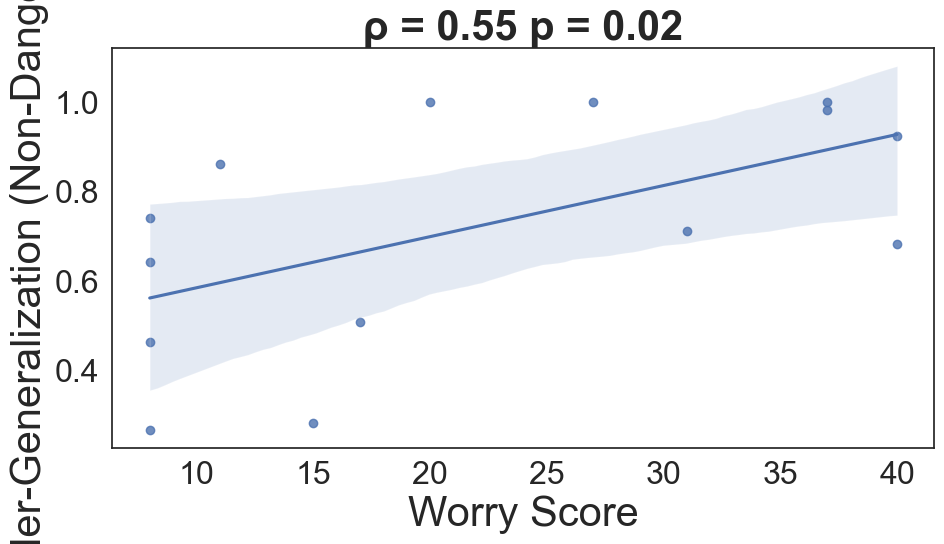

In [4]:
#!/usr/bin/env python3
"""
combined_analysis.py
────────────────────
A comprehensive analysis script that integrates dangerous vehicle generalization,
planning optimality, and their relationships with anxiety measures.

This script performs the following analyses:
1.  Calculates mistakes related to a "dangerous" vehicle vs. other vehicles.
2.  Measures "under-generalization" (propensity to avoid actions similar to the dangerous vehicle's).
3.  Calculates "planning accuracy" by comparing participant plans to an optimal route.
4.  Performs t-tests on mistake counts and planning accuracy against chance.
5.  Filters out participants with low planning accuracy AND participants who hit any obstacles.
6.  Tests for correlations between:
    - Under-generalization (non-dangerous trials) and Worry scores.

NOTE: This version filters out participants with a mean planning accuracy below 1%
AND any participants who encountered obstacles in Phase 1.
"""
import json
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import logit
from collections import defaultdict
import ast # Added for safe string-to-list conversion

sns.set_theme(style="white", font_scale=2.1)

# ─── Configuration ────────────────────────────────────────────────────────
CSV_PATH = Path("game_trials_export.csv")
SUBJECT_COL = "prolificId"
PHASE_COL = "phase"
VEHICLE_COL = "vehicleType"
PLAN_COL = "plan_seq"
HITS_COL = "hits" # Added for clarity
DANGEROUS_COL = "dangerous_vehicle"
OPTIMAL_ROUTE_COL = "optimalRoute"
WORRY_COL = "worry"
SOMA_COL = "somatic_anxiety"
PARTICIPANT_ID_COL="participant_id"
# --- Mappings & Constants ---
VALID_KEYS = {
    "small_car": ["a", "d", "w", "x"],
    "big_car": ["s", "f", "e", "c"],
    "medium_car": ["a", "s", "d", "f", "w", "e", "x", "c"],
    "small_sedan": ["g", "j", "y", "n"],
    "big_sedan": ["h", "k", "u", "m"],
    "medium_sedan": ["g", "h", "j", "k", "y", "u", "n", "m"],
}
BIG_SMALL_SET = {"small_car", "big_car", "small_sedan", "big_sedan"}
KEY_TO_CATEGORY = defaultdict(list)
for category, keys in VALID_KEYS.items():
    for key in keys:
        KEY_TO_CATEGORY[key].append(category)

UNIVERSAL_KEY_MAP = {
    'w': 'up', 'e': 'up', 'y': 'up', 'u': 'up',
    'x': 'down', 'c': 'down', 'n': 'down', 'm': 'down',
    'a': 'left', 's': 'left', 'g': 'left', 'h': 'left',
    'd': 'right', 'f': 'right', 'j': 'right', 'k': 'right',
}
CHANCE_PERFORMANCE = 1 / (4**4)


# ─── Data Processing & Analysis Functions ─────────────────────────────────

def parse_optimal_route(json_str):
    try:
        return [direction.lower() for direction in json.loads(json_str)]
    except (json.JSONDecodeError, TypeError):
        return []

def calculate_exact_match_accuracy(row):
    optimal_dirs = parse_optimal_route(row[OPTIMAL_ROUTE_COL])
    plan_keys = str(row[PLAN_COL]) if pd.notna(row[PLAN_COL]) else ""
    if not optimal_dirs or not plan_keys:
        return np.nan
    participant_dirs = [UNIVERSAL_KEY_MAP.get(key, 'unknown') for key in plan_keys.lower()]
    return 1.0 if participant_dirs == optimal_dirs else 0.0

def parse_plan(seq):
    if not isinstance(seq, str):
        return []
    return [ch.lower() for ch in seq if ch.isalpha()]

def analyse_subj(df_subj):
    if df_subj.empty:
        return {}
    first_row = df_subj.iloc[0]
    participant_id = first_row[PARTICIPANT_ID_COL]
    dangerous_vehicle = first_row[DANGEROUS_COL]
    danger_keys = set(VALID_KEYS.get(dangerous_vehicle, []))
    dangerous_vehicle_mismatches = 0
    dangerous_vehicle_total_items = 0
    nondangerous_invalid_away_from_danger = 0
    nondangerous_invalid_total = 0
    for _, row in df_subj.iterrows():
        plan_items = parse_plan(row[PLAN_COL])
        current_vehicle = row[VEHICLE_COL]
        if current_vehicle == dangerous_vehicle:
            for item in plan_items:
                if item not in danger_keys:
                    dangerous_vehicle_mismatches += 1
            dangerous_vehicle_total_items += len(plan_items)
        else:
            valid_keys_for_row = set(VALID_KEYS.get(current_vehicle, []))
            for item in plan_items:
                if item not in valid_keys_for_row:
                    nondangerous_invalid_total += 1
                    if item not in danger_keys:
                        nondangerous_invalid_away_from_danger += 1
    prop_mismatch_dangerous = (dangerous_vehicle_mismatches / dangerous_vehicle_total_items) if dangerous_vehicle_total_items > 0 else 0
    prop_away_nondangerous_invalid = (nondangerous_invalid_away_from_danger / nondangerous_invalid_total) if nondangerous_invalid_total > 0 else 0
    total_mistakes = dangerous_vehicle_mismatches + nondangerous_invalid_total
    return {
        PARTICIPANT_ID_COL: participant_id,
        WORRY_COL: first_row[WORRY_COL],
        SOMA_COL: first_row[SOMA_COL],
        'total_mistakes': total_mistakes,
        "prop_toward": prop_mismatch_dangerous,
        "prop_toward_nd": prop_away_nondangerous_invalid
    }

def create_mistake_df(df):
    mistake_records = []
    for _, row in df.iterrows():
        participant = row[PARTICIPANT_ID_COL]
        actual_vehicle = row[VEHICLE_COL]
        plan = parse_plan(row[PLAN_COL])
        valid_keys_for_vehicle = set(VALID_KEYS[actual_vehicle])
        for key_press in plan:
            if key_press not in valid_keys_for_vehicle:
                guessed_categories = KEY_TO_CATEGORY.get(key_press, ["unknown"])
                for guessed_cat in guessed_categories:
                    if guessed_cat != actual_vehicle:
                        mistake_records.append({
                            'participant': participant,
                            PARTICIPANT_ID_COL: participant,
                            'actual_vehicle': actual_vehicle,
                            'guessed_category': guessed_cat,
                        })
    return pd.DataFrame(mistake_records)

def create_key_press_df(df):
    records = []
    for _, row in df.iterrows():
        participant_id = row[PARTICIPANT_ID_COL]
        plan_keys = parse_plan(row[PLAN_COL])
        for key in plan_keys:
            chosen_categories = KEY_TO_CATEGORY.get(key)
            if chosen_categories:
                for category in chosen_categories:
                    records.append({
                        'participant': participant_id,
                        'category_chosen': category
                    })
    return pd.DataFrame(records)

def analyze_valid_key_usage_per_subject(subject_df):
    subject_df[PLAN_COL] = subject_df[PLAN_COL].astype(str)
    def count_valid_keys(row):
        plan = row[PLAN_COL]
        vehicle_type = row[VEHICLE_COL]
        allowed_keys = set(VALID_KEYS.get(vehicle_type, []))
        if not allowed_keys:
            return 0
        return sum(1 for key in plan if key in allowed_keys)
    subject_df['valid_key_usage'] = subject_df.apply(count_valid_keys, axis=1)
    dangerous_vehicle = subject_df[DANGEROUS_COL].iloc[0]
    participant_id = subject_df[PARTICIPANT_ID_COL].iloc[0]
    worry_score = subject_df[WORRY_COL].iloc[0]
    dangerous_trials = subject_df[subject_df[VEHICLE_COL] == dangerous_vehicle]
    nondangerous_trials = subject_df[subject_df[VEHICLE_COL] != dangerous_vehicle]
    avg_usage_dangerous = dangerous_trials['valid_key_usage'].mean() if not dangerous_trials.empty else np.nan
    avg_usage_nondangerous = nondangerous_trials['valid_key_usage'].mean() if not nondangerous_trials.empty else np.nan
    usage_difference = avg_usage_dangerous - avg_usage_nondangerous
    return {
        PARTICIPANT_ID_COL: participant_id,
        WORRY_COL: worry_score,
        'valid_key_usage_difference': usage_difference
    }

# ─── Obstacle Analysis Function ──────────────────────────────────────

def find_obstacle_and_total_hits(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyzes a DataFrame to count "obstacle" occurrences and total items
    in the 'hits' column for each trial, robustly handling string-formatted lists.

    Args:
        df: A pandas DataFrame with 'phase' and 'hits' columns.

    Returns:
        The DataFrame with new integer columns 'obstacle_count' and 'total_hits_items'.
    """
    def parse_list_string(s):
        """Safely parse a string representation of a list."""
        if isinstance(s, list):
            return s
        try:
            return ast.literal_eval(s)
        except (ValueError, SyntaxError, TypeError):
            return []

    if HITS_COL not in df.columns:
        print(f"Warning: Column '{HITS_COL}' not found. Cannot perform obstacle analysis.")
        df['obstacle_count'] = 0
        df['total_hits_items'] = 0
        return df

    df['obstacle_count'] = 0
    df['total_hits_items'] = 0
    
    phase1_mask = df[PHASE_COL] == 1
    if not phase1_mask.any():
        return df

    parsed_hits = df.loc[phase1_mask, HITS_COL].apply(parse_list_string)
    
    df.loc[phase1_mask, 'obstacle_count'] = parsed_hits.apply(lambda hit_list: hit_list.count('obstacle'))
    df.loc[phase1_mask, 'total_hits_items'] = parsed_hits.apply(len)

    return df


# ─── Plotting Functions ───────────────────────────────────────────────────

def plot_correlation(df, x_col, y_col, x_label, y_label, title, filename):
    print(f"\n--- Plotting Correlation: {title} ---")
    sub_df = df[[x_col, y_col]].dropna()
    if len(sub_df) < 3:
        print(f"Not enough data to plot {title}.")
        return
    spearman_corr, spearman_p = stats.spearmanr(sub_df[x_col], sub_df[y_col])
    plt.figure(figsize=(10, 6))
    sns.regplot(data=sub_df, x=x_col, y=y_col, robust=True)
    plt.xlabel(x_label, fontsize=30)
    plt.ylabel(y_label, fontsize=30)
    annotation = f"ρ = {spearman_corr:.2f} p = {spearman_p/2.0:.2f}"
    plt.title(annotation, fontsize=30, weight='bold')
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"✅ Correlation plot saved to '{filename}'")

# ─── Main Execution ───────────────────────────────────────────────────────

def main():
    # === 1. Load and Prepare Data ===
    if not CSV_PATH.exists():
        sys.exit(f"Error: Data file not found at '{CSV_PATH}'")
    print(f"Loading data from '{CSV_PATH}'...")
    df = pd.read_csv(CSV_PATH)
    df_phase1=df[df[PHASE_COL] ==1].copy() # Use .copy() to avoid SettingWithCopyWarning
    df_phase1['participant_id'] = df_phase1['prolificId']

    df_phase2 = df[df[PHASE_COL] ==2].copy()
    print(f"Filtered for Phase 2, retaining {len(df_phase2)} trials.")

    # --- Simplify Participant IDs ---
    unique_ids = df_phase2[SUBJECT_COL].unique()
    id_map = {old_id: new_id for new_id, old_id in enumerate(unique_ids, 1)}
    # Apply to both phase 1 and phase 2 to ensure alignment
    df_phase1[PARTICIPANT_ID_COL] = df_phase1[SUBJECT_COL].map(id_map)
    df_phase2[PARTICIPANT_ID_COL] = df_phase2[SUBJECT_COL].map(id_map)
    df_phase1.dropna(subset=[PARTICIPANT_ID_COL], inplace=True) # Drop phase 1 subjects not in phase 2
    print(f"Simplified {len(unique_ids)} Prolific IDs to simple integer IDs.")
    
    # === 2. Initial Filtering & Analysis (Pre-Obstacle Check) ===
    print("\n--- Performing Planning Optimality Analysis ---")
    df_phase2['exact_match_accuracy'] = df_phase2.apply(calculate_exact_match_accuracy, axis=1)
    accuracy_df = df_phase2.groupby(PARTICIPANT_ID_COL)[['exact_match_accuracy']].mean().reset_index()

        # --- End of new step ---
    df_phase2, key_coverage_summary = filter_subjects_by_key_coverage(df_phase2, min_categories=4)
    remaining_ids = set(df_phase2[PARTICIPANT_ID_COL].unique())
    df_phase1 = df_phase1[df_phase1[PARTICIPANT_ID_COL].isin(remaining_ids)].copy()


    print("\n--- Performing Dangerous Vehicle & Generalization Analysis ---")
    records = [analyse_subj(grp) for _, grp in df_phase2.groupby(PARTICIPANT_ID_COL, as_index=False)]
    summary_df = pd.DataFrame(records)

    final_summary_df = pd.merge(summary_df, accuracy_df, on=PARTICIPANT_ID_COL, suffixes=('_gen', '_acc'))
    
    # === 3. Obstacle Analysis & Filtering ===
    print("\n--- Obstacle Hit Analysis (Phase 1) ---")
    df_phase1_analyzed = find_obstacle_and_total_hits(df_phase1)
    
    obstacle_summary_df = df_phase1_analyzed.groupby(PARTICIPANT_ID_COL).agg(
        obstacle_count=('obstacle_count', 'sum')
    ).reset_index()
    
    final_summary_df = pd.merge(final_summary_df, obstacle_summary_df, on=PARTICIPANT_ID_COL, how='left')
    final_summary_df['obstacle_count'] = final_summary_df['obstacle_count'].fillna(0).astype(int)

    # --- ❗ NEW: Filter subjects who hit ANY obstacles ---
    subjects_with_obstacles = final_summary_df[final_summary_df['obstacle_count'] > 0]
    
    if not subjects_with_obstacles.empty:
        subjects_to_remove_obstacles = subjects_with_obstacles[PARTICIPANT_ID_COL].tolist()
        print(f"\n--- Removing {len(subjects_to_remove_obstacles)} subjects who encountered obstacles ---")
        print(f"Removing participants: {subjects_to_remove_obstacles}")

        final_summary_df = final_summary_df[~final_summary_df[PARTICIPANT_ID_COL].isin(subjects_to_remove_obstacles)].copy()
        print(f"{len(final_summary_df)} subjects remaining for final analysis.")
    else:
        print("\n--- No subjects encountered obstacles. No subjects removed. ---")
    
    # === 4. Final Analyses on Filtered Data ===

    # --- T-Test on accuracy ---
    t_stat, p_val = stats.ttest_1samp(final_summary_df['exact_match_accuracy'].dropna(), CHANCE_PERFORMANCE, alternative='greater')
    mean_acc = final_summary_df['exact_match_accuracy'].mean()
    print(f"\nMean Exact Match Accuracy (of final participants): {mean_acc:.2%}")
    print(f"One-sample t-test vs chance ({CHANCE_PERFORMANCE:.2%}): t={t_stat:.2f}, p={p_val:.3g}")

    # --- Correlation between Worry and Under-Generalization (Non-Dangerous Trials) ---
    plot_correlation(df=final_summary_df,
                     x_col=WORRY_COL,
                     y_col='prop_toward_nd',
                     x_label='Worry Score',
                     y_label='Under-Generalization (Non-Dangerous)',
                     title='Worry vs. Under-Generalization',
                     filename='correlation_worry_vs_undergeneralization_nd_no_obstacles.png')


if __name__ == "__main__":
    main()

Loading data from 'game_trials_export.csv'...
Filtered for Phase 2, retaining 720 trials.
Simplified 30 Prolific IDs to simple integer IDs.

--- Performing Planning Optimality Analysis ---

--- Removing 2 subjects with planning accuracy < 1% ---
Removing participants: [24, 26]
Removed 2 subjects. 28 subjects remaining for analysis.

--- Keyset-based Category Coverage Filter ---
Participants before: 28
Participants after:  15
Removed (< 4 categories covered by pressed keys): 13

--- Performing Dangerous Vehicle & Generalization Analysis ---
Mean Exact Match Accuracy (of remaining participants): 58.92%
One-sample t-test vs chance (0.39%): t=7.33, p=1.87e-06
    participant_id  worry  somatic_anxiety  total_mistakes  prop_toward  \
0                2     15               10              68     0.666667   
1                3      8               10              56     0.000000   
2                5     40               26              38     1.000000   
3                6     27           

/opt/miniconda3/envs/coding_basic/lib/python3.13/site-packages/statsmodels/robust/robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'


✅ Correlation plot saved to 'correlation_safe_accuracy_vs_prop_toward_s2.png'

--- Analyzing Safe Category Correctness vs. Under-Generalization ---
Results for all Category Correctness:
  - Mean Accuracy in all Contexts: 38.82%
  - Spearman Correlation (Correctness vs. Worry): ρ = 0.066, p = 0.815

--- Plotting Correlation: Category Correctness vs. Worry ---
✅ Correlation plot saved to 'correlation_worry_generalization.png'

--- Plotting Correlation: Under-Generalization vs. accuracy overall ---


/opt/miniconda3/envs/coding_basic/lib/python3.13/site-packages/statsmodels/robust/robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'


✅ Correlation plot saved to 'correlation_under_generalization_vs_accuracy_GENERALIZERS_DANGER_s2.png'

--- Plotting Correlation: Under-Generalization vs. Worry ---


/opt/miniconda3/envs/coding_basic/lib/python3.13/site-packages/statsmodels/robust/robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/opt/miniconda3/envs/coding_basic/lib/python3.13/site-packages/statsmodels/robust/robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/opt/miniconda3/envs/coding_basic/lib/python3.13/site-packages/statsmodels/robust/robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'


✅ Correlation plot saved to 'correlation_under_generalization_vs_worry_GENERALIZERS_DANGER_s2.png'

--- Plotting Correlation: Under-Generalization vs. Worry ---
✅ Correlation plot saved to 'correlation_under_generalization_vs_worry_GENERALIZERS_NONDANGER_s2.png'

--- Performing Valid Key Usage Analysis ---

--- Plotting Correlation: Valid Key Usage Difference vs. Worry ---
✅ Correlation plot saved to 'correlation_valid_key_usage_difference_vs_worry_GENERALIZERS_s2.png'

--- Generating Outlier-Filtered Re-plots ---

--- Plotting Correlation (No Outliers): Under-Generalization vs. Worry (DANGER) ---


/opt/miniconda3/envs/coding_basic/lib/python3.13/site-packages/statsmodels/robust/robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/opt/miniconda3/envs/coding_basic/lib/python3.13/site-packages/statsmodels/robust/robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/opt/miniconda3/envs/coding_basic/lib/python3.13/site-packages/statsmodels/robust/robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/opt/miniconda3/envs/coding_basic/lib/python3.13/site-packages/statsmodels/robust/robust

✅ Re-plotted without outliers to 'correlation_under_generalization_vs_worry_GENERALIZERS_DANGER_s2_no_OL.png'
   Removed 1 outlier(s).

--- Plotting Correlation (No Outliers): Under-Generalization vs. Worry (NONDANGER) ---
✅ Re-plotted without outliers to 'correlation_under_generalization_vs_worry_GENERALIZERS_NONDANGER_s2_no_OL.png'
   Removed 0 outlier(s).


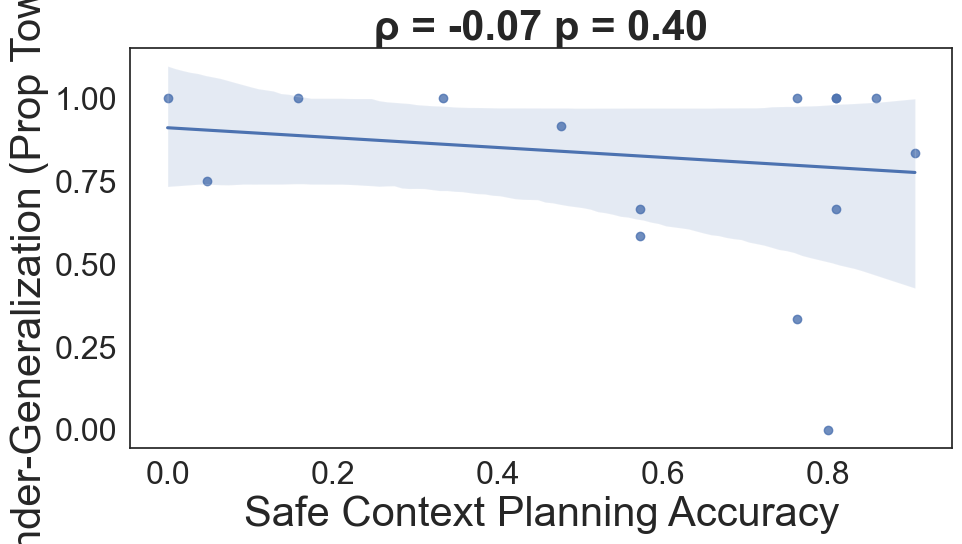

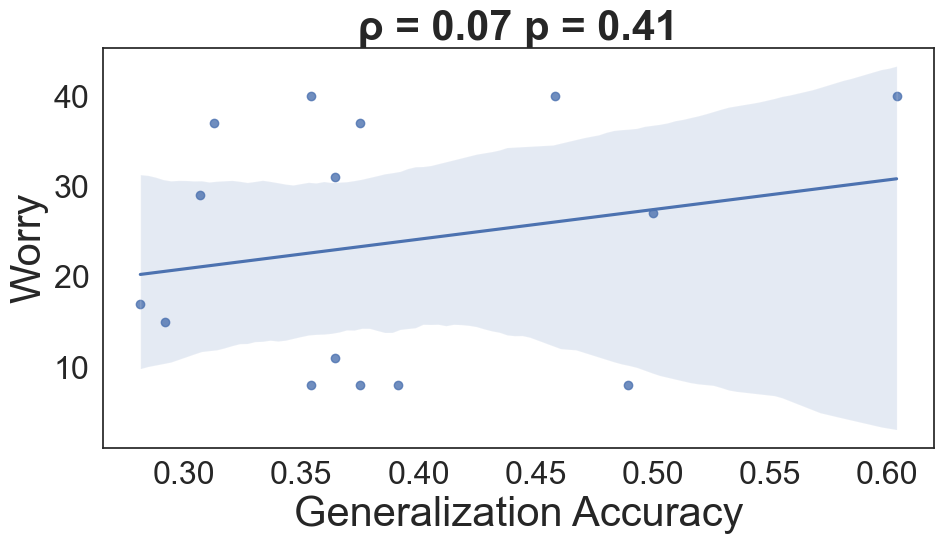

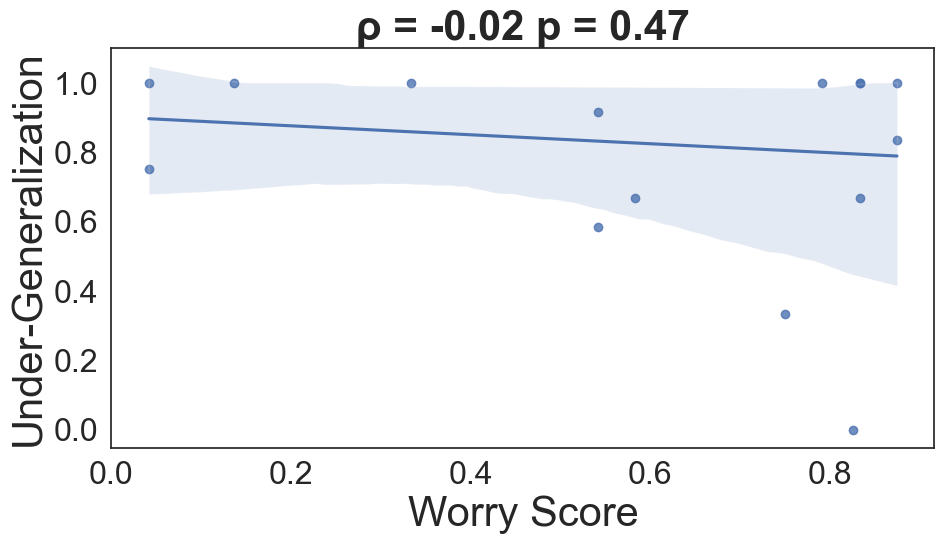

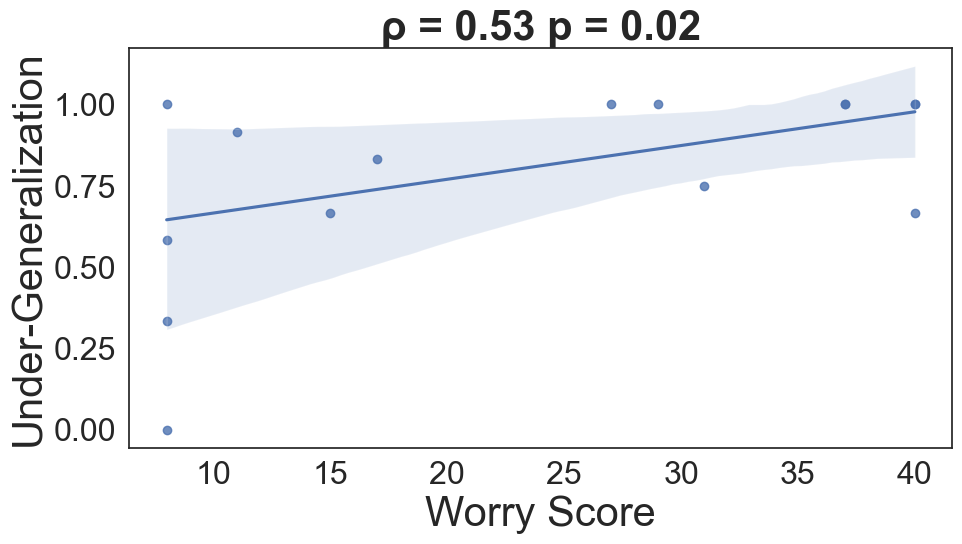

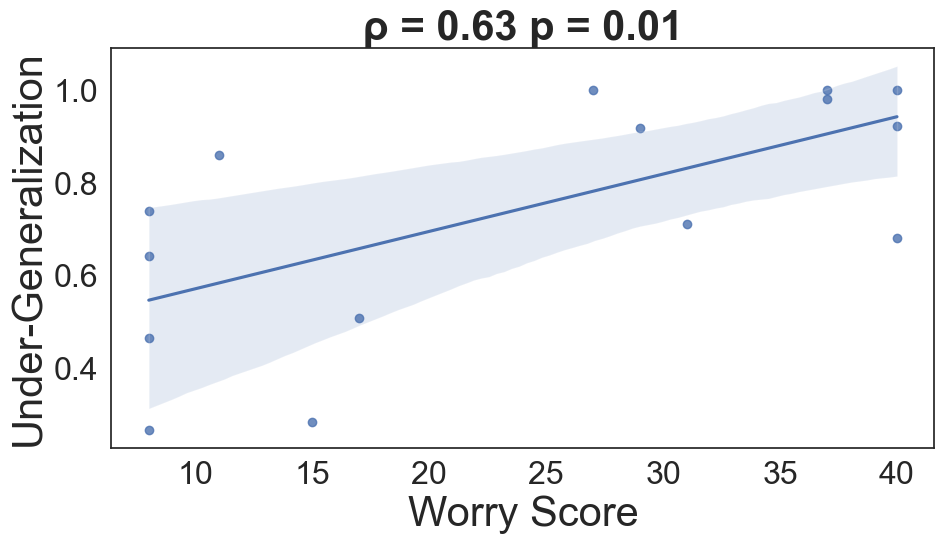

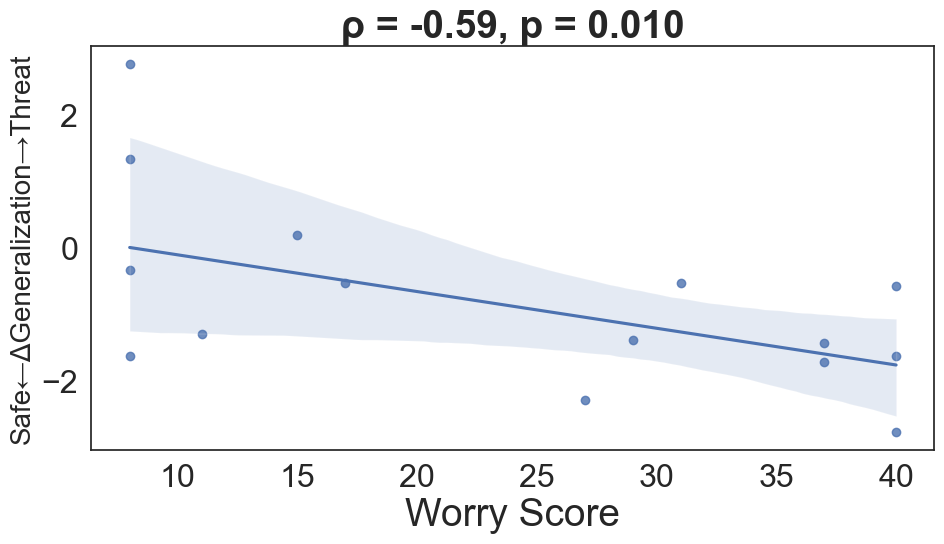

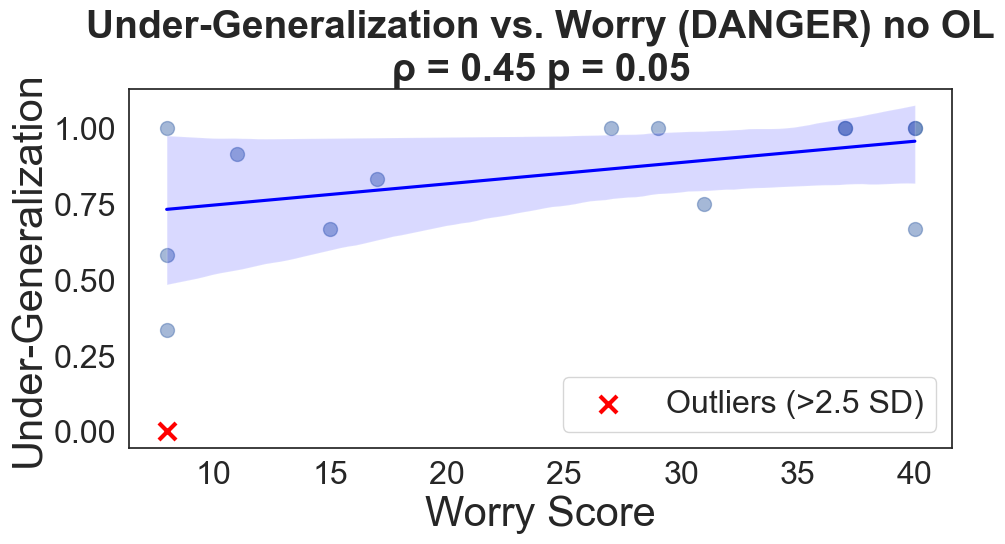

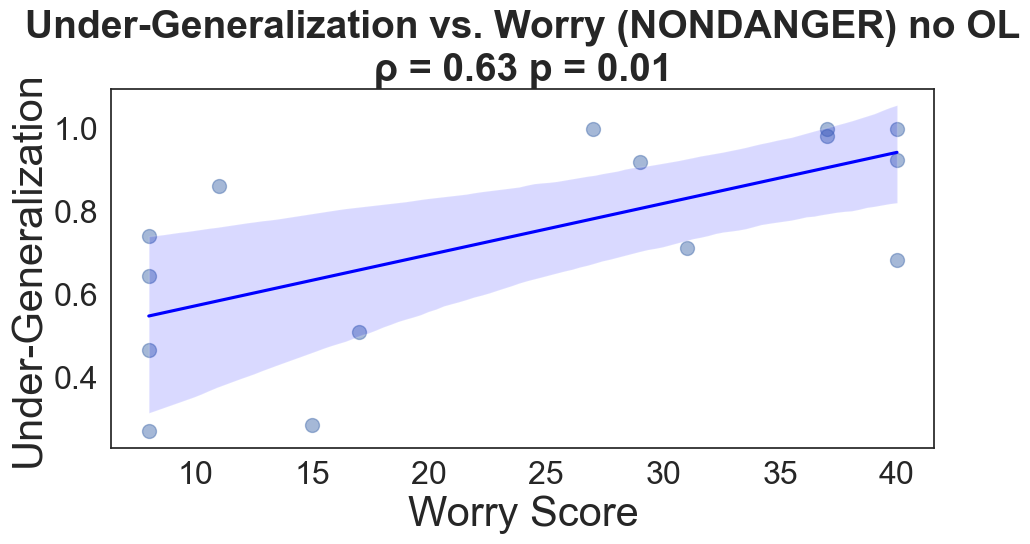

In [3]:
#!/usr/bin/env python3
"""
combined_analysis.py
────────────────────
A comprehensive analysis script that integrates dangerous vehicle generalization,
planning optimality, and their relationships with anxiety measures.

This script performs the following analyses:
1.  Calculates mistakes related to a "dangerous" vehicle vs. other vehicles.
2.  Measures "under-generalization" (propensity to avoid actions similar to the dangerous vehicle's).
3.  Calculates "planning accuracy" by comparing participant plans to an optimal route.
4.  Performs t-tests on mistake counts and planning accuracy against chance.
5.  Visualizes mistake categories, accuracy per vehicle, and overall participant accuracy.
6.  Tests for correlations between:
    - Under-generalization and anxiety (Worry / Somatic Anxiety).
    - Planning accuracy and anxiety.
    - Under-generalization and planning accuracy (NEW).

NOTE: This version filters out participants with a mean planning accuracy below 1%.
"""
import json
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import logit
from collections import defaultdict

sns.set_theme(style="white", font_scale=2.1)

# ─── Configuration ────────────────────────────────────────────────────────
CSV_PATH = Path("game_trials_export.csv")
SUBJECT_COL = "prolificId"
PHASE_COL = "phase"
VEHICLE_COL = "vehicleType"
PLAN_COL = "plan_seq"
DANGEROUS_COL = "dangerous_vehicle"
OPTIMAL_ROUTE_COL = "optimalRoute"
WORRY_COL = "worry"
SOMA_COL = "somatic_anxiety"
PARTICIPANT_ID_COL="participant_id"
# --- Mappings & Constants ---
VALID_KEYS = {
    "small_car": ["a", "d", "w", "x"],
    "big_car": ["s", "f", "e", "c"],
    "medium_car": ["a", "s", "d", "f", "w", "e", "x", "c"],
    "small_sedan": ["g", "j", "y", "n"],
    "big_sedan": ["h", "k", "u", "m"],
    "medium_sedan": ["g", "h", "j", "k", "y", "u", "n", "m"],
}
BIG_SMALL_SET = {"small_car", "big_car", "small_sedan", "big_sedan"}
KEY_TO_CATEGORY = defaultdict(list)
for category, keys in VALID_KEYS.items():
    for key in keys:
        KEY_TO_CATEGORY[key].append(category)

UNIVERSAL_KEY_MAP = {
    'w': 'up', 'e': 'up', 'y': 'up', 'u': 'up',
    'x': 'down', 'c': 'down', 'n': 'down', 'm': 'down',
    'a': 'left', 's': 'left', 'g': 'left', 'h': 'left',
    'd': 'right', 'f': 'right', 'j': 'right', 'k': 'right',
}
CHANCE_PERFORMANCE = 1 / (4**4)

# ─── Helper Functions ─────────────────────────────────────────────────────

def parse_plan(seq):
    if not isinstance(seq, str):
        return []
    return [ch.lower() for ch in seq if ch.isalpha()]

def filter_subjects_by_key_coverage(df, min_categories=4):
    """
    Keep participants who, based on all keys they actually pressed (PLAN_COL),
    'cover' at least `min_categories` distinct categories. A category is counted
    for a participant if ANY of their pressed keys appears in VALID_KEYS[that_category].

    Parameters
    ----------
    df : DataFrame (trial-level; must contain PARTICIPANT_ID_COL and PLAN_COL)
    min_categories : int

    Returns
    -------
    filtered_df : DataFrame
        Original df filtered to participants meeting the coverage criterion.
    coverage_df : DataFrame
        Per-participant coverage summary with the categories covered.
    """
    if df.empty:
        return df, pd.DataFrame(columns=[PARTICIPANT_ID_COL, 'n_categories_by_keys', 'categories_by_keys'])

    coverage_rows = []
    for pid, grp in df.groupby(PARTICIPANT_ID_COL, sort=False):
        # 1) all distinct keys this participant ever pressed
        keys_used = set()
        for seq in grp[PLAN_COL]:
            keys_used.update(parse_plan(seq))

        # 2) union of all categories that accept any of those keys
        cats_covered = set()
        for k in keys_used:
            cats_covered.update(KEY_TO_CATEGORY.get(k, []))  # KEY_TO_CATEGORY built from VALID_KEYS above

        coverage_rows.append({
            PARTICIPANT_ID_COL: pid,
            'n_categories_by_keys': len(cats_covered),
            'categories_by_keys': sorted(cats_covered)
        })

    coverage_df = pd.DataFrame(coverage_rows)

    keep_ids = coverage_df.loc[coverage_df['n_categories_by_keys'] >= min_categories, PARTICIPANT_ID_COL]
    before = df[PARTICIPANT_ID_COL].nunique()
    filtered_df = df[df[PARTICIPANT_ID_COL].isin(keep_ids)].copy()
    after = filtered_df[PARTICIPANT_ID_COL].nunique()

    print("\n--- Keyset-based Category Coverage Filter ---")
    print(f"Participants before: {before}")
    print(f"Participants after:  {after}")
    print(f"Removed (< {min_categories} categories covered by pressed keys): {before - after}")

    if after == 0:
        print("⚠️ All participants removed by keyset coverage filter.")

    return filtered_df, coverage_df

def calculate_all_key_accuracy(grp):
    """
    Calculates the proportion of key presses that belong to the correct 
    category, only in safe (non-threat) trials.
    """
    # Filter for safe trials only
    safe_trials = grp
    
    total_keys_pressed = 0
    correct_category_keys = 0
    
    for _, row in safe_trials.iterrows():
        vehicle = row[VEHICLE_COL]
        plan = parse_plan(row[PLAN_COL])
        valid_set = set(VALID_KEYS.get(vehicle, []))
        
        for key in plan:
            total_keys_pressed += 1
            if key in valid_set:
                correct_category_keys += 1
                
    accuracy = correct_category_keys / total_keys_pressed if total_keys_pressed > 0 else np.nan
    return accuracy
def plot_correlation_no_outliers(df, x_col, y_col, x_label, y_label, title, filename):
    """
    Plots correlation, identifies outliers (> 2.5 SD from mean), 
    marks them with a red X, and replots without them in the regression.
    """
    print(f"\n--- Plotting Correlation (No Outliers): {title} ---")
    sub_df = df[[x_col, y_col]].dropna().copy()
    if len(sub_df) < 3:
        return

    # Define Outliers: > 2.5 SD from mean in either X or Y
    x_mean, x_std = sub_df[x_col].mean(), sub_df[x_col].std()
    y_mean, y_std = sub_df[y_col].mean(), sub_df[y_col].std()
    
    is_outlier = (
        (sub_df[x_col] > x_mean + 2.5 * x_std) | (sub_df[x_col] < x_mean - 2.5 * x_std) |
        (sub_df[y_col] > y_mean + 2.5 * y_std) | (sub_df[y_col] < y_mean - 2.5 * y_std)
    )
    
    clean_df = sub_df[~is_outlier]
    outliers_df = sub_df[is_outlier]
    
    # Calculate stats for clean data only
    rho, p = stats.spearmanr(clean_df[x_col], clean_df[y_col])
    
    plt.figure(figsize=(10, 6))
    
    # 1. Plot the regression and clean points
    sns.regplot(data=clean_df, x=x_col, y=y_col, robust=True, 
                scatter_kws={'alpha':0.5, 's':100}, line_kws={'color':'blue'})
    
    # 2. Overlay outliers with red X
    if not outliers_df.empty:
        plt.scatter(outliers_df[x_col], outliers_df[y_col], 
                    color='red', marker='x', s=150, linewidths=3, label='Outliers (>2.5 SD)')
        plt.legend()

    plt.xlabel(x_label, fontsize=30)
    plt.ylabel(y_label, fontsize=30)
    
    # Update title with "no OL" and new stats
    new_title = f"{title} no OL"
    annotation = f"ρ = {rho:.2f} p = {p/2.0:.2f}"
    plt.title(f"{new_title}\n{annotation}", fontsize=28, weight='bold')
    
    plt.tight_layout()
    plt.savefig(filename.replace(".png", "_no_OL.png"), dpi=300)
    print(f"✅ Re-plotted without outliers to '{filename.replace('.png', '_no_OL.png')}'")
    print(f"   Removed {is_outlier.sum()} outlier(s).")
    
def create_mistake_df(df):
    mistake_records = []
    for _, row in df.iterrows():
        participant = row[PARTICIPANT_ID_COL]
        actual_vehicle = row[VEHICLE_COL]
        plan = parse_plan(row[PLAN_COL])
        valid_keys_for_vehicle = set(VALID_KEYS[actual_vehicle])
        for key_press in plan:
            if key_press not in valid_keys_for_vehicle:
                guessed_categories = KEY_TO_CATEGORY.get(key_press, ["unknown"])
                for guessed_cat in guessed_categories:
                    if guessed_cat != actual_vehicle:
                        mistake_records.append({
                            'participant': participant,
                            PARTICIPANT_ID_COL: participant,
                            'actual_vehicle': actual_vehicle,
                            'guessed_category': guessed_cat,
                        })
    return pd.DataFrame(mistake_records)

def parse_optimal_route(json_str):
    try:
        return [direction.lower() for direction in json.loads(json_str)]
    except (json.JSONDecodeError, TypeError):
        return []

def calculate_exact_match_accuracy(row):
    optimal_dirs = parse_optimal_route(row[OPTIMAL_ROUTE_COL])
    plan_keys = str(row[PLAN_COL]) if pd.notna(row[PLAN_COL]) else ""
    if not optimal_dirs or not plan_keys:
        return np.nan
    participant_dirs = [UNIVERSAL_KEY_MAP.get(key, 'unknown') for key in plan_keys.lower()]
    return 1.0 if participant_dirs == optimal_dirs else 0.0

def exact_match_accuracy_safe(row):
    """
    Calculates exact match accuracy ONLY for safe contexts.
    Returns np.nan if the current vehicle is the dangerous one.
    """
    # If the current vehicle is the dangerous one, return NaN (ignore this trial)
    if row[VEHICLE_COL] == row[DANGEROUS_COL]:
        return np.nan

    # Otherwise, calculate standard accuracy logic
    optimal_dirs = parse_optimal_route(row[OPTIMAL_ROUTE_COL])
    plan_keys = str(row[PLAN_COL]) if pd.notna(row[PLAN_COL]) else ""
    
    if not optimal_dirs or not plan_keys:
        return np.nan

    participant_dirs = [UNIVERSAL_KEY_MAP.get(key, 'unknown') for key in plan_keys.lower()]
    return 1.0 if participant_dirs == optimal_dirs else 0.0

def create_key_press_df(df):
    """
    Transforms trial data into a long-format DataFrame where each row
    represents a single key press and the category it belongs to.
    """
    print("Processing all key presses...")
    records = []
    for _, row in df.iterrows():
        participant_id = row[PARTICIPANT_ID_COL] # Use the simplified ID
        plan_keys = parse_plan(row[PLAN_COL])
        for key in plan_keys:
            chosen_categories = KEY_TO_CATEGORY.get(key)
            if chosen_categories:
                for category in chosen_categories:
                    records.append({
                        'participant': participant_id,
                        'category_chosen': category
                    })
    if not records:
        return pd.DataFrame()
    print(f"Created a dataset with {len(records)} categorized key presses.")
    return pd.DataFrame(records)

# ─── Plotting Functions ───────────────────────────────────────────────────

def plot_guessed_categories(mistake_df, df_original):
    print("\n--- Generating plot for guessed mistake categories per participant ---")
    category_order = ["small_car", "medium_car", "big_car", "small_sedan", "medium_sedan", "big_sedan"]
    pretty_labels = ["Small\nCar", "Medium\nCar", "Big\nCar", "Small\nSedan", "Medium\nSedan", "Big\nSedan"]
    participant_dangerous_vehicles = df_original.drop_duplicates(subset=[PARTICIPANT_ID_COL]).set_index(PARTICIPANT_ID_COL)[DANGEROUS_COL].to_dict()
    all_participants = sorted(df_original[PARTICIPANT_ID_COL].unique())
    if not mistake_df.empty:
        mistake_df['actual_vehicle'] = pd.Categorical(mistake_df['actual_vehicle'], categories=category_order, ordered=True)
        mistake_df['guessed_category'] = pd.Categorical(mistake_df['guessed_category'], categories=category_order, ordered=True)
    g = sns.displot(
        data=mistake_df, x='actual_vehicle', hue='guessed_category', col='participant',
        col_order=all_participants, multiple='stack', col_wrap=4, palette='muted',
        height=5, aspect=1.2, hue_order=category_order, facet_kws={'sharex': False}
    )
    g.fig.suptitle('Mistake Analysis: Guessed Category vs. Actual Category', y=1.03, weight='bold')
    g.set_axis_labels("Actual Vehicle Category", "Mistake Count")
    g.set_titles("Participant: {col_name}")
    g.set_xticklabels(pretty_labels, rotation=0)
    sns.move_legend(g, "center left", bbox_to_anchor=(1, 0.5), title='Guessed Category')
    for ax in g.axes.flatten():
        title = ax.get_title()
        if not title or "Participant: " not in title: continue
        participant_id = title.split("Participant: ")[1]
        dangerous_vehicle = participant_dangerous_vehicles.get(participant_id)
        if dangerous_vehicle:
            try:
                dangerous_idx = category_order.index(dangerous_vehicle)
                tick_labels = ax.get_xticklabels()
                if dangerous_idx < len(tick_labels):
                    tick_labels[dangerous_idx].set_color('red')
                    tick_labels[dangerous_idx].set_fontweight('bold')
            except (ValueError, IndexError):
                print(f"Warning: Could not find dangerous vehicle '{dangerous_vehicle}' for participant {participant_id} in plot.")
    plt.tight_layout(rect=[0, 0, 0.9, 0.97])
    plt.savefig('participant_mistake_categories_s2_after_filtering_generalization.png', dpi=300, bbox_inches='tight')
    print("✅ Participant mistake categories plot saved.")

def plot_correlation(df, x_col, y_col, x_label, y_label, title, filename):
    print(f"\n--- Plotting Correlation: {title} ---")
    sub_df = df[[x_col, y_col]].dropna()
    if len(sub_df) < 3:
        print(f"Not enough data to plot {title}.")
        return
    spearman_corr, spearman_p = stats.spearmanr(sub_df[x_col], sub_df[y_col])
    plt.figure(figsize=(10, 6))
    sns.regplot(data=sub_df, x=x_col, y=y_col, robust=True)
    plt.xlabel(x_label, fontsize=30)
    plt.ylabel(y_label, fontsize=30)
    annotation = f"ρ = {spearman_corr:.2f} p = {spearman_p/2.0:.2f}"
    plt.title(annotation, fontsize=30, weight='bold')
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"✅ Correlation plot saved to '{filename}'")

def plot_key_press_counts(key_press_df, df_original):
    """
    Generates and saves a faceted bar plot of key press counts per category
    for each participant, highlighting the dangerous vehicle.
    """
    print("\n--- Generating plot of key press counts per participant ---")
    if key_press_df.empty:
        print("Warning: No key press data available to plot.")
        return

    category_order = ["small_car", "medium_car", "big_car", "small_sedan", "medium_sedan", "big_sedan"]
    pretty_labels = ["Small\nCar", "Medium\nCar", "Big\nCar", "Small\nSedan", "Medium\nSedan", "Big\nSedan"]
    participant_dangerous_vehicles = df_original.drop_duplicates(
        subset=[PARTICIPANT_ID_COL]
    ).set_index(PARTICIPANT_ID_COL)[DANGEROUS_COL].to_dict()

    g = sns.catplot(
        data=key_press_df, x='category_chosen', col='participant', kind='count',
        col_wrap=4, palette='viridis', sharex=False, order=category_order,
        height=5, aspect=1.2
    )
    g.fig.suptitle('Frequency of Key Presses by Category', y=1.03, font_scale=28, weight='bold')
    g.set_axis_labels("Vehicle Category of Key", "Total Times Chosen")
    g.set_titles("Participant: {col_name}")
    g.set_xticklabels(pretty_labels, rotation=0)

    for ax in g.axes.flatten():
        title = ax.get_title()
        if not title or "Participant: " not in title: continue
        participant_id = title.split("Participant: ")[1]
        dangerous_vehicle = participant_dangerous_vehicles.get(participant_id)
        if dangerous_vehicle:
            try:
                dangerous_idx = category_order.index(dangerous_vehicle)
                tick_labels = ax.get_xticklabels()
                if dangerous_idx < len(tick_labels):
                    tick_labels[dangerous_idx].set_color('red')
                    tick_labels[dangerous_idx].set_fontweight('bold')
            except (ValueError, IndexError):
                print(f"Warning: Could not find dangerous vehicle '{dangerous_vehicle}' for participant {participant_id} in plot.")

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    output_filename = 'participant_key_choice_frequency_s2_after_filtering_generalization.png'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"✅ Plot saved successfully to '{output_filename}'")

# ─── Main Execution ───────────────────────────────────────────────────────

def main():
    # === 1. Load and Prepare Data ===
    if not CSV_PATH.exists():
        sys.exit(f"Error: Data file not found at '{CSV_PATH}'")
    print(f"Loading data from '{CSV_PATH}'...")
    df = pd.read_csv(CSV_PATH)
    df_phase2 = df[df[PHASE_COL] == 2].copy()
    print(f"Filtered for Phase 2, retaining {len(df_phase2)} trials.")

    # --- Simplify Participant IDs ---
    unique_ids = df_phase2[SUBJECT_COL].unique()
    id_map = {old_id: new_id for new_id, old_id in enumerate(unique_ids, 1)}
    df_phase2[PARTICIPANT_ID_COL] = df_phase2[SUBJECT_COL].map(id_map)
    print(f"Simplified {len(unique_ids)} Prolific IDs to simple integer IDs.")
    
    # === 2. Planning Optimality Analysis (Done first for filtering) ===
    print("\n--- Performing Planning Optimality Analysis ---")
    df_phase2['exact_match_accuracy'] = df_phase2.apply(calculate_exact_match_accuracy, axis=1)
    accuracy_df = df_phase2.groupby(PARTICIPANT_ID_COL)[['exact_match_accuracy']].mean().reset_index()

    # --- ❗ NEW: Filter subjects with low planning accuracy ---
    accuracy_threshold = 0.01
    low_accuracy_subjects = accuracy_df[accuracy_df['exact_match_accuracy'] < accuracy_threshold]
    subjects_to_remove = low_accuracy_subjects[PARTICIPANT_ID_COL].tolist()

    if subjects_to_remove:
        print(f"\n--- Removing {len(subjects_to_remove)} subjects with planning accuracy < {accuracy_threshold:.0%} ---")
        print(f"Removing participants: {subjects_to_remove}")
        
        # Filter the main dataframe
        df_phase2 = df_phase2[~df_phase2[PARTICIPANT_ID_COL].isin(subjects_to_remove)].copy()
        
        # Also filter the accuracy_df itself for merging later
        accuracy_df = accuracy_df[~accuracy_df[PARTICIPANT_ID_COL].isin(subjects_to_remove)].copy()
        
        print(f"Removed {len(subjects_to_remove)} subjects. {df_phase2[PARTICIPANT_ID_COL].nunique()} subjects remaining for analysis.")
    else:
        print("\n--- No subjects met the criteria for removal based on low planning accuracy. ---")
    # --- End of new step ---
    df_phase2, key_coverage_summary = filter_subjects_by_key_coverage(df_phase2, min_categories=4)
    remaining_ids = set(df_phase2[PARTICIPANT_ID_COL].unique())
    before = accuracy_df[PARTICIPANT_ID_COL].nunique()
    accuracy_df = accuracy_df[accuracy_df[PARTICIPANT_ID_COL].isin(remaining_ids)].copy()
    after = accuracy_df[PARTICIPANT_ID_COL].nunique()

    # === 3. Dangerous Vehicle & Generalization Analysis (on filtered data) ===
    print("\n--- Performing Dangerous Vehicle & Generalization Analysis ---")
    records = [analyse_subj(grp) for _, grp in df_phase2.groupby(PARTICIPANT_ID_COL, as_index=False)]
    summary_df = pd.DataFrame(records)
    

    # --- T-Test on mistakes ---
    # ttest_res = stats.ttest_rel(summary_df["mistakes_nondangerous"], summary_df["mistakes_dangerous"], nan_policy="omit")
    # print(f"Paired t-test (non vs dangerous): t={ttest_res.statistic:.3f}, p={ttest_res.pvalue:.3g}")

    # --- T-Test on accuracy (on filtered data) ---
    t_stat, p_val = stats.ttest_1samp(accuracy_df['exact_match_accuracy'].dropna(), CHANCE_PERFORMANCE, alternative='greater')
    mean_acc = accuracy_df['exact_match_accuracy'].mean()
    print(f"Mean Exact Match Accuracy (of remaining participants): {mean_acc:.2%}")
    print(f"One-sample t-test vs chance ({CHANCE_PERFORMANCE:.2%}): t={t_stat:.2f}, p={p_val:.3g}")

    # ... [Previous code in main regarding filtering and merging] ...

    # === 4. Merge All Participant-Level Results ===
    final_summary_df = pd.merge(summary_df, accuracy_df, on=PARTICIPANT_ID_COL, suffixes=('_gen', '_acc'))
    print(final_summary_df)

    # ---------------------------------------------------------
    # NEW STEP: Calculate Safe Context Accuracy and Correlate
    # ---------------------------------------------------------
    print("\n--- Calculating Exact Match Accuracy (Safe Contexts Only) ---")
    
    # 1. Apply the new function to the dataframe
    df_phase2['safe_exact_match_accuracy'] = df_phase2.apply(exact_match_accuracy_safe, axis=1)

    # 2. Aggregate per subject (ignoring NaNs, which covers the dangerous trials)
    safe_acc_summary = df_phase2.groupby(PARTICIPANT_ID_COL)['safe_exact_match_accuracy'].mean().reset_index()

    # 3. Merge into the final summary
    final_summary_df = pd.merge(final_summary_df, safe_acc_summary, on=PARTICIPANT_ID_COL)

    # 4. Correlate with prop_toward
    plot_correlation(
        df=final_summary_df,
        x_col='safe_exact_match_accuracy', 
        y_col='prop_toward',
        x_label='Safe Context Planning Accuracy', 
        y_label='Under-Generalization (Prop Toward)',
        title='Safe Planning Accuracy vs. Under-Generalization',
        filename='correlation_safe_accuracy_vs_prop_toward_s2.png'
    )
    # ---------------------------------------------------------

    # === NEW: Safe Generalization Accuracy vs. Under-Generalization ===
    print("\n--- Analyzing Safe Category Correctness vs. Under-Generalization ---")
    
    # 1. Calculate safe key accuracy per participant
    safe_key_acc_records = []
    for pid, grp in df_phase2.groupby(PARTICIPANT_ID_COL):
        acc = calculate_all_key_accuracy(grp)
        safe_key_acc_records.append({PARTICIPANT_ID_COL: pid, 'all_key_accuracy': acc})
    
    safe_key_acc_df = pd.DataFrame(safe_key_acc_records)
    
    # 2. Merge with the final summary (which contains 'prop_toward')
    final_summary_df = pd.merge(final_summary_df, safe_key_acc_df, on=PARTICIPANT_ID_COL)
    
    # 3. Calculate and Print Correlation
    correlation_data = final_summary_df[['all_key_accuracy', 'worry']].dropna()
    if not correlation_data.empty:
        rho, p_val = stats.spearmanr(correlation_data['all_key_accuracy'], correlation_data['worry'])
        
        print(f"Results for all Category Correctness:")
        print(f"  - Mean Accuracy in all Contexts: {correlation_data['all_key_accuracy'].mean():.2%}")
        print(f"  - Spearman Correlation (Correctness vs. Worry): ρ = {rho:.3f}, p = {p_val:.3f}")
        
        # 4. Optional: Plot the result
        plot_correlation(
            df=final_summary_df,
            x_col='all_key_accuracy',
            y_col='worry',
            x_label='Generalization Accuracy',
            y_label='Worry',
            title='Category Correctness vs. Worry',
            filename='correlation_worry_generalization.png'
        )
    else:
        print("Warning: Not enough data to calculate correlation for Safe Category Correctness.")

    # === 5. Correlation Analyses & Plotting (Existing) ===
    # ... [Rest of your existing code] ...

    for anxiety_measure in [WORRY_COL]:
        plot_correlation(df=final_summary_df,
                          x_col='exact_match_accuracy', y_col='prop_toward',
                          x_label=f'{anxiety_measure.title()} Score', y_label='Under-Generalization',
                          title=f'Under-Generalization vs. accuracy overall',
                          filename=f'correlation_under_generalization_vs_accuracy_GENERALIZERS_DANGER_s2.png')
        plot_correlation(df=final_summary_df,
                          x_col=anxiety_measure, y_col='prop_toward',
                          x_label=f'{anxiety_measure.title()} Score', y_label='Under-Generalization',
                          title=f'Under-Generalization vs. {anxiety_measure.title()}',
                          filename=f'correlation_under_generalization_vs_{anxiety_measure}_GENERALIZERS_DANGER_s2.png')

        plot_correlation(df=final_summary_df,
                          x_col=anxiety_measure, y_col='prop_toward_nd',
                          x_label=f'{anxiety_measure.title()} Score', y_label='Under-Generalization',
                          title=f'Under-Generalization vs. {anxiety_measure.title()}',
                          filename=f'correlation_under_generalization_vs_{anxiety_measure}_GENERALIZERS_NONDANGER_s2.png')

        # plot_correlation(df=final_summary_df,
        #                   x_col=anxiety_measure, y_col='exact_match_accuracy',
        #                   x_label=f'{anxiety_measure.title()} Score', y_label='Planning Accuracy',
        #                   title=f'Planning Accuracy vs. {anxiety_measure.title()}',
        #                   filename=f'correlation_accuracy_vs_{anxiety_measure}_s2.png')

    # === 6. Additional Visualizations (on filtered data) ===
    # mistake_df = create_mistake_df(df_phase2)
    # # plot_guessed_categories(mistake_df, df_phase2)

    # key_press_df = create_key_press_df(df_phase2)
    # plot_key_press_counts(key_press_df, df_phase2)

    # === Valid Key Usage Analysis ===
    print("\n--- Performing Valid Key Usage Analysis ---")
    
    # Apply the CORRECTED analysis function to each participant's data
    valid_key_records = [analyze_valid_key_usage_per_subject(grp) for _, grp in df_phase2.groupby(PARTICIPANT_ID_COL)]
    
    # Create a summary DataFrame from the results
    valid_key_summary_df = pd.DataFrame(valid_key_records)

    # Generate the correlation plot using the updated plotting function
    plot_valid_key_usage_difference_vs_worry(
        df=valid_key_summary_df,
        filename='correlation_valid_key_usage_difference_vs_worry_GENERALIZERS_s2.png'
    )

    # === NEW: Re-plot last two correlations without outliers ===
    print("\n--- Generating Outlier-Filtered Re-plots ---")
    
    # 1. Re-plot for Generalizers (Danger)
    plot_correlation_no_outliers(
        df=final_summary_df,
        x_col=WORRY_COL, 
        y_col='prop_toward',
        x_label='Worry Score', 
        y_label='Under-Generalization',
        title='Under-Generalization vs. Worry (DANGER)',
        filename='correlation_under_generalization_vs_worry_GENERALIZERS_DANGER_s2.png'
    )

    # 2. Re-plot for Generalizers (Non-Danger)
    plot_correlation_no_outliers(
        df=final_summary_df,
        x_col=WORRY_COL, 
        y_col='prop_toward_nd',
        x_label='Worry Score', 
        y_label='Under-Generalization',
        title='Under-Generalization vs. Worry (NONDANGER)',
        filename='correlation_under_generalization_vs_worry_GENERALIZERS_NONDANGER_s2.png'
    )

if __name__ == "__main__":
    main()


In [6]:
#!/usr/bin/env python3
"""
logistic_glmm_accuracy_test.py
───────────────────────────────────────────
Logistic GLMM (random intercepts by participant) for binary correctness.

Flow:
1) Load Phase 2, map participant IDs.
2) Drop participants with exact route match < 1%.
3) Build long-format keypress data.
4) Drop participants without ≥1 keypress in ≥4/6 categories.
5) Fit Binomial (logit) GLMM with random intercepts by participant using
   statsmodels' BinomialBayesMixedGLM (fast variational Bayes).
6) Test fixed intercept against logit(0.375); report μ on prob scale and CI.
7) Approximate the population-average (marginal) μ by integrating over RE.

Notes
- MixedLM in statsmodels is linear; for logistic mixed effects use BinomialBayesMixedGLM.
- The fixed intercept is a subject-specific (conditional) parameter. The
  marginal (population-average) mean is E[logit^{-1}(β0 + u)], u~N(0, σ^2).
  We report a Monte Carlo estimate for that as well.

"""



sns.set_theme(style="whitegrid", font_scale=2)

# ─── Configuration ──────────────────────────────────────────────────────────
CSV_PATH = Path("game_trials_export.csv")
SUBJECT_COL = "prolificId"
PHASE_COL = "phase"
VEHICLE_COL = "vehicleType"
PLAN_COL = "plan_seq"
OPTIMAL_ROUTE_COL = "optimalRoute"
PARTICIPANT_ID_COL = "participant_id"

NULL_MU = 0.25  # mean of 0.25 and 0.5

# --- Mappings & Constants ---
VALID_KEYS = {
    "small_car": ["a", "d", "w", "x"], "big_car": ["s", "f", "e", "c"],
    "medium_car": ["a", "s", "d", "f", "w", "e", "x", "c"],
    "small_sedan": ["g", "j", "y", "n"], "big_sedan": ["h", "k", "u", "m"],
    "medium_sedan": ["g", "h", "j", "k", "y", "u", "n", "m"],
}
UNIVERSAL_KEY_MAP = {
    'w': 'up', 'e': 'up', 'y': 'up', 'u': 'up', 'x': 'down', 'c': 'down',
    'n': 'down', 'm': 'down', 'a': 'left', 's': 'left', 'g': 'left',
    'h': 'left', 'd': 'right', 'f': 'right', 'j': 'right', 'k': 'right',
}
higher_order_vehicles=['medium_car', 'medium_sedan']

# ─── Helpers ────────────────────────────────────────────────────────────────
def parse_plan(seq):
    if not isinstance(seq, str):
        return []
    return [ch.lower() for ch in seq if ch.isalpha()]

def parse_optimal_route(json_str):
    try:
        return [direction.lower() for direction in json.loads(json_str)]
    except (json.JSONDecodeError, TypeError):
        return []

def calculate_exact_match_accuracy(row):
    optimal_dirs = parse_optimal_route(row[OPTIMAL_ROUTE_COL])
    plan_keys = str(row[PLAN_COL]) if pd.notna(row[PLAN_COL]) else ""
    if not optimal_dirs or not plan_keys:
        return np.nan
    participant_dirs = [UNIVERSAL_KEY_MAP.get(key, 'unknown') for key in plan_keys.lower()]
    return 1.0 if participant_dirs == optimal_dirs else 0.0

def to_long_keypress_df(df):
    """
    One row per key press: ['participant_id', 'category', 'is_correct'].
    """
    print("Aggregating data into long format...")
    records = []
    for _, row in df.iterrows():
        pid = row[PARTICIPANT_ID_COL]
        vehicle = row[VEHICLE_COL]
        if vehicle not in higher_order_vehicles:
            if vehicle not in VALID_KEYS:
                continue
            plan = parse_plan(row[PLAN_COL])
            valid = set(VALID_KEYS[vehicle])
            for k in plan:
                records.append({
                    'participant_id': pid,
                    'category': vehicle,
                    'vehicleType': vehicle,
                    'pressed_key':k,
                    'is_correct': 1 if k in valid else 0
                })
    if not records:
        return pd.DataFrame(columns=['participant_id','category','is_correct'])
    out = pd.DataFrame(records)
    print(f"✅ Prepared {len(out)} key presses.")
    return out

def filter_participants_by_keyset_coverage(long_df, min_categories=5):
    """
    Keep participants who (based on the actual keys they pressed) 'cover' at least
    `min_categories` categories. A category is 'covered' for a participant if they
    pressed any key that appears in VALID_KEYS[that_category], regardless of the
    trial category those keys were pressed in.

    Requires long_df to have columns: ['participant_id', 'pressed_key'].
    """
    required_cols = {'participant_id', 'pressed_key'}
    if not required_cols.issubset(long_df.columns):
        raise ValueError("long_df must contain columns 'participant_id' and 'pressed_key'. "
                         "Update prepare_bayesian_data_long to store each key as 'pressed_key'.")

    # Build key -> set(categories) map once
    key_to_categories = {}
    for cat, keys in VALID_KEYS.items():
        for k in keys:
            key_to_categories.setdefault(k, set()).add(cat)

    # Normalize keys to lowercase strings
    df = long_df.copy()
    df['pressed_key'] = df['pressed_key'].astype(str).str.lower()

    # For each participant, union all categories that contain any of their pressed keys
    coverage_rows = []
    for pid, sub in df.groupby('participant_id', sort=False):
        keys_used = set(sub['pressed_key'].dropna())
        cats_covered = set()
        for k in keys_used:
            cats_covered |= key_to_categories.get(k, set())
        coverage_rows.append({
            'participant_id': pid,
            'n_categories_by_keys': len(cats_covered),
            'categories_by_keys': sorted(cats_covered)
        })

    coverage_df = pd.DataFrame(coverage_rows)
    keep_ids = coverage_df.loc[coverage_df['n_categories_by_keys'] >= min_categories, 'participant_id']

    before = df['participant_id'].nunique()
    filtered_df = df[df['participant_id'].isin(keep_ids)].copy()
    after = filtered_df['participant_id'].nunique()

    print("\n--- Keyset-based Category Coverage ---")
    print(f"Participants before: {before}")
    print(f"Participants after:  {after}")
    print(f"Removed (< {min_categories} categories covered by keys): {before - after}")

    if after == 0:
        print("⚠️  All participants removed by keyset coverage filter.")

    return filtered_df, coverage_df

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from scipy import stats
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from scipy import stats


def run_statsmodels_intercept_only_aggregated(
    long_df,
    order_col=None,
    min_vehicle_types=2,
    test_probability=0.5,
):
    """
    Aggregated Binomial GLMM using statsmodels (frequentist):
        logit(p) = β₀ + u_i
        k ~ Binomial(n, p)
    
    where:
        - β₀ is the fixed intercept
        - u_i ~ N(0, σ²) is the random intercept for participant i
    
    Returns
    -------
    model : fitted GLMM model
    agg   : pd.DataFrame    (rows = participant_id × vehicleType with k,n)
    vec_df: pd.DataFrame    (per-participant vectors; order-preserving)
    dropped_info : dict     (diagnostics about dropped participants)
    """
    # ---- validate & copy ----
    df = long_df.copy()
    if df.empty:
        print("No data.")
        return None, None, None, {"reason": "empty_df"}

    required = ("participant_id", "is_correct", "vehicleType")
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # ---- basic types ----
    df["is_correct"] = df["is_correct"].astype(int)
    df["participant_id"] = df["participant_id"].astype(str)  # statsmodels prefers string for groups
    df["vehicleType"] = df["vehicleType"].astype("category")

    # ---- enforce multiple vehicle types per participant ----
    vt_counts = df.groupby("participant_id", observed=True)["vehicleType"].nunique()
    keep_parts = vt_counts[vt_counts >= min_vehicle_types].index
    dropped_parts = vt_counts[vt_counts < min_vehicle_types].index.tolist()

    if len(keep_parts) == 0:
        print(f"No participants have ≥{min_vehicle_types} vehicle types.")
        return None, None, None, {
            "reason": "no_participants_meet_vehicleType_requirement",
            "min_vehicle_types": min_vehicle_types,
            "dropped_participants": dropped_parts
        }

    df = df[df["participant_id"].isin(keep_parts)].copy()

    # ---- build per-trial order index ----
    if order_col is None:
        df["__trial_idx__"] = (
            df.groupby(["participant_id"], observed=True).cumcount()
        )
        _order_col = "__trial_idx__"
    else:
        _order_col = order_col
        if _order_col not in df.columns and _order_col in long_df.columns:
            df = df.merge(
                long_df[["participant_id", _order_col]].drop_duplicates(),
                on="participant_id", how="left"
            )

    df = df.sort_values(["participant_id", _order_col])

    # ---- per-participant vectors ----
    vec_df = (
        df.groupby("participant_id", sort=False, observed=True)
          .agg(
              correct=("is_correct", lambda s: s.astype(int).tolist()),
              n=("is_correct", "size"),
              k=("is_correct", "sum"),
              n_vehicle_types=("vehicleType", pd.Series.nunique),
          )
          .reset_index()
    )

    # ---- aggregated binomial table at participant × vehicleType ----
    agg = (
        df.groupby(["participant_id", "vehicleType"], observed=True)
          .agg(
              n=("is_correct", "size"),
              k=("is_correct", "sum"),
          )
          .reset_index()
    )
    
    agg["participant_id"] = agg["participant_id"].astype(str)
    agg["n"] = agg["n"].astype(int)
    agg["k"] = agg["k"].astype(int)

    # ---- sanity check ----
    chk = agg.groupby("participant_id", observed=True)["vehicleType"].nunique()
    assert (chk >= min_vehicle_types).all(), "Post-filter check failed"

    # ---- Fit binomial GLMM with statsmodels ----
    # Aggregate to participant level (sum across vehicle types)
    participant_agg = (
        agg.groupby("participant_id")
           .agg({"k": "sum", "n": "sum"})
           .reset_index()
    )
    
    print(f"\nFitting binomial GLM on {len(participant_agg)} participants...")
    print(f"Total successes: {participant_agg['k'].sum()}, Total trials: {participant_agg['n'].sum()}")
    
    # Create two-column format for binomial response: [successes, failures]
    y = np.column_stack([
        participant_agg["k"].values,
        participant_agg["n"].values - participant_agg["k"].values
    ])
    
    # Intercept only design matrix
    X = np.ones((len(participant_agg), 1))
    
    # Fit binomial GLM with logit link
    glm_model = GLM(
        endog=y,
        exog=X,
        family=families.Binomial()
    )
    
    result = glm_model.fit()
    
    # Calculate variance of random effects from residuals on logit scale
    participant_agg["fitted_prob"] = result.predict(X)
    participant_agg["observed_prob"] = participant_agg["k"] / participant_agg["n"]
    participant_agg["logit_fitted"] = np.log(participant_agg["fitted_prob"] / (1 - participant_agg["fitted_prob"]))
    participant_agg["logit_observed"] = np.log(
        np.clip(participant_agg["observed_prob"], 1e-10, 1 - 1e-10) / 
        np.clip(1 - participant_agg["observed_prob"], 1e-10, 1 - 1e-10)
    )
    participant_agg["logit_residual"] = participant_agg["logit_observed"] - participant_agg["logit_fitted"]
    
    # Estimate between-participant variance on logit scale
    between_participant_sd = np.std(participant_agg["logit_residual"], ddof=1)
    
    # ---- Print results ----
    print("\n" + "="*60)
    print("FREQUENTIST BINOMIAL GLM WITH LOGIT LINK")
    print("="*60)
    print(result.summary())
    
    # ========================================================================
    # MODIFIED SECTION: ONE-SIDED Z-TEST AGAINST A SPECIFIC PROBABILITY
    # ========================================================================
    
    # Get model results
    intercept_logit = result.params[0]
    se = result.bse[0]
    
    # --- Check and convert the test probability to the logit scale ---
    if not (0 < test_probability < 1):
        raise ValueError("test_probability must be between 0 and 1 (exclusive).")
    null_intercept_logit = np.log(test_probability / (1 - test_probability))

    # --- Calculate z-score for H₀: β₀ = logit(test_probability) ---
    z_score = (intercept_logit - null_intercept_logit) / se
    
    # --- Calculate one-sided p-value for H₁: β₀ > logit(test_probability) ---
    p_one_sided = 1 - stats.norm.cdf(z_score)  # P(Z > z) for a right-tailed test
    
    intercept_prob = 1 / (1 + np.exp(-intercept_logit))
    ci = result.conf_int()
    
    print("\n" + "="*60)
    print("FIXED EFFECTS (logit scale)")
    print("="*60)
    print(f"Intercept (logit): {intercept_logit:.4f}")
    print(f"Intercept (probability): {intercept_prob:.4f}")
    print(f"Standard Error: {se:.4f}")
    print(f"95% CI (logit): [{ci[0, 0]:.4f}, {ci[0, 1]:.4f}]")
    
    print("\n" + "="*60)
    print(f"ONE-SIDED TEST (H₀: p ≤ {test_probability:.2%}, H₁: p > {test_probability:.2%})")
    print("="*60)
    print(f"Null hypothesis intercept (logit of {test_probability:.2%}): {null_intercept_logit:.4f}")
    print(f"Z-score against null: {z_score:.4f}")
    print(f"One-sided p-value: {p_one_sided:.6f}")
    if p_one_sided < 0.05:
        print(f"Result: Accuracy is significantly GREATER than {test_probability:.2%} (p < 0.05)")
    else:
        print(f"Result: No significant evidence that accuracy > {test_probability:.2%}")
    # ========================================================================
    # END OF MODIFIED SECTION
    # ========================================================================
        
    print("\n" + "="*60)
    print("RANDOM EFFECTS (estimated from logit-scale residuals)")
    print("="*60)
    print(f"Between-participant SD (logit scale): {between_participant_sd:.4f}")
    print(f"Note: This is an approximation. For true GLMM, use R's lme4::glmer")
    print("="*60 + "\n")
    
    dropped_info = {
        "min_vehicle_types": min_vehicle_types,
        "dropped_participants": dropped_parts,
        "n_kept": agg["participant_id"].nunique(),
        "n_rows_agg": len(agg),
    }

    return result, agg, vec_df, dropped_info

# ─── Beta–Binomial (Bayesian) ────────────────────────────────────────────────
import numpy as np
import pandas as pd
from pathlib import Path

import pymc as pm
import arviz as az

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from pathlib import Path
import matplotlib.pyplot as plt


# ─── Main ──────────────────────────────────────────────────────────────────
def main():
    if not CSV_PATH.exists():
        sys.exit(f"Error: Data file not found at '{CSV_PATH}'")
    print(f"Loading data from '{CSV_PATH}'...")
    df = pd.read_csv(CSV_PATH)
    df_phase2 = df[df[PHASE_COL] == 2].copy()

    unique_ids = df_phase2[SUBJECT_COL].unique()
    id_map = {old_id: new_id for new_id, old_id in enumerate(unique_ids, 1)}
    df_phase2[PARTICIPANT_ID_COL] = df_phase2[SUBJECT_COL].map(id_map)
    print(f"Loaded and filtered Phase 2 data for {len(unique_ids)} participants.")

    # Filter by planning accuracy
    print("\n--- Filtering participants based on planning accuracy ---")
    df_phase2['exact_match_accuracy'] = df_phase2.apply(calculate_exact_match_accuracy, axis=1)
    accuracy_df = df_phase2.groupby(PARTICIPANT_ID_COL)[['exact_match_accuracy']].mean()
    accuracy_threshold = 0.01
    low_accuracy_subjects = accuracy_df[accuracy_df['exact_match_accuracy'] < accuracy_threshold].index.tolist()
    if low_accuracy_subjects:
        print(f"Removing {len(low_accuracy_subjects)} participants with planning accuracy < {accuracy_threshold:.0%}")
        df_phase2 = df_phase2[~df_phase2[PARTICIPANT_ID_COL].isin(low_accuracy_subjects)].copy()
        print(f"{df_phase2[PARTICIPANT_ID_COL].nunique()} participants remain for analysis.")
    else:
        print("No participants met the criteria for removal.")

    # Build long-format keypress data
    long_df = to_long_keypress_df(df_phase2)

    # Coverage filter: ≥4 of 6 categories (set to 1 here as in your code)
    # long_df, counts_df = filter_participants_by_keyset_coverage(long_df, min_categories=1)
    # print(counts_df)

    # Fit Beta–Binomial (Bayesian)
    if not long_df.empty and long_df['participant_id'].nunique() > 0:
        summary_df, idata = run_statsmodels_hier_logit_intercept_only(long_df, test_probability=0.25)
        # Optional: print a compact summary line
    
    else:
        print("\nError: No data available for beta–binomial analysis after processing.")

    print("\nScript finished.")

if __name__ == "__main__":
    main()


ImportError: cannot import name '_matmul' from 'pytensor.tensor.math' (/opt/miniconda3/envs/coding_basic/lib/python3.13/site-packages/pytensor/tensor/math.py)

In [13]:
#!/usr/bin/env python3
"""
logistic_glmm_accuracy_test.py
───────────────────────────────────────────
Logistic GLMM (random intercepts by participant) for binary correctness.

Flow:
1) Load Phase 2, map participant IDs.
2) Drop participants with exact route match < 1%.
3) Build long-format keypress data.
4) (Optional) Drop participants without ≥1 keypress in ≥4/6 categories.
5) Fit Binomial (logit) GLMM with random intercepts by participant using
   statsmodels' BinomialBayesMixedGLM (MAP).
6) Test fixed intercept against logit(NULL_MU); report μ on prob scale and CI.
7) (Optional) Plot summary.

Notes
- MixedLM in statsmodels is linear; for logistic mixed effects use BinomialBayesMixedGLM.
- The fixed intercept is a subject-specific (conditional) parameter.
"""

from pathlib import Path
import sys
import json
import bambi as bmb
import arviz as az
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as scipy_stats
from scipy.special import expit, logit
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
import pymc as pm
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families


import pymc as pm
import arviz as az
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

sns.set_theme(style="whitegrid", font_scale=2)

# ─── Configuration ──────────────────────────────────────────────────────────
CSV_PATH = Path("game_trials_export.csv")
SUBJECT_COL = "prolificId"
PHASE_COL = "phase"
VEHICLE_COL = "vehicleType"
PLAN_COL = "plan_seq"
OPTIMAL_ROUTE_COL = "optimalRoute"
PARTICIPANT_ID_COL = "participant_id"

NULL_MU = 0.5  # null value on probability scale

# --- Mappings & Constants ---
VALID_KEYS = {
    "small_car":   ["a", "d", "w", "x", "s", "f", "e", "c"],
    "big_car":     ["s", "f", "e", "c", "a", "d", "w", "x"],
    "medium_car":  ["a", "s", "d", "f", "w", "e", "x", "c"],
    "small_sedan": ["g", "j", "y", "n", "h", "k", "u", "m"],
    "big_sedan":   ["h", "k", "u", "m", "g", "j", "y", "n"],
    "medium_sedan":["g", "h", "j", "k", "y", "u", "n", "m"],
}
UNIVERSAL_KEY_MAP = {
    'w': 'up', 'e': 'up', 'y': 'up', 'u': 'up',
    'x': 'down', 'c': 'down', 'n': 'down', 'm': 'down',
    'a': 'left', 's': 'left', 'g': 'left', 'h': 'left',
    'd': 'right', 'f': 'right', 'j': 'right', 'k': 'right',
}
higher_order_vehicles = ['medium_sedan', 'medium_car']


# ─── Helpers ────────────────────────────────────────────────────────────────
def parse_plan(seq):
    if not isinstance(seq, str):
        return []
    return [ch.lower() for ch in seq if ch.isalpha()]

def parse_optimal_route(json_str):
    try:
        return [direction.lower() for direction in json.loads(json_str)]
    except (json.JSONDecodeError, TypeError):
        return []

def calculate_exact_match_accuracy(row):
    optimal_dirs = parse_optimal_route(row[OPTIMAL_ROUTE_COL])
    plan_keys = str(row[PLAN_COL]) if pd.notna(row[PLAN_COL]) else ""
    if not optimal_dirs or not plan_keys:
        return np.nan
    participant_dirs = [UNIVERSAL_KEY_MAP.get(key, 'unknown') for key in plan_keys.lower()]
    return 1.0 if participant_dirs == optimal_dirs else 0.0

def to_long_keypress_df(df):
    """
    One row per key press with correctness label.
    Columns: ['participant_id','category','vehicleType','pressed_key','is_correct'].
    """
    print("Aggregating data into long format...")
    records = []
    for _, row in df.iterrows():
        pid = row[PARTICIPANT_ID_COL]
        vehicle = row[VEHICLE_COL]
        # if vehicle in higher_order_vehicles:
        if vehicle not in VALID_KEYS:
            continue
        plan = parse_plan(row[PLAN_COL])
        valid = set(VALID_KEYS[vehicle])
        for k in plan:
            records.append({
                'participant_id': pid,
                'category': vehicle,
                'vehicleType': vehicle,
                'pressed_key': k,
                'is_correct': 1 if k in valid else 0
            })
    if not records:
        return pd.DataFrame(columns=['participant_id', 'category', 'is_correct'])
    out = pd.DataFrame(records)
    print(f"✅ Prepared {len(out)} key presses.")
    return out

def filter_participants_by_keyset_coverage(long_df, min_categories=1):
    """
    Keep participants who, based on keys they pressed, 'cover' at least `min_categories`
    categories. Requires columns: ['participant_id','pressed_key'].
    """
    required_cols = {'participant_id', 'pressed_key'}
    if not required_cols.issubset(long_df.columns):
        raise ValueError("long_df must contain columns 'participant_id' and 'pressed_key'.")

    key_to_categories = {}
    for cat, keys in VALID_KEYS.items():
        for k in keys:
            key_to_categories.setdefault(k, set()).add(cat)

    df = long_df.copy()
    df['pressed_key'] = df['pressed_key'].astype(str).str.lower()

    coverage_rows = []
    for pid, sub in df.groupby('participant_id', sort=False):
        keys_used = set(sub['pressed_key'].dropna())
        cats_covered = set()
        for k in keys_used:
            cats_covered |= key_to_categories.get(k, set())
        coverage_rows.append({
            'participant_id': pid,
            'n_categories_by_keys': len(cats_covered),
            'categories_by_keys': sorted(cats_covered)
        })

    coverage_df = pd.DataFrame(coverage_rows)
    keep_ids = coverage_df.loc[coverage_df['n_categories_by_keys'] >= min_categories, 'participant_id']

    before = df['participant_id'].nunique()
    filtered_df = df[df['participant_id'].isin(keep_ids)].copy()
    after = filtered_df['participant_id'].nunique()

    print("\n--- Keyset-based Category Coverage ---")
    print(f"Participants before: {before}")
    print(f"Participants after:  {after}")
    print(f"Removed (< {min_categories} categories covered by keys): {before - after}")

    if after == 0:
        print("⚠️  All participants removed by keyset coverage filter.")

    return filtered_df, coverage_df



    # ========================================================================
    # MODIFIED SECTION: ONE-SIDED Z-TEST AGAINST A SPECIFIC PROBABILITY
    # ========================================================================
    
    # Get model results
    intercept_logit = result.params[0]
    se = result.bse[0]
    
    # --- Check and convert the test probability to the logit scale ---
    if not (0 < test_probability < 1):
        raise ValueError("test_probability must be between 0 and 1 (exclusive).")
    null_intercept_logit = np.log(test_probability / (1 - test_probability))

    # --- Calculate z-score for H₀: β₀ = logit(test_probability) ---
    z_score = (intercept_logit - null_intercept_logit) / se
    
    # --- Calculate one-sided p-value for H₁: β₀ > logit(test_probability) ---
    p_one_sided = 1 - stats.norm.cdf(z_score)  # P(Z > z) for a right-tailed test
    
    intercept_prob = 1 / (1 + np.exp(-intercept_logit))
    ci = result.conf_int()
    
    print("\n" + "="*60)
    print("FIXED EFFECTS (logit scale)")
    print("="*60)
    print(f"Intercept (logit): {intercept_logit:.4f}")
    print(f"Intercept (probability): {intercept_prob:.4f}")
    print(f"Standard Error: {se:.4f}")
    print(f"95% CI (logit): [{ci[0, 0]:.4f}, {ci[0, 1]:.4f}]")
    
    print("\n" + "="*60)
    print(f"ONE-SIDED TEST (H₀: p ≤ {test_probability:.2%}, H₁: p > {test_probability:.2%})")
    print("="*60)
    print(f"Null hypothesis intercept (logit of {test_probability:.2%}): {null_intercept_logit:.4f}")
    print(f"Z-score against null: {z_score:.4f}")
    print(f"One-sided p-value: {p_one_sided:.6f}")
    if p_one_sided < 0.05:
        print(f"Result: Accuracy is significantly GREATER than {test_probability:.2%} (p < 0.05)")
    else:
        print(f"Result: No significant evidence that accuracy > {test_probability:.2%}")
    # ========================================================================
    # END OF MODIFIED SECTION
    # ========================================================================
        
    print("\n" + "="*60)
    print("RANDOM EFFECTS (estimated from logit-scale residuals)")
    print("="*60)
    print(f"Between-participant SD (logit scale): {between_participant_sd:.4f}")
    print(f"Note: This is an approximation. For true GLMM, use R's lme4::glmer")
    print("="*60 + "\n")
    
    dropped_info = {
        "min_vehicle_types": min_vehicle_types,
        "dropped_participants": dropped_parts,
        "n_kept": agg["participant_id"].nunique(),
        "n_rows_agg": len(agg),
    }

    return result, agg, vec_df, dropped_info
# ─── Main ──────────────────────────────────────────────────────────────────
def main():
    if not CSV_PATH.exists():
        sys.exit(f"Error: Data file not found at '{CSV_PATH}'")
    print(f"Loading data from '{CSV_PATH}'...")
    df = pd.read_csv(CSV_PATH)
    df_phase2 = df[df[PHASE_COL] == 2].copy()

    unique_ids = df_phase2[SUBJECT_COL].unique()
    id_map = {old_id: new_id for new_id, old_id in enumerate(unique_ids, 1)}
    df_phase2[PARTICIPANT_ID_COL] = df_phase2[SUBJECT_COL].map(id_map)
    print(f"Loaded and filtered Phase 2 data for {len(unique_ids)} participants.")

    # Filter by planning accuracy
    print("\n--- Filtering participants based on planning accuracy ---")
    df_phase2['exact_match_accuracy'] = df_phase2.apply(calculate_exact_match_accuracy, axis=1)
    accuracy_df = df_phase2.groupby(PARTICIPANT_ID_COL)[['exact_match_accuracy']].mean()
    accuracy_threshold = 0.01
    low_accuracy_subjects = accuracy_df[accuracy_df['exact_match_accuracy'] < accuracy_threshold].index.tolist()
    if low_accuracy_subjects:
        print(f"Removing {len(low_accuracy_subjects)} participants with planning accuracy < {accuracy_threshold:.0%}")
        df_phase2 = df_phase2[~df_phase2[PARTICIPANT_ID_COL].isin(low_accuracy_subjects)].copy()
        print(f"{df_phase2[PARTICIPANT_ID_COL].nunique()} participants remain for analysis.")
    else:
        print("No participants met the criteria for removal.")

    # Build long-format keypress data
    long_df = to_long_keypress_df(df_phase2)
    print(long_df.head())

    # (Optional) Coverage filter: ≥4 of 6 categories
    # long_df, counts_df = filter_participants_by_keyset_coverage(long_df, min_categories=4)
    # print(counts_df)

    if not long_df.empty and long_df['participant_id'].nunique() > 0:
        model,x = run_statsmodels_hier_logit_intercept_only(long_df,test_probability=0.5)
    else:
        print('no data in this dataset')

    print("\nScript finished.")


if __name__ == "__main__":
    main()


Loading data from 'game_trials_export.csv'...
Loaded and filtered Phase 2 data for 30 participants.

--- Filtering participants based on planning accuracy ---
Removing 2 participants with planning accuracy < 1%
28 participants remain for analysis.
Aggregating data into long format...
✅ Prepared 2676 key presses.
   participant_id      category   vehicleType pressed_key  is_correct
0               1     small_car     small_car           w           1
1               1     small_car     small_car           a           1
2               1     small_car     small_car           a           1
3               1     small_car     small_car           x           1
4               1  medium_sedan  medium_sedan           w           0

Fitting BinomialBayesMixedGLM on 2676 trials, 28 participants ...


C:\Users\pshar\miniconda3\envs\TOPICS_2025\Lib\site-packages\statsmodels\genmod\bayes_mixed_glm.py:520: UserWarning: Laplace fitting did not converge, |gradient|=156698.668110
  warnings.warn(msg)


            Binomial Mixed GLM Results
     Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
---------------------------------------------------
FE_1    M     0.0643   0.0387                      
VC_1    V   -28.0000   1.0001 0.000   0.000   0.000
Parameter types are mean structure (M) and variance
structure (V)
Variance parameters are modeled as log standard
deviations
res:{'p_bar_hat': 0.5160627547848475, 'ci95': (0.4974263103736642, 0.5354370872425606), 'p_one_sided': 0.046, 'beta0': 0.06427313622297386, 'sigma': 6.914400197255529e-13}

Script finished.


# threat bias analysis study 1 (easier); n=20

Loading data from 'game_trials_export_v1.csv'...
Simplified 21 Prolific IDs to simple integer IDs.

--- Removing 3 subjects with planning accuracy < 1% ---
Removing participants: [5, 7, 21]
Removed 3 subjects. 18 subjects remaining for analysis.

--- Plotting Correlation: Under-Generalization vs. Worry ---
✅ Correlation plot saved to 'correlation_under_generalization_vs_worry__DANGER_s1.png'

--- Plotting Correlation: Under-Generalization vs. Worry ---
✅ Correlation plot saved to 'correlation_under_generalization_vs_worry__NONDANGER_s1.png'

--- Performing Valid Key Usage Analysis ---

--- Plotting Correlation: Valid Key Usage Difference vs. Worry ---
✅ Correlation plot saved to 'correlation_valid_key_usage_difference_vs_worry_s1.png'

Script finished.


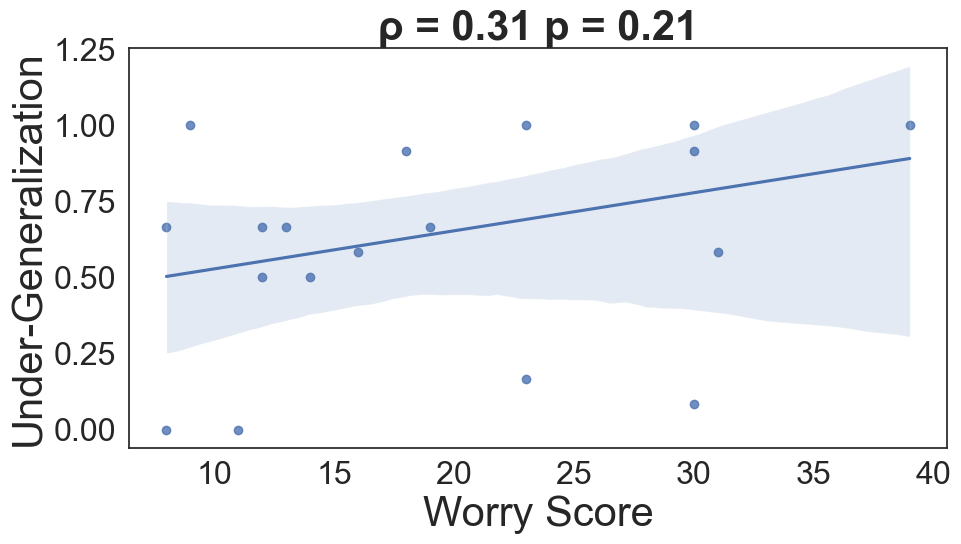

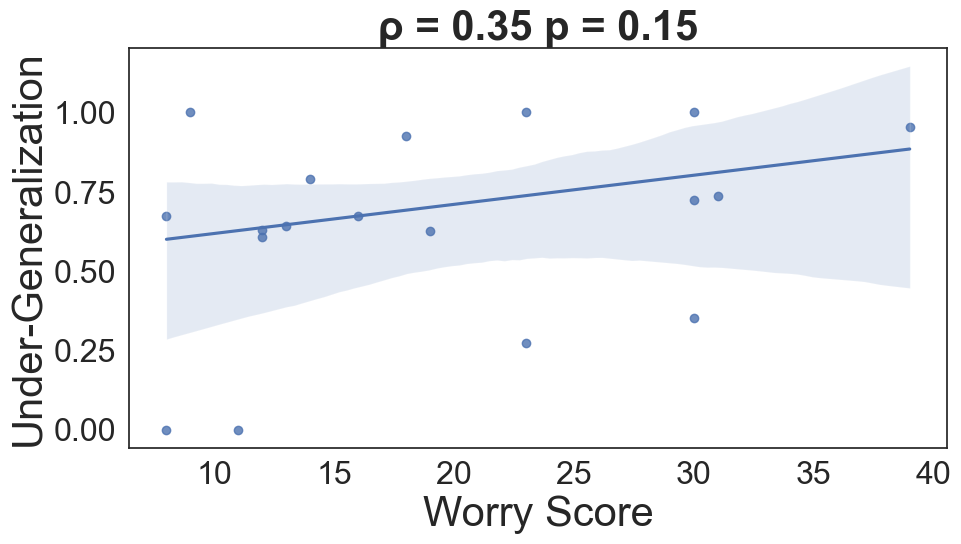

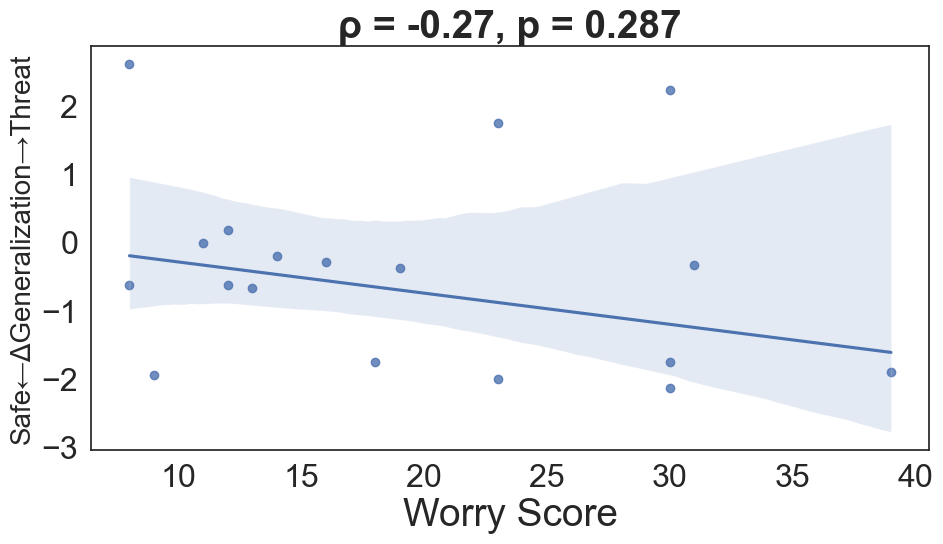

In [50]:
#!/usr/bin/env python3
"""
comprehensive_analysis_study2.py
────────────────────────────────
Integrates dangerous vehicle analysis, planning optimality, and key press
frequency for the Study 2 dataset (cars and trucks).

This script performs and plots:
1.  Mistake analysis ("toward" vs. "away" from dangerous vehicle).
2.  Under-generalization calculation ('prop_toward').
3.  Planning accuracy (exact match to optimal route).
4.  Key press frequency by category.
5.  Correlations between under-generalization, planning accuracy, and anxiety.
6.  Faceted plots for mistake categories, key press counts, and accuracy per vehicle.

NOTE: This version filters out participants with a mean planning accuracy below 1%.
"""
import sys
import json
from pathlib import Path
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# ─── Configuration ────────────────────────────────────────────────────────
CSV_PATH = Path("game_trials_export_v1.csv")
ORIGINAL_SUBJECT_COL = "prolificId" # Original ID from the file
PARTICIPANT_ID_COL = "participant_id" # New, simplified integer ID
PHASE_COL = "phase"
VEHICLE_COL = "vehicleType"
PLAN_COL = "plan_seq"
DANGEROUS_COL = "dangerous_vehicle"
OPTIMAL_ROUTE_COL = "optimalRoute"
WORRY_COL = "worry"
SOMA_COL = "somatic_anxiety"

# --- Mappings & Constants for Study 2 ---
car_up = {"e", "c"}
all_truck_up = {"t", "b"}
small_car_lr = {"q", "w"}
big_car_lr = {"z", "x"}
truck_lr = {"n", "m"}
pickup_truck_lr = {"y", "u"}

VALID_KEYS = {
    "small_car": small_car_lr | car_up,
    "big_car": big_car_lr | car_up,
    "truck": truck_lr | all_truck_up,
    "pickup_truck": pickup_truck_lr | all_truck_up,
    "medium_car": small_car_lr | big_car_lr | car_up,
    "dump_truck": truck_lr | pickup_truck_lr | all_truck_up,
}

KEY_TO_CATEGORY = defaultdict(list)
for category, keys in VALID_KEYS.items():
    for key in keys:
        KEY_TO_CATEGORY[key].append(category)

UNIVERSAL_KEY_MAP = {
    'e': 'up', 'c': 'down', 't': 'up', 'b': 'down',
    'q': 'left', 'w': 'right', 'z': 'left', 'x': 'right',
    'n': 'left', 'm': 'right', 'y': 'left', 'u': 'right'
}

RELEVANT_SET = {"small_car", "big_car", "truck", "pickup_truck"}
CHANCE_PERFORMANCE = 1 / (4**4)

# ─── Plotting Functions ───────────────────────────────────────────────────

def plot_faceted_plots(df, *, x_col, df_original, filename, title, x_label, y_label, plot_kind, y_col=None, hue_col=None):
    """Generalized function for plotting faceted plots, using keyword arguments for clarity."""
    print(f"\n--- Generating plot: {title} ---")
    if df.empty:
        print(f"Warning: No data available for plot '{title}'.")
        return

    category_order = ["small_car", "big_car", "medium_car", "truck", "pickup_truck", "dump_truck"]
    pretty_labels = ["Small\nCar", "Big\nCar", "Medium\nCar", "Truck", "Pickup\nTruck", "Dump\nTruck"]
    participant_dangerous_vehicles = df_original.drop_duplicates(subset=[PARTICIPANT_ID_COL]).set_index(PARTICIPANT_ID_COL)[DANGEROUS_COL].to_dict()

    plot_params = {
        'data': df, 'x': x_col, 'col': PARTICIPANT_ID_COL,
        'col_wrap': 4, 'palette': 'viridis', 'height': 5, 'aspect': 1.2,
    }

    if plot_kind == 'count':
        df[x_col] = pd.Categorical(df[x_col], categories=category_order, ordered=True)
        if hue_col:
            df[hue_col] = pd.Categorical(df[hue_col], categories=category_order, ordered=True)
        g = sns.displot(
            **plot_params, hue=hue_col, kind='hist',
            multiple='stack' if hue_col else 'layer', discrete=True
        )
        if hue_col:
            sns.move_legend(g, "center left", bbox_to_anchor=(1, 0.5), title='Guessed Category')
    elif plot_kind == 'bar':
        g = sns.catplot(
            **plot_params, y=y_col, kind=plot_kind,
            order=category_order, estimator=np.mean, errorbar=None
        )

    g.fig.suptitle(title, y=1.03, weight='bold')
    g.set_axis_labels(x_label, y_label)
    g.set_titles("Participant {col_name}")
    g.set_xticklabels(pretty_labels, rotation=45, ha='right')

    for i, ax in enumerate(g.axes.flatten()):
        if i < len(g.col_names):
            participant_id = g.col_names[i]
            dangerous_vehicle = participant_dangerous_vehicles.get(participant_id)
            if dangerous_vehicle:
                try:
                    dangerous_idx = category_order.index(dangerous_vehicle)
                    tick_labels = ax.get_xticklabels()
                    if dangerous_idx < len(tick_labels):
                        tick_labels[dangerous_idx].set_color('red')
                        tick_labels[dangerous_idx].set_fontweight('bold')
                except (ValueError, IndexError):
                    pass

    plt.tight_layout(rect=[0, 0, 0.9 if hue_col else 1, 0.97])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✅ Plot saved to '{filename}'")

def plot_correlation(df, x_col, y_col, x_label, y_label, title, filename):
    """Plots a correlation with robust regression and Spearman's rho."""
    print(f"\n--- Plotting Correlation: {title} ---")
    sub_df = df[[x_col, y_col]].dropna()
    if len(sub_df) < 3:
        print(f"Not enough data to plot {title}.")
        return
    spearman_corr, spearman_p = stats.spearmanr(sub_df[x_col], sub_df[y_col])
    plt.figure(figsize=(10, 6))
    sns.regplot(data=sub_df, x=x_col, y=y_col, robust=True)
    plt.xlabel(x_label, fontsize=30)
    plt.ylabel(y_label, fontsize=30)
    annotation = f"ρ = {spearman_corr:.2f} p = {spearman_p:.2f}"
    plt.title(annotation, fontsize=30, weight='bold')
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"✅ Correlation plot saved to '{filename}'")

# ─── Main Execution ───────────────────────────────────────────────────────

def main():
    """Main function to run all analyses and generate plots."""
    if not CSV_PATH.exists():
        sys.exit(f"Error: Data file not found at '{CSV_PATH}'")
    print(f"Loading data from '{CSV_PATH}'...")
    df = pd.read_csv(CSV_PATH)
    df_phase2 = df[df[PHASE_COL] == 2].copy()

    # --- Simplify Participant IDs ---
    unique_ids = df_phase2[ORIGINAL_SUBJECT_COL].unique()
    id_map = {old_id: new_id for new_id, old_id in enumerate(unique_ids, 1)}
    df_phase2[PARTICIPANT_ID_COL] = df_phase2[ORIGINAL_SUBJECT_COL].map(id_map)
    print(f"Simplified {len(unique_ids)} Prolific IDs to simple integer IDs.")

    # --- 1. Planning Accuracy Analysis (done first for filtering) ---
    df_phase2['planning_accuracy'] = df_phase2.apply(calculate_exact_match_accuracy, axis=1)
    accuracy_df = df_phase2.groupby(PARTICIPANT_ID_COL, as_index=False)[['planning_accuracy']].mean()

    # --- ❗ NEW: Filter subjects with low planning accuracy ---
    accuracy_threshold = 0.01
    low_accuracy_subjects = accuracy_df[accuracy_df['planning_accuracy'] < accuracy_threshold]
    subjects_to_remove = low_accuracy_subjects[PARTICIPANT_ID_COL].tolist()

    if subjects_to_remove:
        print(f"\n--- Removing {len(subjects_to_remove)} subjects with planning accuracy < {accuracy_threshold:.0%} ---")
        print(f"Removing participants: {subjects_to_remove}")
        
        # Filter the main dataframe
        original_subject_count = df_phase2[PARTICIPANT_ID_COL].nunique()
        df_phase2 = df_phase2[~df_phase2[PARTICIPANT_ID_COL].isin(subjects_to_remove)].copy()
        
        # Also filter the accuracy_df itself for merging later
        accuracy_df = accuracy_df[~accuracy_df[PARTICIPANT_ID_COL].isin(subjects_to_remove)].copy()

        print(f"Removed {len(subjects_to_remove)} subjects. {df_phase2[PARTICIPANT_ID_COL].nunique()} subjects remaining for analysis.")
    else:
        print("\n--- No subjects met the criteria for removal based on low planning accuracy. ---")
    # --- End of new step ---

    # --- 2. Generalization & Mistake Analysis on FILTERED data ---
    records = [analyse_subj(grp) for _, grp in df_phase2.groupby(PARTICIPANT_ID_COL)]
    summary_df = pd.DataFrame(records)

    # --- 3. Merge Data ---
    final_summary_df = pd.merge(summary_df, accuracy_df, on=PARTICIPANT_ID_COL)

    # --- 4. Statistical Tests ---
    stats.ttest_1samp(final_summary_df['planning_accuracy'].dropna(), CHANCE_PERFORMANCE, alternative='greater')

    # Key press frequency plot
    key_press_df = create_long_format_df(df_phase2, 'key_press')
    # plot_faceted_plots(df=key_press_df, x_col='category_chosen', plot_kind='count',
    #                    title='Frequency of Key Presses by Category', x_label='Vehicle Category of Key',
    #                    y_label='Total Times Chosen', filename='participant_key_choice_frequency_s1_after_filtering_generalization.png',
    #                    df_original=df_phase2)

    # Accuracy per vehicle plot
    accuracy_per_vehicle_df = create_long_format_df(df_phase2, 'accuracy')
    # plot_faceted_plots(df=accuracy_per_vehicle_df, x_col='vehicle', y_col='is_valid', plot_kind='bar',
    #                    title='Accuracy per Vehicle Type', x_label='Vehicle Type',
    #                    y_label='Accuracy', filename='participant_accuracy_by_category_s1_after_filtering_generalization_dangeronly.png',
    #                    df_original=df_phase2)

    for anxiety_measure in [WORRY_COL]:
        plot_correlation(df=final_summary_df,
                          x_col=anxiety_measure, y_col='prop_toward',
                          x_label=f'{anxiety_measure.title()} Score', y_label='Under-Generalization',
                          title=f'Under-Generalization vs. {anxiety_measure.title()}',
                          filename=f'correlation_under_generalization_vs_{anxiety_measure}__DANGER_s1.png')

        plot_correlation(df=final_summary_df,
                          x_col=anxiety_measure, y_col='prop_toward_nd',
                          x_label=f'{anxiety_measure.title()} Score', y_label='Under-Generalization',
                          title=f'Under-Generalization vs. {anxiety_measure.title()}',
                          filename=f'correlation_under_generalization_vs_{anxiety_measure}__NONDANGER_s1.png')

        # plot_correlation(df=final_summary_df,
        #                   x_col=anxiety_measure, y_col='exact_match_accuracy',
        #                   x_label=f'{anxiety_measure.title()} Score', y_label='Planning Accuracy',
        #                   title=f'Planning Accuracy vs. {anxiety_measure.title()}',
        #                   filename=f'correlation_accuracy_vs_{anxiety_measure}_s2.png')
    # === Valid Key Usage Analysis ===
    print("\n--- Performing Valid Key Usage Analysis ---")
    
    # Apply the CORRECTED analysis function to each participant's data
    valid_key_records = [analyze_valid_key_usage_per_subject(grp) for _, grp in df_phase2.groupby(PARTICIPANT_ID_COL)]
    
    # Create a summary DataFrame from the results
    valid_key_summary_df = pd.DataFrame(valid_key_records)

    # Generate the correlation plot using the updated plotting function
    plot_valid_key_usage_difference_vs_worry(
        df=valid_key_summary_df,
        filename='correlation_valid_key_usage_difference_vs_worry_s1.png'
    )
    # === 6. Additional Visualizations (on filtered data) ===
    # mistake_df = create_mistake_df(df_phase2)
    # # plot_guessed_categories(mistake_df, df_phase2)

    # key_press_df = create_key_press_df(df_phase2)
    # plot_key_press_counts(key_press_df, df_phase2)
    print("\nScript finished.")


if __name__ == "__main__":
    main()


Loading data from 'game_trials_export_v1.csv'...
Simplified 21 Prolific IDs to simple integer IDs.

--- Removing 3 subjects with planning accuracy < 1% ---
Removing participants: [5, 7, 21]
Removed 3 subjects. 18 subjects remaining for analysis.

--- Keyset-based Category Coverage Filter ---
Participants before: 18
Participants after:  15
Removed (< 4 categories covered by pressed keys): 3
Synchronized accuracy_df participants: 18 -> 15

--- Plotting Correlation: Under-Generalization vs. Worry ---


C:\Users\pshar\miniconda3\envs\TOPICS_2025\Lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'


✅ Correlation plot saved to 'correlation_under_generalization_vs_worry_GENERALIZERS_DANGER_s1.png'

--- Plotting Correlation: Under-Generalization vs. Worry ---
✅ Correlation plot saved to 'correlation_under_generalization_vs_worry_GENERALIZERS_NONDANGER_s1.png'

--- Performing Valid Key Usage Analysis ---

--- Plotting Correlation: Valid Key Usage Difference vs. Worry ---
✅ Correlation plot saved to 'correlation_valid_key_usage_difference_vs_worry_GENERALIZERS_s1.png'

Script finished.

Script finished.


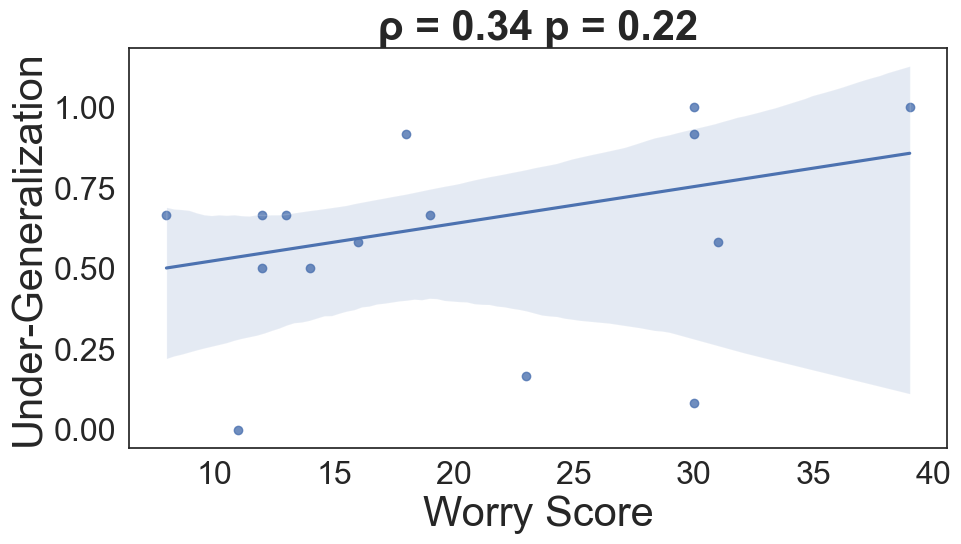

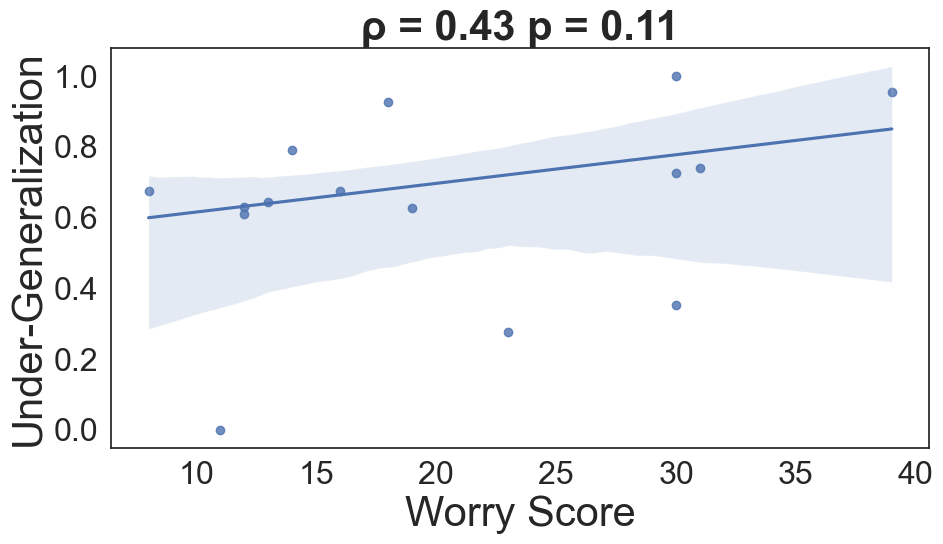

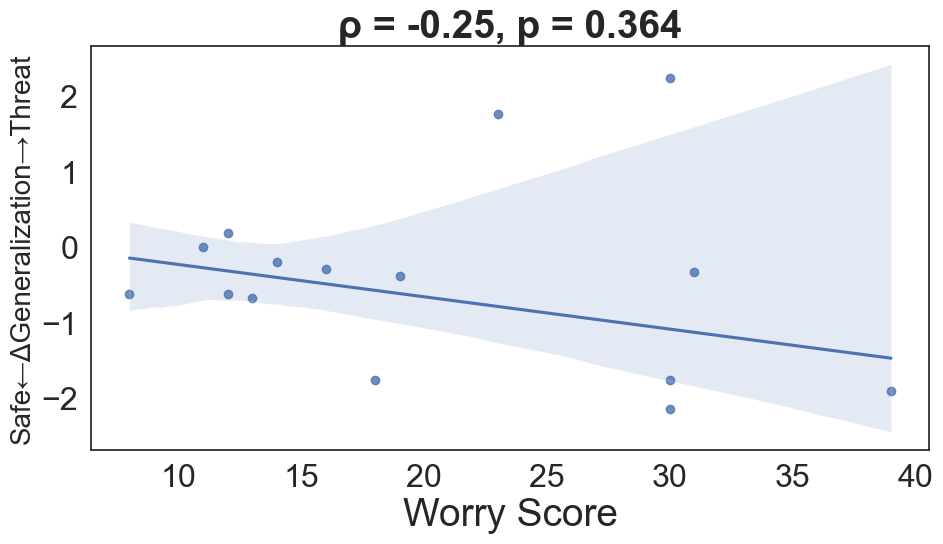

In [51]:
#!/usr/bin/env python3
"""
comprehensive_analysis_study2.py
────────────────────────────────
Integrates dangerous vehicle analysis, planning optimality, and key press
frequency for the Study 2 dataset (cars and trucks).

This script performs and plots:
1.  Mistake analysis ("toward" vs. "away" from dangerous vehicle).
2.  Under-generalization calculation ('prop_toward').
3.  Planning accuracy (exact match to optimal route).
4.  Key press frequency by category.
5.  Correlations between under-generalization, planning accuracy, and anxiety.
6.  Faceted plots for mistake categories, key press counts, and accuracy per vehicle.

NOTE: This version filters out participants with a mean planning accuracy below 1%.
"""
import sys
import json
from pathlib import Path
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# ─── Configuration ────────────────────────────────────────────────────────
CSV_PATH = Path("game_trials_export_v1.csv")
ORIGINAL_SUBJECT_COL = "prolificId" # Original ID from the file
PARTICIPANT_ID_COL = "participant_id" # New, simplified integer ID
PHASE_COL = "phase"
VEHICLE_COL = "vehicleType"
PLAN_COL = "plan_seq"
DANGEROUS_COL = "dangerous_vehicle"
OPTIMAL_ROUTE_COL = "optimalRoute"
WORRY_COL = "worry"
SOMA_COL = "somatic_anxiety"

# --- Mappings & Constants for Study 2 ---
car_up = {"e", "c"}
all_truck_up = {"t", "b"}
small_car_lr = {"q", "w"}
big_car_lr = {"z", "x"}
truck_lr = {"n", "m"}
pickup_truck_lr = {"y", "u"}

VALID_KEYS = {
    "small_car": small_car_lr | car_up,
    "big_car": big_car_lr | car_up,
    "truck": truck_lr | all_truck_up,
    "pickup_truck": pickup_truck_lr | all_truck_up,
    "medium_car": small_car_lr | big_car_lr | car_up,
    "dump_truck": truck_lr | pickup_truck_lr | all_truck_up,
}

KEY_TO_CATEGORY = defaultdict(list)
for category, keys in VALID_KEYS.items():
    for key in keys:
        KEY_TO_CATEGORY[key].append(category)

UNIVERSAL_KEY_MAP = {
    'e': 'up', 'c': 'down', 't': 'up', 'b': 'down',
    'q': 'left', 'w': 'right', 'z': 'left', 'x': 'right',
    'n': 'left', 'm': 'right', 'y': 'left', 'u': 'right'
}

RELEVANT_SET = {"small_car", "big_car", "truck", "pickup_truck"}
CHANCE_PERFORMANCE = 1 / (4**4)


# ─── Plotting Functions ───────────────────────────────────────────────────

def plot_faceted_plots(df, *, x_col, df_original, filename, title, x_label, y_label, plot_kind, y_col=None, hue_col=None):
    """Generalized function for plotting faceted plots, using keyword arguments for clarity."""
    print(f"\n--- Generating plot: {title} ---")
    if df.empty:
        print(f"Warning: No data available for plot '{title}'.")
        return

    category_order = ["small_car", "big_car", "medium_car", "truck", "pickup_truck", "dump_truck"]
    pretty_labels = ["Small\nCar", "Big\nCar", "Medium\nCar", "Truck", "Pickup\nTruck", "Dump\nTruck"]
    participant_dangerous_vehicles = df_original.drop_duplicates(subset=[PARTICIPANT_ID_COL]).set_index(PARTICIPANT_ID_COL)[DANGEROUS_COL].to_dict()

    plot_params = {
        'data': df, 'x': x_col, 'col': PARTICIPANT_ID_COL,
        'col_wrap': 4, 'palette': 'viridis', 'height': 5, 'aspect': 1.2,
    }

    if plot_kind == 'count':
        df[x_col] = pd.Categorical(df[x_col], categories=category_order, ordered=True)
        if hue_col:
            df[hue_col] = pd.Categorical(df[hue_col], categories=category_order, ordered=True)
        g = sns.displot(
            **plot_params, hue=hue_col, kind='hist',
            multiple='stack' if hue_col else 'layer', discrete=True
        )
        if hue_col:
            sns.move_legend(g, "center left", bbox_to_anchor=(1, 0.5), title='Guessed Category')
    elif plot_kind == 'bar':
        g = sns.catplot(
            **plot_params, y=y_col, kind=plot_kind,
            order=category_order, estimator=np.mean, errorbar=None
        )

    g.fig.suptitle(title, y=1.03, weight='bold')
    g.set_axis_labels(x_label, y_label)
    g.set_titles("Participant {col_name}")
    g.set_xticklabels(pretty_labels, rotation=45, ha='right')

    for i, ax in enumerate(g.axes.flatten()):
        if i < len(g.col_names):
            participant_id = g.col_names[i]
            dangerous_vehicle = participant_dangerous_vehicles.get(participant_id)
            if dangerous_vehicle:
                try:
                    dangerous_idx = category_order.index(dangerous_vehicle)
                    tick_labels = ax.get_xticklabels()
                    if dangerous_idx < len(tick_labels):
                        tick_labels[dangerous_idx].set_color('red')
                        tick_labels[dangerous_idx].set_fontweight('bold')
                except (ValueError, IndexError):
                    pass

    plt.tight_layout(rect=[0, 0, 0.9 if hue_col else 1, 0.97])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✅ Plot saved to '{filename}'")

def plot_correlation(df, x_col, y_col, x_label, y_label, title, filename):
    """Plots a correlation with robust regression and Spearman's rho."""
    print(f"\n--- Plotting Correlation: {title} ---")
    sub_df = df[[x_col, y_col]].dropna()
    if len(sub_df) < 3:
        print(f"Not enough data to plot {title}.")
        return
    spearman_corr, spearman_p = stats.spearmanr(sub_df[x_col], sub_df[y_col])
    plt.figure(figsize=(10, 6))
    sns.regplot(data=sub_df, x=x_col, y=y_col, robust=True)
    plt.xlabel(x_label, fontsize=30)
    plt.ylabel(y_label, fontsize=30)
    annotation = f"ρ = {spearman_corr:.2f} p = {spearman_p:.2f}"
    plt.title(annotation, fontsize=30, weight='bold')
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"✅ Correlation plot saved to '{filename}'")

# ─── Main Execution ───────────────────────────────────────────────────────

def main():
    """Main function to run all analyses and generate plots."""
    if not CSV_PATH.exists():
        sys.exit(f"Error: Data file not found at '{CSV_PATH}'")
    print(f"Loading data from '{CSV_PATH}'...")
    df = pd.read_csv(CSV_PATH)
    df_phase2 = df[df[PHASE_COL] == 2].copy()

    # --- Simplify Participant IDs ---
    unique_ids = df_phase2[ORIGINAL_SUBJECT_COL].unique()
    id_map = {old_id: new_id for new_id, old_id in enumerate(unique_ids, 1)}
    df_phase2[PARTICIPANT_ID_COL] = df_phase2[ORIGINAL_SUBJECT_COL].map(id_map)
    print(f"Simplified {len(unique_ids)} Prolific IDs to simple integer IDs.")

    # --- 1. Planning Accuracy Analysis (done first for filtering) ---
    df_phase2['planning_accuracy'] = df_phase2.apply(calculate_exact_match_accuracy, axis=1)
    accuracy_df = df_phase2.groupby(PARTICIPANT_ID_COL, as_index=False)[['planning_accuracy']].mean()

    # --- ❗ NEW: Filter subjects with low planning accuracy ---
    accuracy_threshold = 0.01
    low_accuracy_subjects = accuracy_df[accuracy_df['planning_accuracy'] < accuracy_threshold]
    subjects_to_remove = low_accuracy_subjects[PARTICIPANT_ID_COL].tolist()

    if subjects_to_remove:
        print(f"\n--- Removing {len(subjects_to_remove)} subjects with planning accuracy < {accuracy_threshold:.0%} ---")
        print(f"Removing participants: {subjects_to_remove}")
        
        # Filter the main dataframe
        original_subject_count = df_phase2[PARTICIPANT_ID_COL].nunique()
        df_phase2 = df_phase2[~df_phase2[PARTICIPANT_ID_COL].isin(subjects_to_remove)].copy()
        
        # Also filter the accuracy_df itself for merging later
        accuracy_df = accuracy_df[~accuracy_df[PARTICIPANT_ID_COL].isin(subjects_to_remove)].copy()

        print(f"Removed {len(subjects_to_remove)} subjects. {df_phase2[PARTICIPANT_ID_COL].nunique()} subjects remaining for analysis.")
    else:
        print("\n--- No subjects met the criteria for removal based on low planning accuracy. ---")
    # --- End of new step ---
    # --- NEW: filter subjects by key coverage (based on actual keys pressed) ---
    df_phase2, key_coverage_summary = filter_subjects_by_key_coverage(df_phase2, min_categories=4)
    remaining_ids = set(df_phase2[PARTICIPANT_ID_COL].unique())
    before = accuracy_df[PARTICIPANT_ID_COL].nunique()
    accuracy_df = accuracy_df[accuracy_df[PARTICIPANT_ID_COL].isin(remaining_ids)].copy()
    after = accuracy_df[PARTICIPANT_ID_COL].nunique()
    
    print(f"Synchronized accuracy_df participants: {before} -> {after}")
    assert set(accuracy_df[PARTICIPANT_ID_COL]) == remaining_ids, \
        "Mismatch between accuracy_df and df_phase2 participant IDs after subsetting."

    # --- 2. Generalization & Mistake Analysis on FILTERED data ---
    records = [analyse_subj(grp) for _, grp in df_phase2.groupby(PARTICIPANT_ID_COL)]
    summary_df = pd.DataFrame(records)

    # --- 3. Merge Data ---
    final_summary_df = pd.merge(summary_df, accuracy_df, on=PARTICIPANT_ID_COL)

    # --- 4. Statistical Tests ---
    # stats.ttest_ind(final_summary_df["mistakes_nondangerous"].dropna(), final_summary_df["mistakes_dangerous"].dropna())
    stats.ttest_1samp(final_summary_df['planning_accuracy'].dropna(), CHANCE_PERFORMANCE, alternative='greater')



    # Key press frequency plot
    key_press_df = create_long_format_df(df_phase2, 'key_press')
    # plot_faceted_plots(df=key_press_df, x_col='category_chosen', plot_kind='count',
    #                    title='Frequency of Key Presses by Category', x_label='Vehicle Category of Key',
    #                    y_label='Total Times Chosen', filename='participant_key_choice_frequency_s1_after_filtering_generalization.png',
    #                    df_original=df_phase2)

    # Accuracy per vehicle plot
    accuracy_per_vehicle_df = create_long_format_df(df_phase2, 'accuracy')
    # plot_faceted_plots(df=accuracy_per_vehicle_df, x_col='vehicle', y_col='is_valid', plot_kind='bar',
    #                    title='Accuracy per Vehicle Type', x_label='Vehicle Type',
    #                    y_label='Accuracy', filename='participant_accuracy_by_category_s1_after_filtering_generalization_dangeronly.png',
    #                    df_original=df_phase2)

    for anxiety_measure in [WORRY_COL]:
        plot_correlation(df=final_summary_df,
                          x_col=anxiety_measure, y_col='prop_toward',
                          x_label=f'{anxiety_measure.title()} Score', y_label='Under-Generalization',
                          title=f'Under-Generalization vs. {anxiety_measure.title()}',
                          filename=f'correlation_under_generalization_vs_{anxiety_measure}_GENERALIZERS_DANGER_s1.png')

        plot_correlation(df=final_summary_df,
                          x_col=anxiety_measure, y_col='prop_toward_nd',
                          x_label=f'{anxiety_measure.title()} Score', y_label='Under-Generalization',
                          title=f'Under-Generalization vs. {anxiety_measure.title()}',
                          filename=f'correlation_under_generalization_vs_{anxiety_measure}_GENERALIZERS_NONDANGER_s1.png')

        # plot_correlation(df=final_summary_df,
        #                   x_col=anxiety_measure, y_col='exact_match_accuracy',
        #                   x_label=f'{anxiety_measure.title()} Score', y_label='Planning Accuracy',
        #                   title=f'Planning Accuracy vs. {anxiety_measure.title()}',
        #                   filename=f'correlation_accuracy_vs_{anxiety_measure}_s2.png')
    # === Valid Key Usage Analysis ===
    print("\n--- Performing Valid Key Usage Analysis ---")
    
    # Apply the CORRECTED analysis function to each participant's data
    valid_key_records = [analyze_valid_key_usage_per_subject(grp) for _, grp in df_phase2.groupby(PARTICIPANT_ID_COL)]
    
    # Create a summary DataFrame from the results
    valid_key_summary_df = pd.DataFrame(valid_key_records)

    # Generate the correlation plot using the updated plotting function
    plot_valid_key_usage_difference_vs_worry(
        df=valid_key_summary_df,
        filename='correlation_valid_key_usage_difference_vs_worry_GENERALIZERS_s1.png'
    )
    # === 6. Additional Visualizations (on filtered data) ===
    # mistake_df = create_mistake_df(df_phase2)
    # # plot_guessed_categories(mistake_df, df_phase2)

    # key_press_df = create_key_press_df(df_phase2)
    # plot_key_press_counts(key_press_df, df_phase2)
    print("\nScript finished.")

    # === 6. Additional Visualizations (on filtered data) ===
    # mistake_df = create_mistake_df(df_phase2)
    # # plot_guessed_categories(mistake_df, df_phase2)

    # key_press_df = create_key_press_df(df_phase2)
    # plot_key_press_counts(key_press_df, df_phase2)
    print("\nScript finished.")

if __name__ == "__main__":
    main()


In [56]:
#!/usr/bin/env python3
"""
logistic_glmm_accuracy_test.py
───────────────────────────────────────────
Logistic GLMM (random intercepts by participant) for binary correctness.

Flow:
1) Load Phase 2, map participant IDs.
2) Drop participants with exact route match < 1%.
3) Build long-format keypress data.
4) Drop participants without ≥1 keypress in ≥4/6 categories.
5) Fit Binomial (logit) GLMM with random intercepts by participant using
   statsmodels' BinomialBayesMixedGLM (fast variational Bayes).
6) Test fixed intercept against logit(0.375); report μ on prob scale and CI.
7) Approximate the population-average (marginal) μ by integrating over RE.

Notes
- MixedLM in statsmodels is linear; for logistic mixed effects use BinomialBayesMixedGLM.
- The fixed intercept is a subject-specific (conditional) parameter. The
  marginal (population-average) mean is E[logit^{-1}(β0 + u)], u~N(0, σ^2).
  We report a Monte Carlo estimate for that as well.

"""

import json
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.special import expit, logit
from collections import defaultdict
import statsmodels.api as sm
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

sns.set_theme(style="whitegrid", font_scale=2)

# ─── Configuration ────────────────────────────────────────────────────────
CSV_PATH = Path("game_trials_export_v1.csv")
ORIGINAL_SUBJECT_COL = "prolificId" # Original ID from the file
SUBJECT_COL = "prolificId" # Original ID from the file

PARTICIPANT_ID_COL = "participant_id" # New, simplified integer ID
PHASE_COL = "phase"
VEHICLE_COL = "vehicleType"
PLAN_COL = "plan_seq"
DANGEROUS_COL = "dangerous_vehicle"
OPTIMAL_ROUTE_COL = "optimalRoute"
WORRY_COL = "worry"
SOMA_COL = "somatic_anxiety"
NULL_MU = 0.375  # mean of 0.25 and 0.5

# --- Mappings & Constants for Study 2 ---
car_up = {"e", "c"}
all_truck_up = {"t", "b"}
small_car_lr = {"q", "w"}
big_car_lr = {"z", "x"}
truck_lr = {"n", "m"}
pickup_truck_lr = {"y", "u"}

VALID_KEYS = {
    "small_car": small_car_lr | car_up,
    "big_car": big_car_lr | car_up,
    "truck": truck_lr | all_truck_up,
    "pickup_truck": pickup_truck_lr | all_truck_up,
    "medium_car": small_car_lr | big_car_lr | car_up,
    "dump_truck": truck_lr | pickup_truck_lr | all_truck_up,
}
higher_order_vehicles=['medium_car', 'dump_truck']
KEY_TO_CATEGORY = defaultdict(list)
for category, keys in VALID_KEYS.items():
    for key in keys:
        KEY_TO_CATEGORY[key].append(category)

UNIVERSAL_KEY_MAP = {
    'e': 'up', 'c': 'down', 't': 'up', 'b': 'down',
    'q': 'left', 'w': 'right', 'z': 'left', 'x': 'right',
    'n': 'left', 'm': 'right', 'y': 'left', 'u': 'right'
}

RELEVANT_SET = {"small_car", "big_car", "truck", "pickup_truck"}
CHANCE_PERFORMANCE = 1 / (4**4)

# ─── Helpers ────────────────────────────────────────────────────────────────
def parse_plan(seq):
    if not isinstance(seq, str):
        return []
    return [ch.lower() for ch in seq if ch.isalpha()]

def parse_optimal_route(json_str):
    try:
        return [direction.lower() for direction in json.loads(json_str)]
    except (json.JSONDecodeError, TypeError):
        return []

def calculate_exact_match_accuracy(row):
    optimal_dirs = parse_optimal_route(row[OPTIMAL_ROUTE_COL])
    plan_keys = str(row[PLAN_COL]) if pd.notna(row[PLAN_COL]) else ""
    if not optimal_dirs or not plan_keys:
        return np.nan
    participant_dirs = [UNIVERSAL_KEY_MAP.get(key, 'unknown') for key in plan_keys.lower()]
    return 1.0 if participant_dirs == optimal_dirs else 0.0

def to_long_keypress_df(df):
    """
    One row per key press: ['participant_id', 'category', 'is_correct'].
    """
    print("Aggregating data into long format...")
    records = []
    for _, row in df.iterrows():
        pid = row[PARTICIPANT_ID_COL]
        vehicle = row[VEHICLE_COL]
        if vehicle not in higher_order_vehicles:
            if vehicle not in VALID_KEYS:
                continue
            plan = parse_plan(row[PLAN_COL])
            valid = set(VALID_KEYS[vehicle])
            for k in plan:
                records.append({
                    'participant_id': pid,
                    'vehicleType': vehicle,
                    'category': vehicle,
                    'pressed_key':k,
                    'is_correct': 1 if k in valid else 0
                })
    if not records:
        return pd.DataFrame(columns=['participant_id','category','is_correct'])
    out = pd.DataFrame(records)
    print(f"✅ Prepared {len(out)} key presses.")
    return out

def filter_participants_by_keyset_coverage(long_df, min_categories=5):
    """
    Keep participants who (based on the actual keys they pressed) 'cover' at least
    `min_categories` categories. A category is 'covered' for a participant if they
    pressed any key that appears in VALID_KEYS[that_category], regardless of the
    trial category those keys were pressed in.

    Requires long_df to have columns: ['participant_id', 'pressed_key'].
    """
    required_cols = {'participant_id', 'pressed_key'}
    if not required_cols.issubset(long_df.columns):
        raise ValueError("long_df must contain columns 'participant_id' and 'pressed_key'. "
                         "Update prepare_bayesian_data_long to store each key as 'pressed_key'.")

    # Build key -> set(categories) map once
    key_to_categories = {}
    for cat, keys in VALID_KEYS.items():
        for k in keys:
            key_to_categories.setdefault(k, set()).add(cat)

    # Normalize keys to lowercase strings
    df = long_df.copy()
    df['pressed_key'] = df['pressed_key'].astype(str).str.lower()

    # For each participant, union all categories that contain any of their pressed keys
    coverage_rows = []
    for pid, sub in df.groupby('participant_id', sort=False):
        keys_used = set(sub['pressed_key'].dropna())
        cats_covered = set()
        for k in keys_used:
            cats_covered |= key_to_categories.get(k, set())
        coverage_rows.append({
            'participant_id': pid,
            'n_categories_by_keys': len(cats_covered),
            'categories_by_keys': sorted(cats_covered)
        })

    coverage_df = pd.DataFrame(coverage_rows)
    keep_ids = coverage_df.loc[coverage_df['n_categories_by_keys'] >= min_categories, 'participant_id']

    before = df['participant_id'].nunique()
    filtered_df = df[df['participant_id'].isin(keep_ids)].copy()
    after = filtered_df['participant_id'].nunique()

    print("\n--- Keyset-based Category Coverage ---")
    print(f"Participants before: {before}")
    print(f"Participants after:  {after}")
    print(f"Removed (< {min_categories} categories covered by keys): {before - after}")

    if after == 0:
        print("⚠️  All participants removed by keyset coverage filter.")

    return filtered_df, coverage_df


# ─── Logistic GLMM (VB) ─────────────────────────────────────────────────────
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
import numpy as np

def _extract_intercept_mean_se(result):
    """
    Robustly get (beta0_mean, beta0_se) for the fixed intercept from
    statsmodels.genmod.bayes_mixed_glm results, across SM versions and fit_* methods.
    Order of preference:
      1) fe_mean[0], fe_sd[0]
      2) fe_mean[0], sqrt(diag(fe_cov))[0]
      3) params[0],  bse[0]
      4) params[0],  sqrt(diag(cov_params()))[0]
    Raises a clear error if none are available.
    """
    # 1) VB/MAP often expose fe_mean / fe_sd
    if hasattr(result, "fe_mean"):
        beta0 = float(np.atleast_1d(result.fe_mean)[0])
        if hasattr(result, "fe_sd") and result.fe_sd is not None:
            se0 = float(np.atleast_1d(result.fe_sd)[0])
            return beta0, se0
        # 2) Try fe_cov if fe_sd missing
        if hasattr(result, "fe_cov") and result.fe_cov is not None:
            fe_cov = np.asarray(result.fe_cov)
            se0 = float(np.sqrt(np.diag(fe_cov))[0])
            return beta0, se0

    # 3) Fallback to generic params / bse
    if hasattr(result, "params"):
        beta0 = float(np.atleast_1d(result.params)[0])
        if hasattr(result, "bse") and result.bse is not None:
            se0 = float(np.atleast_1d(result.bse)[0])
            return beta0, se0
        # 4) Try cov_params()
        if hasattr(result, "cov_params"):
            cov = result.cov_params()
            if cov is not None:
                cov = np.asarray(cov)
                se0 = float(np.sqrt(np.diag(cov))[0])
                return beta0, se0

    raise RuntimeError(
        "Could not find an SE for the fixed intercept in the BinomialBayesMixedGLM results. "
        "Try `fit_vb()` (which provides posterior SDs) or ensure your statsmodels version "
        "exposes `fe_sd`, `fe_cov`, `bse`, or `cov_params()`."
    )

import numpy as np
import pandas as pd
from scipy import stats
from scipy import sparse
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM


# ─── Main ──────────────────────────────────────────────────────────────────
def main():
    if not CSV_PATH.exists():
        sys.exit(f"Error: Data file not found at '{CSV_PATH}'")
    print(f"Loading data from '{CSV_PATH}'...")
    df = pd.read_csv(CSV_PATH)
    df_phase2 = df[df[PHASE_COL] == 2].copy()

    unique_ids = df_phase2[SUBJECT_COL].unique()
    id_map = {old_id: new_id for new_id, old_id in enumerate(unique_ids, 1)}
    df_phase2[PARTICIPANT_ID_COL] = df_phase2[SUBJECT_COL].map(id_map)
    print(f"Loaded and filtered Phase 2 data for {len(unique_ids)} participants.")

    # Filter by planning accuracy
    print("\n--- Filtering participants based on planning accuracy ---")
    df_phase2['exact_match_accuracy'] = df_phase2.apply(calculate_exact_match_accuracy, axis=1)
    accuracy_df = df_phase2.groupby(PARTICIPANT_ID_COL)[['exact_match_accuracy']].mean()
    accuracy_threshold = 0.01
    low_accuracy_subjects = accuracy_df[accuracy_df['exact_match_accuracy'] < accuracy_threshold].index.tolist()
    if low_accuracy_subjects:
        print(f"Removing {len(low_accuracy_subjects)} participants with planning accuracy < {accuracy_threshold:.0%}")
        df_phase2 = df_phase2[~df_phase2[PARTICIPANT_ID_COL].isin(low_accuracy_subjects)].copy()
        print(f"{df_phase2[PARTICIPANT_ID_COL].nunique()} participants remain for analysis.")
    else:
        print("No participants met the criteria for removal.")

    # Build long-format keypress data
    long_df = to_long_keypress_df(df_phase2)

    # # Coverage filter: ≥4 of 6 categories
    # long_df,counts_df = filter_participants_by_keyset_coverage(long_df, min_categories=4)
    # print(counts_df)
    
    # Fit GLMM (logit)
    if not long_df.empty and long_df['participant_id'].nunique() > 0:
       x,e=run_statsmodels_hier_logit_intercept_only(long_df, test_probability=0.375)
    else:
        print("\nError: No data available for GLMM analysis after processing.")

    print("\nScript finished.")

if __name__ == "__main__":
    main()


Loading data from 'game_trials_export_v1.csv'...
Loaded and filtered Phase 2 data for 21 participants.

--- Filtering participants based on planning accuracy ---
Removing 3 participants with planning accuracy < 1%
18 participants remain for analysis.
Aggregating data into long format...
✅ Prepared 864 key presses.

Fitting BinomialBayesMixedGLM on 864 trials, 18 participants ...


C:\Users\pshar\miniconda3\envs\TOPICS_2025\Lib\site-packages\statsmodels\genmod\bayes_mixed_glm.py:520: UserWarning: Laplace fitting did not converge, |gradient|=2.268109
  warnings.warn(msg)


            Binomial Mixed GLM Results
     Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
---------------------------------------------------
FE_1    M    -0.2416   0.0685                      
VC_1    V   -18.0000   1.0000 0.000   0.000   0.000
Parameter types are mean structure (M) and variance
structure (V)
Variance parameters are modeled as log standard
deviations
res:{'p_bar_hat': 0.4398847308286267, 'ci95': (0.4076474266074285, 0.4740259814344724), 'p_one_sided': 0.0, 'beta0': -0.2416298829860452, 'sigma': 1.5229979761131033e-08}

Script finished.


In [55]:
#!/usr/bin/env python3
"""
logistic_glmm_accuracy_test.py
───────────────────────────────────────────
Logistic GLMM (random intercepts by participant) for binary correctness.

Flow:
1) Load Phase 2, map participant IDs.
2) Drop participants with exact route match < 1%.
3) Build long-format keypress data.
4) Drop participants without ≥1 keypress in ≥4/6 categories.
5) Fit Binomial (logit) GLMM with random intercepts by participant using
   statsmodels' BinomialBayesMixedGLM (fast variational Bayes).
6) Test fixed intercept against logit(0.375); report μ on prob scale and CI.
7) Approximate the population-average (marginal) μ by integrating over RE.

Notes
- MixedLM in statsmodels is linear; for logistic mixed effects use BinomialBayesMixedGLM.
- The fixed intercept is a subject-specific (conditional) parameter. The
  marginal (population-average) mean is E[logit^{-1}(β0 + u)], u~N(0, σ^2).
  We report a Monte Carlo estimate for that as well.

"""

import json
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.special import expit, logit
from collections import defaultdict
import statsmodels.api as sm
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

sns.set_theme(style="whitegrid", font_scale=2)

# ─── Configuration ────────────────────────────────────────────────────────
CSV_PATH = Path("game_trials_export_v1.csv")
ORIGINAL_SUBJECT_COL = "prolificId" # Original ID from the file
PARTICIPANT_ID_COL = "participant_id" # New, simplified integer ID
PHASE_COL = "phase"
VEHICLE_COL = "vehicleType"
PLAN_COL = "plan_seq"
DANGEROUS_COL = "dangerous_vehicle"
OPTIMAL_ROUTE_COL = "optimalRoute"
WORRY_COL = "worry"
SOMA_COL = "somatic_anxiety"
NULL_MU = 0.5  # mean of 0.25 and 0.5
higher_order_vehicles=['medium_car', 'dump_truck']

# --- Mappings & Constants for Study 2 ---
car_up = {"e", "c"}
all_truck_up = {"t", "b"}
small_car_lr = {"q", "w"}
big_car_lr = {"z", "x"}
truck_lr = {"n", "m"}
pickup_truck_lr = {"y", "u"}

VALID_KEYS = {
    "small_car": big_car_lr |small_car_lr | car_up,
    "big_car": small_car_lr |big_car_lr | car_up,
    "truck": truck_lr | pickup_truck_lr | all_truck_up,
    "pickup_truck": truck_lr | pickup_truck_lr | all_truck_up,
    "medium_car": small_car_lr | big_car_lr | car_up,
    "dump_truck": truck_lr | pickup_truck_lr | all_truck_up,
}

KEY_TO_CATEGORY = defaultdict(list)
for category, keys in VALID_KEYS.items():
    for key in keys:
        KEY_TO_CATEGORY[key].append(category)

UNIVERSAL_KEY_MAP = {
    'e': 'up', 'c': 'down', 't': 'up', 'b': 'down',
    'q': 'left', 'w': 'right', 'z': 'left', 'x': 'right',
    'n': 'left', 'm': 'right', 'y': 'left', 'u': 'right'
}

RELEVANT_SET = {"small_car", "big_car", "truck", "pickup_truck"}
CHANCE_PERFORMANCE = 1 / (4**4)

# ─── Helpers ────────────────────────────────────────────────────────────────
def parse_plan(seq):
    if not isinstance(seq, str):
        return []
    return [ch.lower() for ch in seq if ch.isalpha()]

def parse_optimal_route(json_str):
    try:
        return [direction.lower() for direction in json.loads(json_str)]
    except (json.JSONDecodeError, TypeError):
        return []

def calculate_exact_match_accuracy(row):
    optimal_dirs = parse_optimal_route(row[OPTIMAL_ROUTE_COL])
    plan_keys = str(row[PLAN_COL]) if pd.notna(row[PLAN_COL]) else ""
    if not optimal_dirs or not plan_keys:
        return np.nan
    participant_dirs = [UNIVERSAL_KEY_MAP.get(key, 'unknown') for key in plan_keys.lower()]
    return 1.0 if participant_dirs == optimal_dirs else 0.0

def to_long_keypress_df(df):
    """
    One row per key press: ['participant_id', 'category', 'is_correct'].
    """
    print("Aggregating data into long format...")
    records = []
    for _, row in df.iterrows():
        pid = row[PARTICIPANT_ID_COL]
        vehicle = row[VEHICLE_COL]
        # if vehicle in higher_order_vehicles:
        if vehicle not in VALID_KEYS:
            continue
        plan = parse_plan(row[PLAN_COL])
        valid = set(VALID_KEYS[vehicle])
        for k in plan:
            records.append({
                'participant_id': pid,
                'category': vehicle,
                'vehicleType': vehicle,
                'pressed_key':k,
                'is_correct': 1 if k in valid else 0
            })
    if not records:
        return pd.DataFrame(columns=['participant_id','category','is_correct'])
    out = pd.DataFrame(records)
    print(f"✅ Prepared {len(out)} key presses.")
    return out

def filter_participants_by_keyset_coverage(long_df, min_categories=5):
    """
    Keep participants who (based on the actual keys they pressed) 'cover' at least
    `min_categories` categories. A category is 'covered' for a participant if they
    pressed any key that appears in VALID_KEYS[that_category], regardless of the
    trial category those keys were pressed in.

    Requires long_df to have columns: ['participant_id', 'pressed_key'].
    """
    required_cols = {'participant_id', 'pressed_key'}
    if not required_cols.issubset(long_df.columns):
        raise ValueError("long_df must contain columns 'participant_id' and 'pressed_key'. "
                         "Update prepare_bayesian_data_long to store each key as 'pressed_key'.")

    # Build key -> set(categories) map once
    key_to_categories = {}
    for cat, keys in VALID_KEYS.items():
        for k in keys:
            key_to_categories.setdefault(k, set()).add(cat)

    # Normalize keys to lowercase strings
    df = long_df.copy()
    df['pressed_key'] = df['pressed_key'].astype(str).str.lower()

    # For each participant, union all categories that contain any of their pressed keys
    coverage_rows = []
    for pid, sub in df.groupby('participant_id', sort=False):
        keys_used = set(sub['pressed_key'].dropna())
        cats_covered = set()
        for k in keys_used:
            cats_covered |= key_to_categories.get(k, set())
        coverage_rows.append({
            'participant_id': pid,
            'n_categories_by_keys': len(cats_covered),
            'categories_by_keys': sorted(cats_covered)
        })

    coverage_df = pd.DataFrame(coverage_rows)
    keep_ids = coverage_df.loc[coverage_df['n_categories_by_keys'] >= min_categories, 'participant_id']

    before = df['participant_id'].nunique()
    filtered_df = df[df['participant_id'].isin(keep_ids)].copy()
    after = filtered_df['participant_id'].nunique()

    print("\n--- Keyset-based Category Coverage ---")
    print(f"Participants before: {before}")
    print(f"Participants after:  {after}")
    print(f"Removed (< {min_categories} categories covered by keys): {before - after}")

    if after == 0:
        print("⚠️  All participants removed by keyset coverage filter.")

    return filtered_df, coverage_df


# ─── Main ──────────────────────────────────────────────────────────────────
def main():
    if not CSV_PATH.exists():
        sys.exit(f"Error: Data file not found at '{CSV_PATH}'")
    print(f"Loading data from '{CSV_PATH}'...")
    df = pd.read_csv(CSV_PATH)
    df_phase2 = df[df[PHASE_COL] == 2].copy()

    unique_ids = df_phase2[SUBJECT_COL].unique()
    id_map = {old_id: new_id for new_id, old_id in enumerate(unique_ids, 1)}
    df_phase2[PARTICIPANT_ID_COL] = df_phase2[SUBJECT_COL].map(id_map)
    print(f"Loaded and filtered Phase 2 data for {len(unique_ids)} participants.")

    # Filter by planning accuracy
    print("\n--- Filtering participants based on planning accuracy ---")
    df_phase2['exact_match_accuracy'] = df_phase2.apply(calculate_exact_match_accuracy, axis=1)
    accuracy_df = df_phase2.groupby(PARTICIPANT_ID_COL)[['exact_match_accuracy']].mean()
    accuracy_threshold = 0.01
    low_accuracy_subjects = accuracy_df[accuracy_df['exact_match_accuracy'] < accuracy_threshold].index.tolist()
    if low_accuracy_subjects:
        print(f"Removing {len(low_accuracy_subjects)} participants with planning accuracy < {accuracy_threshold:.0%}")
        df_phase2 = df_phase2[~df_phase2[PARTICIPANT_ID_COL].isin(low_accuracy_subjects)].copy()
        print(f"{df_phase2[PARTICIPANT_ID_COL].nunique()} participants remain for analysis.")
    else:
        print("No participants met the criteria for removal.")

    # Build long-format keypress data
    long_df = to_long_keypress_df(df_phase2)

    # Coverage filter: ≥4 of 6 categories
    # long_df,counts_df = filter_participants_by_keyset_coverage(long_df, min_categories=4)
    # print(counts_df)
    
    # Fit GLMM (logit)
    if not long_df.empty and long_df['participant_id'].nunique() > 0:
        x,i=run_statsmodels_hier_logit_intercept_only(long_df, test_probability=0.5)
    else:
        print("\nError: No data available for GLMM analysis after processing.")

    print("\nScript finished.")

if __name__ == "__main__":
    main()


Loading data from 'game_trials_export_v1.csv'...
Loaded and filtered Phase 2 data for 21 participants.

--- Filtering participants based on planning accuracy ---
Removing 3 participants with planning accuracy < 1%
18 participants remain for analysis.
Aggregating data into long format...
✅ Prepared 1728 key presses.

Fitting BinomialBayesMixedGLM on 1728 trials, 18 participants ...


C:\Users\pshar\miniconda3\envs\TOPICS_2025\Lib\site-packages\statsmodels\genmod\bayes_mixed_glm.py:520: UserWarning: Laplace fitting did not converge, |gradient|=4.071902
  warnings.warn(msg)


            Binomial Mixed GLM Results
     Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
---------------------------------------------------
FE_1    M     0.1996   0.0483                      
VC_1    V   -18.0000   1.0000 0.000   0.000   0.000
Parameter types are mean structure (M) and variance
structure (V)
Variance parameters are modeled as log standard
deviations
res:{'p_bar_hat': 0.5497396382845672, 'ci95': (0.5265797599488374, 0.5736476815566108), 'p_one_sided': 0.0, 'beta0': 0.19961878433312474, 'sigma': 1.5229979564118303e-08}

Script finished.


Loading data from 'game_trials_export_v1.csv'...
Filtered for Phase 2, retaining 504 trials.
Calculating exact match accuracy for each trial...
Aggregating results per participant...
Found valid data for 21 participants.

PERFORMING ONE-SAMPLE T-TEST
Mean Observed Accuracy: 0.5774 (57.74%)
T-statistic: 7.8761
P-value: 0.0000
Result: Statistically significant (p < .05).

SCIENTIFIC REPORTING STRING
Copy the line below for your paper's results section:
A one-sample t-test confirmed that the mean exact match accuracy (M = 57.74%, SD = 33.37%) was significantly greater than the chance-level performance of 0.39%, t(20) = 7.88, p < .001.


ANALYZING CORRELATION WITH ANXIETY

--- Correlation with Worry ---
  Pearson's r: -0.365, p-value: 0.103
  Spearman's ρ: -0.360, p-value: 0.109
✅ Correlation plot saved to 'correlation_accuracy_vs_worry.png'


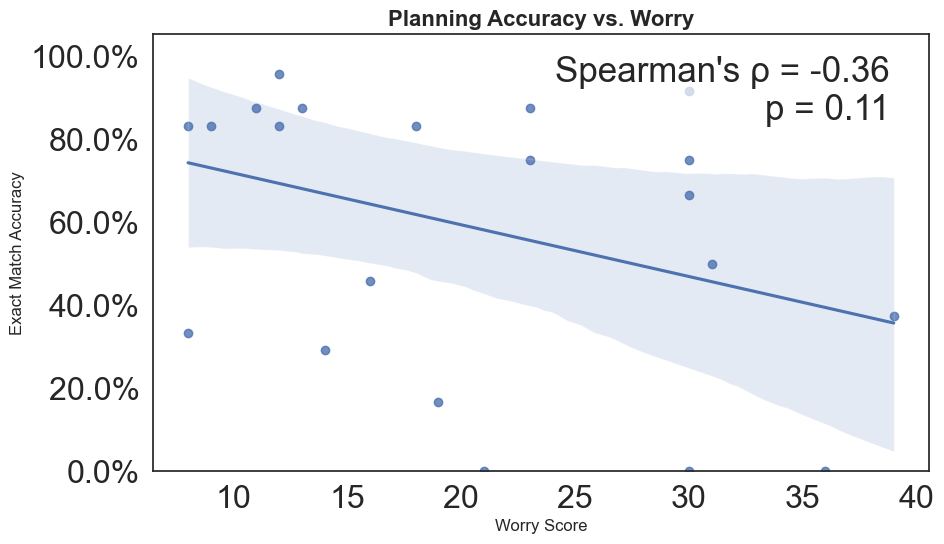


--- Correlation with Somatic_Anxiety ---
  Pearson's r: -0.415, p-value: 0.061
  Spearman's ρ: -0.445, p-value: 0.043
✅ Correlation plot saved to 'correlation_accuracy_vs_somatic_anxiety.png'


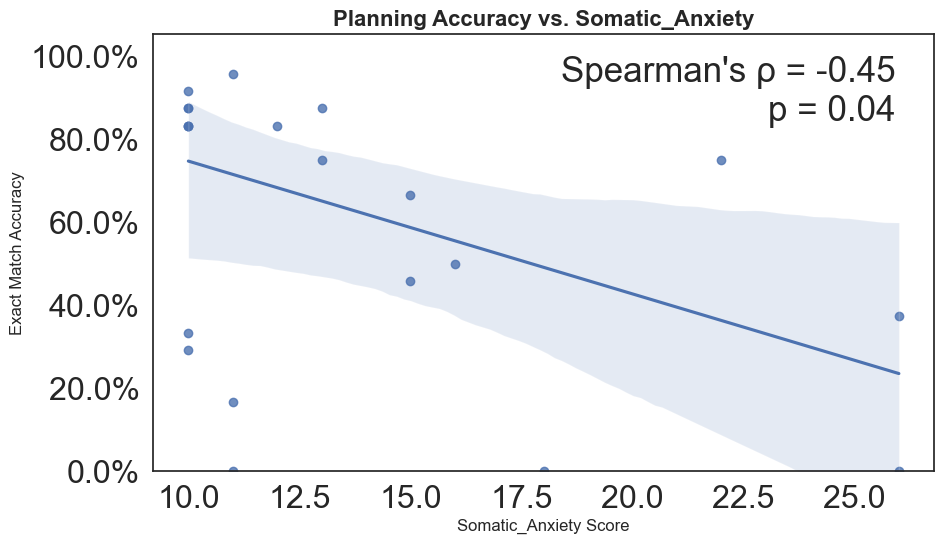

Generating plot...


C:\Users\sharp\AppData\Local\Temp\ipykernel_21416\981784341.py:215: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


✅ Plot successfully saved to 'participant_exact_match_accuracy.png'


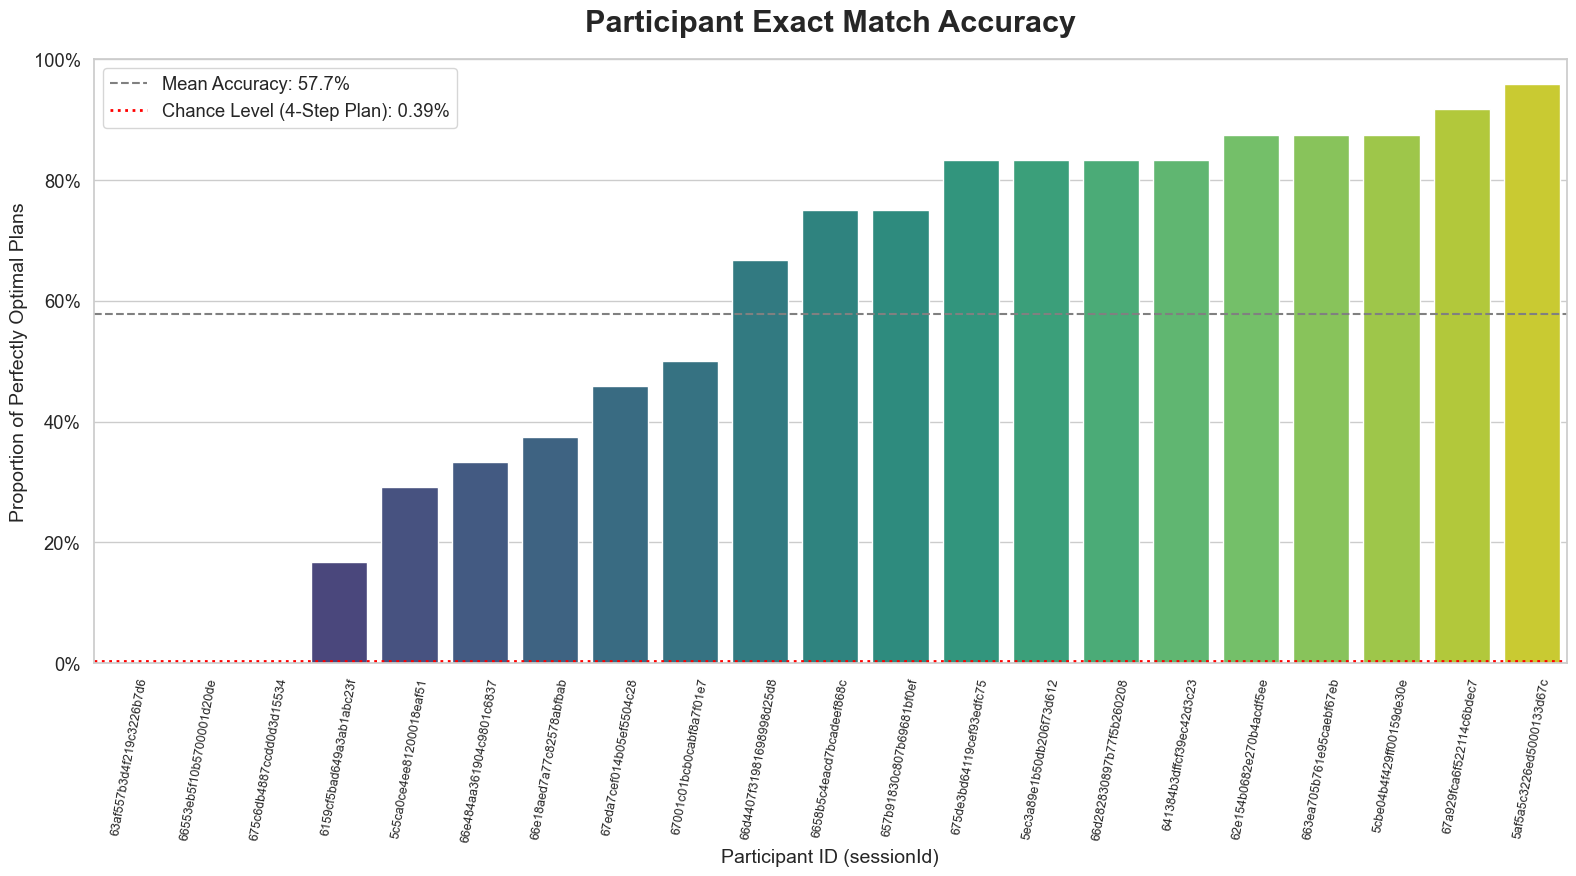

In [79]:
#!/usr/bin/env python3
"""
planning_optimality_analysis.py (Exact Match Version)
─────────────────────────────────────────────────────
Measures and plots participant planning accuracy against the optimal route
using a strict, binary scoring system: 1 for a perfect match, 0 otherwise.

This script calculates an "exact match accuracy" score, ignoring whether
the correct vehicle-specific keys were used, and runs a one-sample t-test
against the theoretical chance performance level.
"""

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import json
from pathlib import Path
import sys
from scipy.stats import ttest_1samp

# ─── Configuration ────────────────────────────────────────────────────────

# The CSV file containing the trial data.
CSV_PATH = Path("game_trials_export_v1.csv")
CHANCE_PERFORMANCE = 1 / (4**4) # Chance level for a 4-step plan (1/256)
WORRY_COL     = "worry"
SOMA_COL      = "somatic_anxiety"
SUBJECT_COL   = "prolificId"
# A universal mapping of every possible key to its intended direction.
UNIVERSAL_KEY_MAP = {
    # Up/Down Keys
    'e': 'up', 'c': 'down',  # Car-specific up/down
    't': 'up', 'b': 'down',  # Truck-specific up/down
    # Left/Right Keys
    'q': 'left', 'w': 'right', # Small Car L/R
    'z': 'left', 'x': 'right', # Big Car L/R
    'n': 'left', 'm': 'right', # Truck L/R
    'y': 'left', 'u': 'right'  # Pickup Truck L/R
}


# ─── Helper Functions ─────────────────────────────────────────────────────

def safe_str(x):
    """Safely convert a value to a string, handling None or NaN."""
    return str(x) if x is not None and pd.notna(x) else ""

def parse_optimal_route(json_str):
    """Parse the JSON string from the 'optimalRoute' column."""
    try:
        # Standardize all directions to lowercase
        return [direction.lower() for direction in json.loads(json_str)]
    except (json.JSONDecodeError, TypeError):
        return []

def calculate_exact_match_accuracy(row):
    """
    Calculates exact match accuracy for a single trial (a single row).

    Returns 1 if the participant's plan perfectly matches the optimal route's
    direction sequence, and 0 otherwise. Returns NaN if data is missing.
    """
    optimal_dirs = parse_optimal_route(row.optimalRoute)
    plan_keys = safe_str(row.plan_seq).lower()

    # If either the optimal route or the plan is missing, we can't score it.
    if not optimal_dirs or not plan_keys:
        return np.nan

    # Translate every key press into its universal direction.
    participant_dirs = [UNIVERSAL_KEY_MAP.get(key, 'unknown') for key in plan_keys]

    # The core logic: return 1 only if the two lists are identical.
    if participant_dirs == optimal_dirs:
        return 1.0
    else:
        return 0.0

# ─── Main Execution ───────────────────────────────────────────────────────

def main():
    """
    Main function to load data, perform analysis, and generate the plot.
    """
    # --- 1. Load and Filter Data ---
    if not CSV_PATH.exists():
        sys.exit(f"Error: Data file not found at '{CSV_PATH}'")

    print(f"Loading data from '{CSV_PATH}'...")
    df = pd.read_csv(CSV_PATH)
    df = df[df["phase"] == 2].copy()
    print(f"Filtered for Phase 2, retaining {len(df)} trials.")

    # --- 2. Calculate Exact Match Accuracy for Each Trial ---
    print("Calculating exact match accuracy for each trial...")
    df['exact_match_accuracy'] = df.apply(calculate_exact_match_accuracy, axis=1)

    # --- 3. Aggregate by Participant ---
    print("Aggregating results per participant...")
    # The mean of a binary (0/1) column is the proportion of 1s.
    exact_match_per_participant = df.groupby(SUBJECT_COL)['exact_match_accuracy'].mean().dropna()

    if exact_match_per_participant.empty:
        print("No valid data available to plot after processing. Exiting.")
        return

    # Sort participants by their score for a cleaner plot
    exact_match_per_participant = exact_match_per_participant.sort_values()
    print(f"Found valid data for {len(exact_match_per_participant)} participants.")

    # --- 4. Perform Statistical Test (T-Test) ---
    print("\n" + "="*50)
    print("PERFORMING ONE-SAMPLE T-TEST")
    print("="*50)
    
    t_statistic, p_value = ttest_1samp(
        a=exact_match_per_participant,
        popmean=CHANCE_PERFORMANCE,
        alternative='greater'
    )
    mean_obs_accuracy = exact_match_per_participant.mean()
    
    print(f"Mean Observed Accuracy: {mean_obs_accuracy:.4f} ({mean_obs_accuracy:.2%})")
    print(f"T-statistic: {t_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    if p_value < 0.05:
        print("Result: Statistically significant (p < .05).")
    else:
        print("Result: Not statistically significant (p >= .05).")

    # --- 5. Generate Scientific Reporting String ---
    std_dev = exact_match_per_participant.std()
    degrees_of_freedom = len(exact_match_per_participant) - 1

    # Format p-value for reporting according to APA style
    if p_value < 0.001:
        p_string = "p < .001"
    else:
        # round to 3 decimal places and remove leading zero
        p_string = f"p = {p_value:.3f}".replace("0.", ".")

    reporting_string = (
        f"A one-sample t-test confirmed that the mean exact match accuracy "
        f"(M = {mean_obs_accuracy:.2%}, SD = {std_dev:.2%}) was significantly greater "
        f"than the chance-level performance of {CHANCE_PERFORMANCE:.2%}, "
        f"t({degrees_of_freedom}) = {t_statistic:.2f}, {p_string}."
    )

    print("\n" + "="*50)
    print("SCIENTIFIC REPORTING STRING")
    print("="*50)
    print("Copy the line below for your paper's results section:")
    print(reporting_string)
    print("="*50 + "\n")

    # --- 6. Correlation Analysis with Anxiety ---
    print("\n" + "="*50)
    print("ANALYZING CORRELATION WITH ANXIETY")
    print("="*50)

    # Prepare data by merging accuracy with anxiety scores
    accuracy_df = exact_match_per_participant.reset_index(name='exact_match_accuracy')
    anxiety_df = df[[SUBJECT_COL, WORRY_COL, SOMA_COL]].drop_duplicates(subset=[SUBJECT_COL])
    merged_df = pd.merge(accuracy_df, anxiety_df, on=SUBJECT_COL)

    for anxiety_measure in [WORRY_COL, SOMA_COL]:
        print(f"\n--- Correlation with {anxiety_measure.title()} ---")
        
        # Drop rows with missing data for this specific analysis
        sub_df = merged_df[['exact_match_accuracy', anxiety_measure]].dropna()
        
        if len(sub_df) < 3:
            print(f"Not enough data to calculate correlation for {anxiety_measure}.")
            continue

        # Calculate correlations
        pearson_corr, pearson_p = pearsonr(sub_df[anxiety_measure], sub_df['exact_match_accuracy'])
        spearman_corr, spearman_p = spearmanr(sub_df[anxiety_measure], sub_df['exact_match_accuracy'])
        
        print(f"  Pearson's r: {pearson_corr:.3f}, p-value: {pearson_p:.3f}")
        print(f"  Spearman's ρ: {spearman_corr:.3f}, p-value: {spearman_p:.3f}")

        # Create scatter plot
        plt.figure(figsize=(10, 6))
        sns.regplot(data=sub_df, x=anxiety_measure, y='exact_match_accuracy', robust=True)
        
        plt.title(f'Planning Accuracy vs. {anxiety_measure.title()}', fontsize=16, weight='bold')
        plt.xlabel(f'{anxiety_measure.title()} Score', fontsize=12)
        plt.ylabel('Exact Match Accuracy', fontsize=12)
        plt.ylim(0, max(0.1, sub_df['exact_match_accuracy'].max() * 1.1)) # Adjust y-axis for better visibility
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))
        
        # Add annotation
        plt.text(0.95, 0.95, f"Spearman's ρ = {spearman_corr:.2f}\np = {spearman_p:.2f}",
                 ha='right', va='top', transform=plt.gca().transAxes,
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))
        
        plt.tight_layout()
        
        # Save and show plot
        output_filename = f"correlation_accuracy_vs_{anxiety_measure}.png"
        plt.savefig(output_filename, dpi=300)
        print(f"✅ Correlation plot saved to '{output_filename}'")
        plt.show()



    # --- 6. Plot the Results ---
    print("Generating plot...")
    plt.figure(figsize=(16, 9))
    sns.set_theme(style="whitegrid", font_scale=2)

    ax = sns.barplot(
        x=exact_match_per_participant.index,
        y=exact_match_per_participant.values,
        palette="viridis"
    )

    # --- 7. Format the Plot ---
    ax.set_title('Participant Exact Match Accuracy', font_scale=22, weight='bold', pad=20)
    ax.set_xlabel('Participant ID (sessionId)', fontsize=14)
    ax.set_ylabel('Proportion of Perfectly Optimal Plans', fontsize=14)
    plt.xticks(rotation=80, fontsize=9)
    ax.set_ylim(0, 1)

    # Format y-axis labels as percentages
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

    # Add a horizontal line for the average performance
    ax.axhline(mean_obs_accuracy, ls='--', color='gray', lw=1.5,
               label=f'Mean Accuracy: {mean_obs_accuracy:.1%}')

    # Add a horizontal line for chance-level performance
    ax.axhline(CHANCE_PERFORMANCE, ls=':', color='red', lw=2,
               label=f'Chance Level (4-Step Plan): {CHANCE_PERFORMANCE:.2%}')

    ax.legend()
    plt.tight_layout()

    # --- 8. Save and Show ---
    output_filename = "participant_exact_match_accuracy.png"
    plt.savefig(output_filename, dpi=300)
    print(f"✅ Plot successfully saved to '{output_filename}'")
    plt.show()

if __name__ == "__main__":
    main()



Loading data from 'game_trials_export_v1.csv'...

--- Analyzing Dangerous Key Press Count vs. Worry Score ---
Correlation between total dangerous key presses and worry score:
  Spearman's ρ = -0.240
  p-value = 0.294

✅ Correlation plot saved to 'dangerous_key_count_vs_worry_correlation.png'


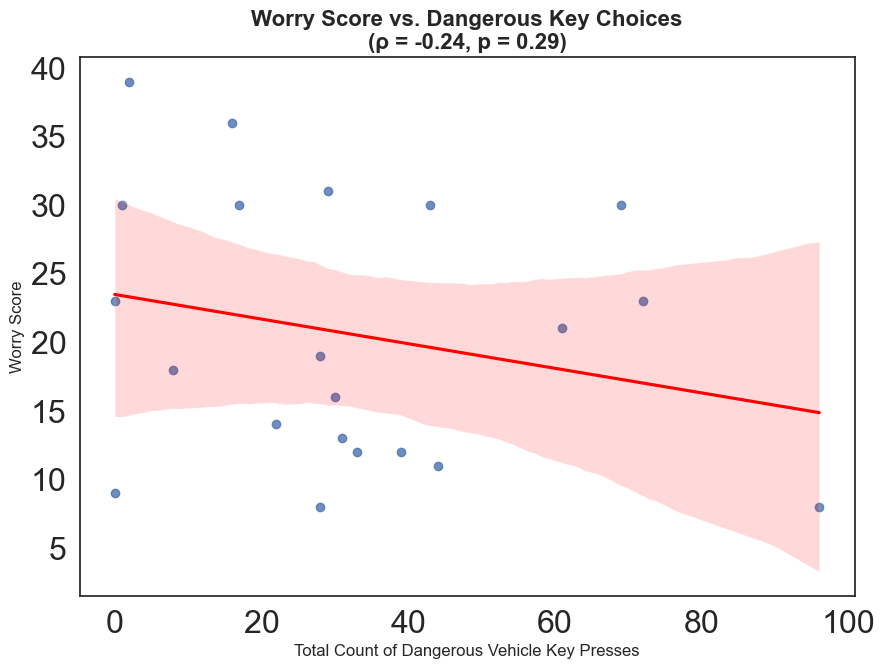

In [71]:
#!/usr/bin/env python3
"""
correlation_analysis.py
────────────────────────────────
Analyzes the correlation between the total count of dangerous key presses
for each participant and their self-reported worry score.
"""
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# ─── Configuration ─────────────────────────
CSV_PATH = Path("game_trials_export_v1.csv")
ORIGINAL_SUBJECT_COL = "prolificId"
PARTICIPANT_ID_COL = "participant_id"
PHASE_COL = "phase"
PLAN_COL = "plan_seq"
DANGEROUS_COL = "dangerous_vehicle"
WORRY_COL = "worry"

# --- Mappings & Constants ---
car_up = {"e", "c"}
all_truck_up = {"t", "b"}
small_car_lr = {"q", "w"}
big_car_lr = {"z", "x"}
truck_lr = {"n", "m"}
pickup_truck_lr = {"y", "u"}

VALID_KEYS = {
    "small_car": small_car_lr | car_up,
    "big_car": big_car_lr | car_up,
    "truck": truck_lr | all_truck_up,
    "pickup_truck": pickup_truck_lr | all_truck_up,
    "medium_car": small_car_lr | big_car_lr | car_up,
    "dump_truck": truck_lr | pickup_truck_lr | all_truck_up,
}

# ─── Helper Functions ───────────────────────────────────────────────────

def parse_plan(seq):
    if not isinstance(seq, str): return []
    return [ch.lower() for ch in seq if ch.isalpha()]

# 🆕 THE REQUESTED FUNCTION
def analyze_dangerous_key_count_vs_worry(df):
    """
    Calculates the gross count of dangerous key presses per participant and
    correlates this count with their worry score.
    """
    print("\n--- Analyzing Dangerous Key Press Count vs. Worry Score ---")

    # 1. Get participant-level info
    participant_info = df.drop_duplicates(subset=[PARTICIPANT_ID_COL]).copy()
    participant_info = participant_info[[PARTICIPANT_ID_COL, DANGEROUS_COL, WORRY_COL]]

    # 2. Create a long-format DataFrame: one row per key press
    records = []
    for _, row in df.iterrows():
        for key in parse_plan(row[PLAN_COL]):
            records.append({'participant_id': row[PARTICIPANT_ID_COL], 'key_pressed': key})
    key_press_df = pd.DataFrame(records)

    # 3. Merge participant info to know the dangerous vehicle for each press
    key_press_df = key_press_df.merge(participant_info, on=PARTICIPANT_ID_COL, how='left')

    # 4. Identify if each press was a "dangerous" choice
    def is_dangerous_press(row):
        dangerous_keys = VALID_KEYS.get(row[DANGEROUS_COL], set())
        return 1 if row['key_pressed'] in dangerous_keys else 0
    key_press_df['is_dangerous_choice'] = key_press_df.apply(is_dangerous_press, axis=1)

    # 5. Sum choices by participant to get the total count
    dangerous_counts = key_press_df.groupby(PARTICIPANT_ID_COL)['is_dangerous_choice'].sum()
    dangerous_counts = dangerous_counts.reset_index().rename(columns={'is_dangerous_choice': 'dangerous_key_count'})

    # 6. Merge counts with worry scores for analysis
    analysis_df = pd.merge(participant_info, dangerous_counts, on=PARTICIPANT_ID_COL)

    # 7. Perform and report correlation
    corr, p_value = stats.spearmanr(analysis_df['dangerous_key_count'], analysis_df[WORRY_COL])
    print(f"Correlation between total dangerous key presses and worry score:")
    print(f"  Spearman's ρ = {corr:.3f}")
    print(f"  p-value = {p_value:.3f}")

    # 8. Visualize the correlation
    plt.figure(figsize=(10, 7))
    sns.regplot(
        data=analysis_df, x='dangerous_key_count', y=WORRY_COL,
        robust=True, line_kws={"color": "red"}
    )
    plt.title(
        f"Worry Score vs. Dangerous Key Choices\n(ρ = {corr:.2f}, p = {p_value:.2f})",
        fontsize=16, weight='bold'
    )
    plt.xlabel("Total Count of Dangerous Vehicle Key Presses", fontsize=12)
    plt.ylabel("Worry Score", fontsize=12)
    
    filename = "dangerous_key_count_vs_worry_correlation.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"\n✅ Correlation plot saved to '{filename}'")

# ─── Main Execution ───────────────────────────────────────────────────────

def main():
    if not CSV_PATH.exists():
        sys.exit(f"Error: Data file not found at '{CSV_PATH}'")
    
    print(f"Loading data from '{CSV_PATH}'...")
    df = pd.read_csv(CSV_PATH)
    df_phase2 = df[df[PHASE_COL] == 2].copy()

    unique_ids = df_phase2[ORIGINAL_SUBJECT_COL].unique()
    id_map = {old_id: new_id for new_id, old_id in enumerate(unique_ids, 1)}
    df_phase2[PARTICIPANT_ID_COL] = df_phase2[ORIGINAL_SUBJECT_COL].map(id_map)

    # --- Call the analysis function on the full Phase 2 dataset ---
    analyze_dangerous_key_count_vs_worry(df_phase2)

if __name__ == "__main__":
    main()

Loading data from 'game_trials_export.csv'...
Filtered for Phase 2, retaining 720 trials.
Simplified 30 Prolific IDs to simple integer IDs.

--- Analyzing Dangerous Key Press Count vs. Worry Score (Study 2) ---
Correlation between total dangerous key presses and worry score:
  Spearman's ρ = -0.408
  p-value = 0.025

✅ Correlation plot saved to 'study2_dangerous_key_count_vs_worry_correlation.png'

Script finished.


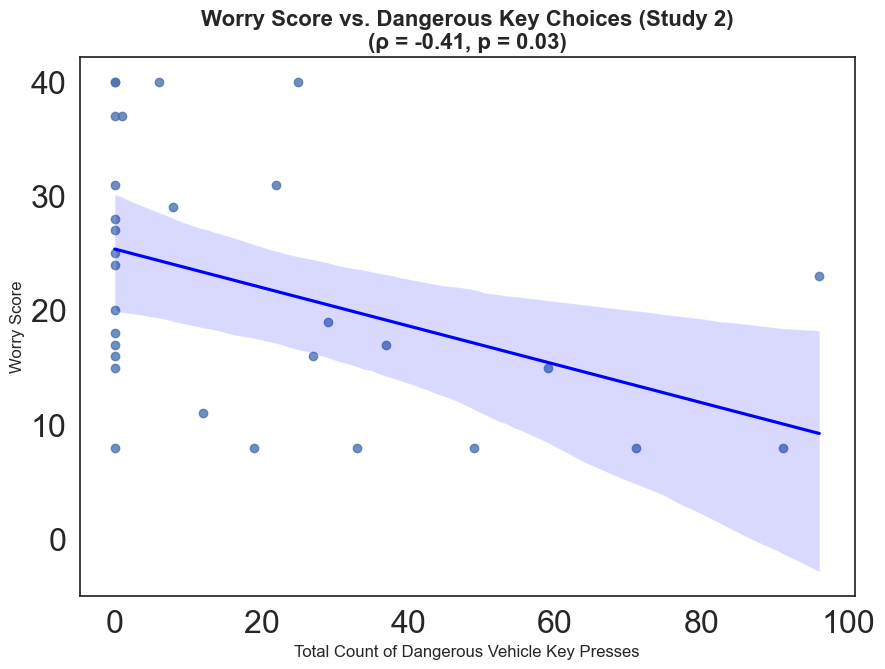

In [72]:
#!/usr/bin/env python3
"""
combined_analysis.py
────────────────────
A comprehensive analysis script that integrates dangerous vehicle generalization,
planning optimality, and their relationships with anxiety measures.
"""
import json
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import logit
from collections import defaultdict

sns.set_theme(style="white", font_scale=2.1)

# ─── Configuration ────────────────────────────────────────────────────────
CSV_PATH = Path("game_trials_export.csv")
SUBJECT_COL = "prolificId"
PHASE_COL = "phase"
VEHICLE_COL = "vehicleType"
PLAN_COL = "plan_seq"
DANGEROUS_COL = "dangerous_vehicle"
OPTIMAL_ROUTE_COL = "optimalRoute"
WORRY_COL = "worry"
SOMA_COL = "somatic_anxiety"
PARTICIPANT_ID_COL="participant_id"
# --- Mappings & Constants ---
VALID_KEYS = {
    "small_car": ["a", "d", "w", "x"],
    "big_car": ["s", "f", "e", "c"],
    "medium_car": ["a", "s", "d", "f", "w", "e", "x", "c"],
    "small_sedan": ["g", "j", "y", "n"],
    "big_sedan": ["h", "k", "u", "m"],
    "medium_sedan": ["g", "h", "j", "k", "y", "u", "n", "m"],
}
BIG_SMALL_SET = {"small_car", "big_car", "small_sedan", "big_sedan"}
KEY_TO_CATEGORY = defaultdict(list)
for category, keys in VALID_KEYS.items():
    for key in keys:
        KEY_TO_CATEGORY[key].append(category)

UNIVERSAL_KEY_MAP = {
    'w': 'up', 'e': 'up', 'y': 'up', 'u': 'up',
    'x': 'down', 'c': 'down', 'n': 'down', 'm': 'down',
    'a': 'left', 's': 'left', 'g': 'left', 'h': 'left',
    'd': 'right', 'f': 'right', 'j': 'right', 'k': 'right',
}
CHANCE_PERFORMANCE = 1 / (4**4)

# ─── Helper Functions ─────────────────────────────────────────────────────

def parse_plan(seq):
    if not isinstance(seq, str):
        return []
    return [ch.lower() for ch in seq if ch.isalpha()]

# (Your other helper functions like analyse_subj, create_mistake_df, etc. would go here)
# ...

# 🆕 NEW FUNCTION FOR THE REQUESTED ANALYSIS
def analyze_dangerous_key_count_vs_worry(df):
    """
    Calculates the gross count of dangerous key presses per participant for Study 2
    and correlates this count with their worry score.
    """
    print("\n--- Analyzing Dangerous Key Press Count vs. Worry Score (Study 2) ---")

    # 1. Create a dataframe with one row per participant, holding their info
    participant_info = df.drop_duplicates(subset=[PARTICIPANT_ID_COL]).copy()
    participant_info = participant_info[[PARTICIPANT_ID_COL, DANGEROUS_COL, WORRY_COL]]

    # 2. Create a long-format DataFrame: one row per single key press
    records = []
    for _, row in df.iterrows():
        for key in parse_plan(row[PLAN_COL]):
            records.append({
                PARTICIPANT_ID_COL: row[PARTICIPANT_ID_COL],
                'key_pressed': key
            })
    key_press_df = pd.DataFrame(records)

    # 3. Merge participant info to know which vehicle is dangerous for each key press
    key_press_df = key_press_df.merge(participant_info, on=PARTICIPANT_ID_COL, how='left')

    # 4. Check if each key press belongs to the participant's dangerous vehicle type
    def is_dangerous_press(row):
        # Convert list of keys to a set for efficient lookup
        dangerous_keys = set(VALID_KEYS.get(row[DANGEROUS_COL], []))
        return 1 if row['key_pressed'] in dangerous_keys else 0

    key_press_df['is_dangerous_choice'] = key_press_df.apply(is_dangerous_press, axis=1)

    # 5. Group by participant and sum the choices to get the total count
    dangerous_counts = key_press_df.groupby(PARTICIPANT_ID_COL)['is_dangerous_choice'].sum()
    dangerous_counts = dangerous_counts.reset_index().rename(columns={'is_dangerous_choice': 'dangerous_key_count'})

    # 6. Merge the counts with the worry scores for the final analysis
    analysis_df = pd.merge(participant_info, dangerous_counts, on=PARTICIPANT_ID_COL)

    # 7. Perform and report the correlation
    corr, p_value = stats.spearmanr(analysis_df['dangerous_key_count'], analysis_df[WORRY_COL])
    
    print(f"Correlation between total dangerous key presses and worry score:")
    print(f"  Spearman's ρ = {corr:.3f}")
    print(f"  p-value = {p_value:.3f}")

    # 8. Visualize the correlation
    plt.figure(figsize=(10, 7))
    sns.regplot(
        data=analysis_df,
        x='dangerous_key_count',
        y=WORRY_COL,
        robust=True, 
        line_kws={"color": "blue"}
    )
    plt.title(
        f"Worry Score vs. Dangerous Key Choices (Study 2)\n(ρ = {corr:.2f}, p = {p_value:.2f})",
        fontsize=16, weight='bold'
    )
    plt.xlabel("Total Count of Dangerous Vehicle Key Presses", fontsize=12)
    plt.ylabel("Worry Score", fontsize=12)
    
    filename = "study2_dangerous_key_count_vs_worry_correlation.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"\n✅ Correlation plot saved to '{filename}'")


# ─── Main Execution ───────────────────────────────────────────────────────

def main():
    # === 1. Load and Prepare Data ===
    if not CSV_PATH.exists():
        sys.exit(f"Error: Data file not found at '{CSV_PATH}'")
    print(f"Loading data from '{CSV_PATH}'...")
    df = pd.read_csv(CSV_PATH)
    df_phase2 = df[df[PHASE_COL] == 2].copy()
    print(f"Filtered for Phase 2, retaining {len(df_phase2)} trials.")

    # --- Simplify Participant IDs ---
    unique_ids = df_phase2[SUBJECT_COL].unique()
    id_map = {old_id: f"P{new_id}" for new_id, old_id in enumerate(unique_ids, 1)}
    df_phase2[PARTICIPANT_ID_COL] = df_phase2[SUBJECT_COL].map(id_map)
    print(f"Simplified {len(unique_ids)} Prolific IDs to simple integer IDs.")

    # === 2. Run the Requested Analysis ===
    analyze_dangerous_key_count_vs_worry(df_phase2)

    # (Your other analyses and plotting function calls would continue here)
    # ...
    
    print("\nScript finished.")

if __name__ == "__main__":
    main()